In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import emoji
from num2words import num2words
import nltk
#!pip install tensorflow
from nltk.corpus import stopwords
import tensorflow as tf 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
#nltk.download('stopwords')
#nltk.download('wordnet')
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from matplotlib import colors
from wordcloud import WordCloud 

In [2]:
#!pip install ipynb 
from ipynb.fs.full.preprocessor_class import Preprocessor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andreea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andreea\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
train_data = pd.read_csv('data/shuffled_train_data.csv',index_col=None)
train_labels = pd.read_csv('data/shuffled_train_labels.csv',index_col=None)

test_data = pd.read_csv('data/test_data.csv',index_col=None)
test_labels = pd.read_csv('data/test_labels.csv',index_col=None)

validation_data = pd.read_csv('data/validation_data.csv',index_col=None)
validation_labels = pd.read_csv('data/validation_labels.csv',index_col=None)

train_data_plot = pd.read_csv('data/train_data_plot.csv',index_col=None)
test_data_plot = pd.read_csv('data/test_data_plot.csv',index_col=None)

train_data.shape

(45000, 1)

In [4]:
preprocessor = Preprocessor(set(stopwords.words('english')), WordNetLemmatizer(), PorterStemmer(), True, True, True, True, True, False, True, True, True, False)

preprocessed_data_train = pd.DataFrame(columns = ['text'])
preprocessed_data_test = pd.DataFrame(columns = ['text'])
preprocessed_data_validation = pd.DataFrame(columns = ['text'])

preprocessed_data_train['text'] = train_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)

preprocessed_data_test['text'] = test_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)
preprocessed_data_validation['text'] = validation_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)

In [5]:
preprocessed_data_train['text']

0        [ordered, small, gift, co, worker, fine, price...
1        [crocs, best, strap, bit, tight, back, shoe, h...
2        [light, warm, look, better, person, website, g...
3        [wish, overestimate, ring, size, ordered, big,...
4        [far, best, trail, shoe, huge, merrell, fan, h...
                               ...                        
44995    [usually, love, keen, pair, durable, velcro, c...
44996    [left, side, shoe, got, burst, sure, sad, thin...
44997    [love, purse, reminds, hippie, day, wide, enou...
44998    [returned, scarf, horrible, green, color, long...
44999    [kurti, looked, much, better, line, bought, sm...
Name: text, Length: 45000, dtype: object

In [6]:
preprocessed_data_test['text'] = preprocessed_data_test['text'].apply(lambda x: ' '.join(map(str, x)))
preprocessed_data_validation['text'] = preprocessed_data_validation['text'].apply(lambda x: ' '.join(map(str, x)))

preprocessed_data_train['text'] = preprocessed_data_train['text'].apply(lambda x: ' '.join(map(str, x)))

In [7]:
list_labels = []
for el in train_labels['label']:
    if el == 'positive':
        list_labels.append(2)
    if el == 'negative':
        list_labels.append(0)
    if el == 'neutral':
        list_labels.append(1)

In [8]:
list_test = []
for el in test_labels['label']:
    if el == 'positive':
        list_test.append(2)
    if el == 'negative':
        list_test.append(0)
    if el == 'neutral':
        list_test.append(1)
        
list_val = []
for el in validation_labels['label']:
    if el == 'positive':
        list_val.append(2)
    if el == 'negative':
        list_val.append(0)
    if el == 'neutral':
        list_val.append(1)

In [9]:
# Sort indices in sparse data
def sort_sparse_indices(matrix):
    co = matrix.tocoo()
    sorted_indices = np.lexsort((co.col, co.row))
    return tf.sparse.reorder(tf.sparse.SparseTensor(
        indices = np.column_stack((co.row[sorted_indices], co.col[sorted_indices])),
        values = co.data[sorted_indices],
        dense_shape = co.shape
    ))


Epoch 1/100


1407/1407 [==============================] - 8s 4ms/step - loss: 1.0075 - accuracy: 0.6027 - val_loss: 0.8801 - val_accuracy: 0.6747
Epoch 2/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7986 - accuracy: 0.6737 - val_loss: 0.7351 - val_accuracy: 0.6986
Epoch 3/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7020 - accuracy: 0.7016 - val_loss: 0.6833 - val_accuracy: 0.7085
Epoch 4/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6585 - accuracy: 0.7192 - val_loss: 0.6628 - val_accuracy: 0.7121
Epoch 5/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6341 - accuracy: 0.7287 - val_loss: 0.6522 - val_accuracy: 0.7178
Epoch 6/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6165 - accuracy: 0.7362 - val_loss: 0.6469 - val_accuracy: 0.7196
Epoch 7/100
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6036 - accuracy: 0.7418 - val_loss: 0.6449 - val

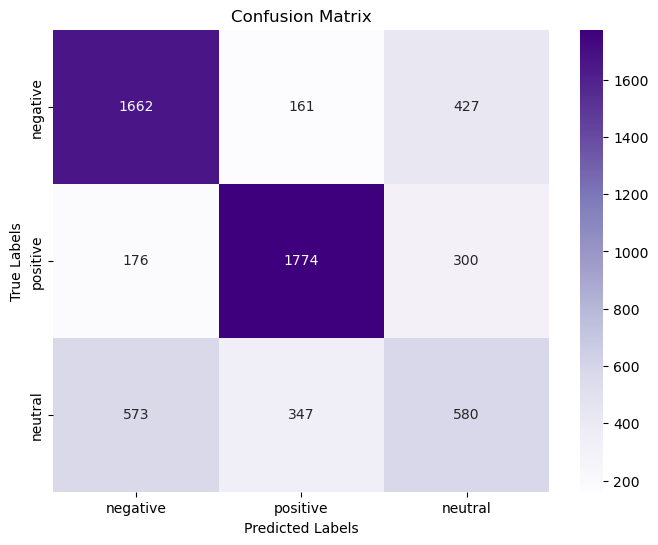

In [13]:
#testare pe 100 de epoci cu par cei mai buni de la hiperparametrizarea de mai jos
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
train_tfidf = tfidf_vectorizer.fit_transform(preprocessed_data_train['text']) 
test_tfidf = tfidf_vectorizer.transform(preprocessed_data_test['text'])
val_tfidf = tfidf_vectorizer.transform(preprocessed_data_validation['text'])

build_model = [tf.keras.layers.Input(shape = (5000,), sparse = True)]
build_model.append(tf.keras.layers.Dense(64, activation = 'relu'))
build_model.append(tf.keras.layers.Dropout(0.3))
build_model.append(tf.keras.layers.Dense(3, activation = 'softmax'))
model = tf.keras.models.Sequential(build_model)
optimizer = Adam(learning_rate = 0.0001)  
model.compile(optimizer = optimizer,
     loss = 'sparse_categorical_crossentropy',
     metrics = ['accuracy'])
train_tfidf_sorted = sort_sparse_indices(train_tfidf)
model.fit(sort_sparse_indices(train_tfidf), np.array(list_labels),
    epochs = 100, batch_size = 32, initial_epoch = 0, 
    validation_data=(sort_sparse_indices(val_tfidf), np.array(list_val))) 
test_loss, test_metrics = model.evaluate(sort_sparse_indices(test_tfidf), np.array(list_test), verbose = 0) 
#print('\n ngram_range -', ngram_range, 'max_ft -', max_ft, 'layers_no -',layers_no, 'units_no -',units_no, 'learning_rate -',learning_rate, '- LOSS -', test_loss, ' ACCURACY -', test_metrics)

test_predictions = model.predict(sort_sparse_indices(test_tfidf))
predicted_labels = np.argmax(test_predictions, axis = 1)

print(classification_report(np.array(list_test), predicted_labels))
conf_matrix = confusion_matrix(np.array(list_test), predicted_labels)

plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Purples", xticklabels = ['negative', 'positive', 'neutral'], yticklabels = ['negative', 'positive', 'neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0033 - accuracy: 0.5968 - val_loss: 0.8834 - val_accuracy: 0.6599
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8129 - accuracy: 0.6612 - val_loss: 0.7475 - val_accuracy: 0.6807
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7286 - accuracy: 0.6853 - val_loss: 0.6925 - val_accuracy: 0.7035
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6909 - accuracy: 0.7013 - val_loss: 0.6642 - val_accuracy: 0.7154
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6694 - accuracy: 0.7117 - val_loss: 0.6467 - val_accuracy: 0.7240
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6561 - accuracy: 0.7171 - val_loss: 0.6348 - val_accuracy: 0.7289
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6453 - accuracy: 0.7232 - val_loss: 0.6257 - val_accuracy:

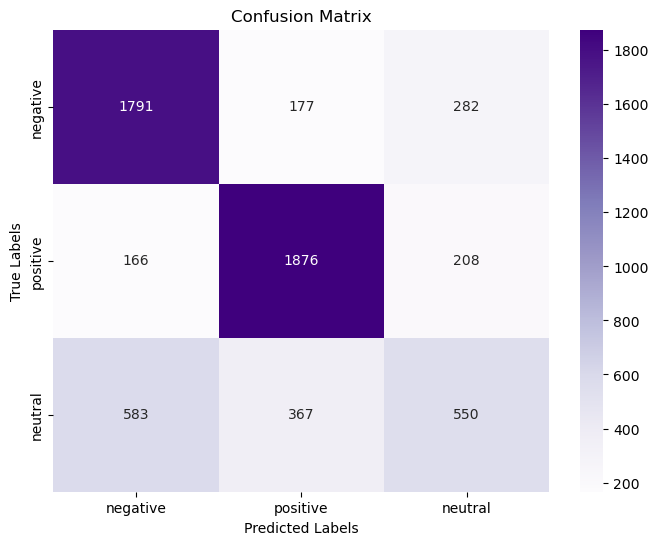

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0922 - accuracy: 0.4238 - val_loss: 1.0859 - val_accuracy: 0.5066
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0799 - accuracy: 0.5226 - val_loss: 1.0728 - val_accuracy: 0.5879
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0659 - accuracy: 0.5776 - val_loss: 1.0575 - val_accuracy: 0.6218
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0496 - accuracy: 0.6098 - val_loss: 1.0401 - val_accuracy: 0.6376
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0316 - accuracy: 0.6242 - val_loss: 1.0211 - val_accuracy: 0.6455
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0122 - accuracy: 0.6347 - val_loss: 1.0010 - val_accuracy: 0.6489
Epoch 7/10
1407/1407 [=========

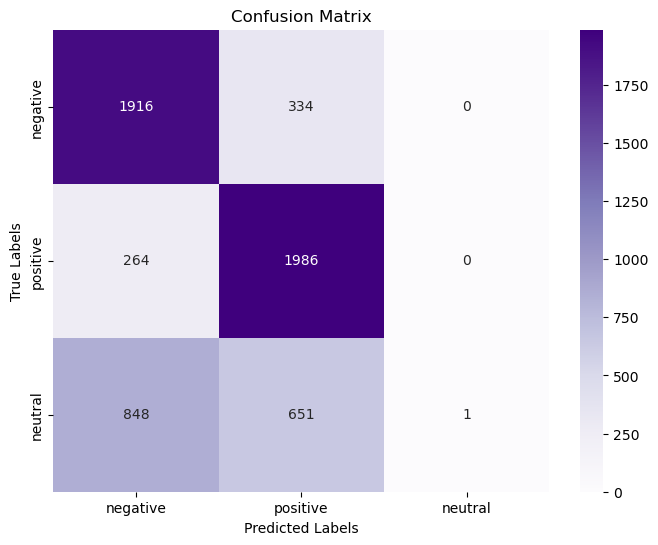

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9939 - accuracy: 0.5982 - val_loss: 0.8568 - val_accuracy: 0.6623
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7864 - accuracy: 0.6704 - val_loss: 0.7211 - val_accuracy: 0.6934
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7065 - accuracy: 0.6957 - val_loss: 0.6725 - val_accuracy: 0.7147
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6736 - accuracy: 0.7122 - val_loss: 0.6490 - val_accuracy: 0.7216
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6556 - accuracy: 0.7193 - val_loss: 0.6342 - val_accuracy: 0.7290
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6432 - accuracy: 0.7252 - val_loss: 0.6240 - val_accuracy: 0.7349
Epoch 7/10
1407/1407 [=========

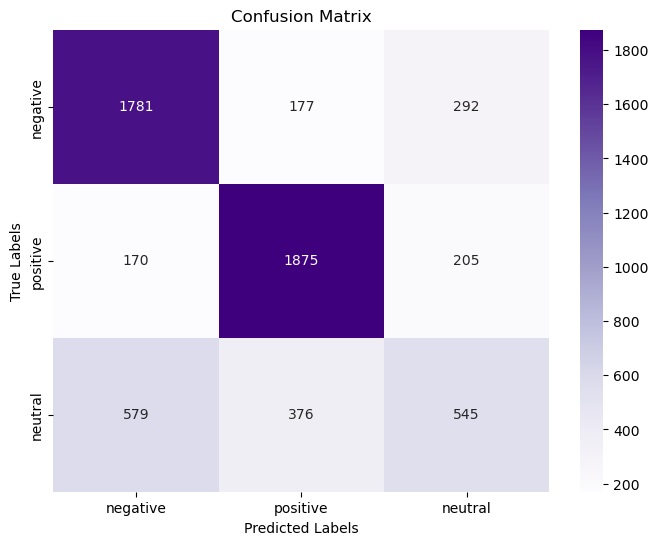

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0940 - accuracy: 0.3912 - val_loss: 1.0861 - val_accuracy: 0.4876
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0791 - accuracy: 0.5124 - val_loss: 1.0708 - val_accuracy: 0.5742
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0630 - accuracy: 0.5748 - val_loss: 1.0534 - val_accuracy: 0.6155
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0442 - accuracy: 0.6064 - val_loss: 1.0331 - val_accuracy: 0.6360
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0228 - accuracy: 0.6262 - val_loss: 1.0101 - val_accuracy: 0.6468
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9992 - accuracy: 0.6393 - val_loss: 0.9857 - val_accuracy: 0.6520
Epoch 7/10
1407/1407 [=========

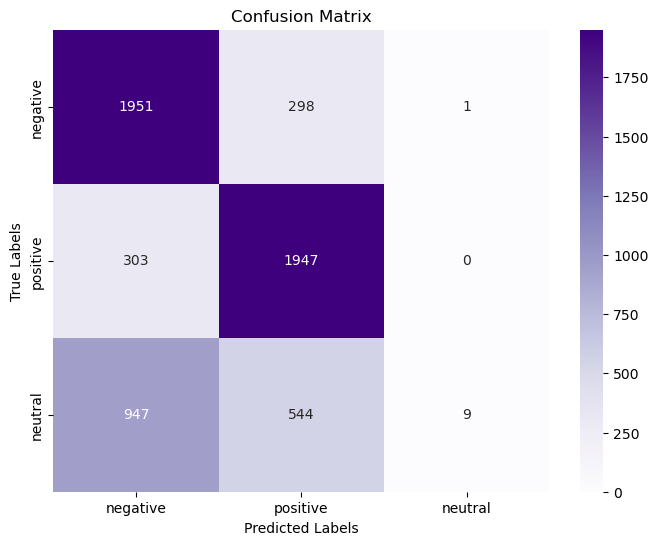

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 0.9356 - accuracy: 0.5853 - val_loss: 0.7297 - val_accuracy: 0.6768
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.7036 - accuracy: 0.6892 - val_loss: 0.6515 - val_accuracy: 0.7152
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6599 - accuracy: 0.7160 - val_loss: 0.6244 - val_accuracy: 0.7338
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6388 - accuracy: 0.7240 - val_loss: 0.6085 - val_accuracy: 0.7404
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6265 - accuracy: 0.7304 - val_loss: 0.5983 - val_accuracy: 0.7454
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6178 - accuracy: 0.7358 - val_loss: 0.5896 - val_accuracy: 0.7506
Epoch 7/10
1407/1407 [=========

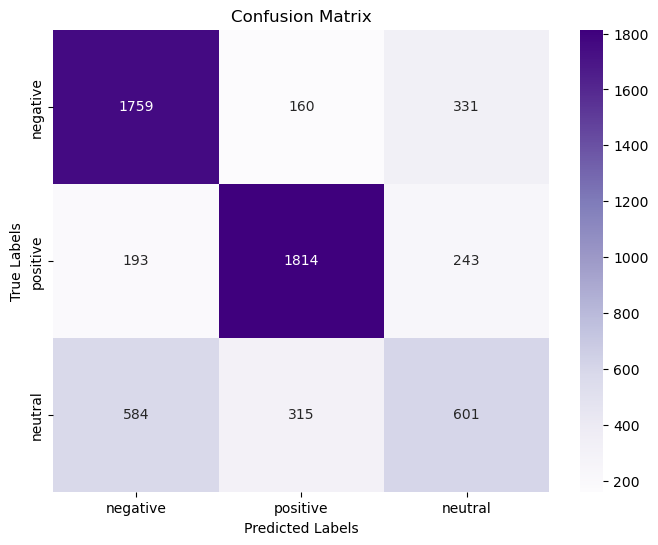

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0904 - accuracy: 0.4128 - val_loss: 1.0840 - val_accuracy: 0.4734
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0777 - accuracy: 0.4816 - val_loss: 1.0696 - val_accuracy: 0.5654
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0607 - accuracy: 0.5521 - val_loss: 1.0485 - val_accuracy: 0.6131
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0344 - accuracy: 0.6020 - val_loss: 1.0157 - val_accuracy: 0.6316
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9965 - accuracy: 0.6245 - val_loss: 0.9724 - val_accuracy: 0.6452
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9509 - accuracy: 0.6395 - val_loss: 0.9238 - val_accuracy: 0.6527
Epoch 7/10
1407/1407 [=========

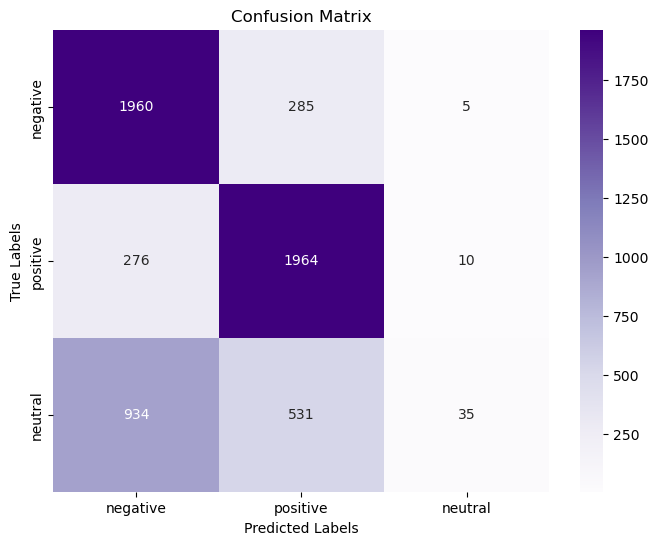

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9027 - accuracy: 0.5983 - val_loss: 0.7009 - val_accuracy: 0.6845
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6862 - accuracy: 0.6984 - val_loss: 0.6384 - val_accuracy: 0.7235
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6482 - accuracy: 0.7191 - val_loss: 0.6144 - val_accuracy: 0.7374
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6298 - accuracy: 0.7288 - val_loss: 0.6005 - val_accuracy: 0.7444
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6168 - accuracy: 0.7356 - val_loss: 0.5893 - val_accuracy: 0.7520
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6077 - accuracy: 0.7417 - val_loss: 0.5799 - val_accuracy: 0.7558
Epoch 7/10
1407/1407 [=========

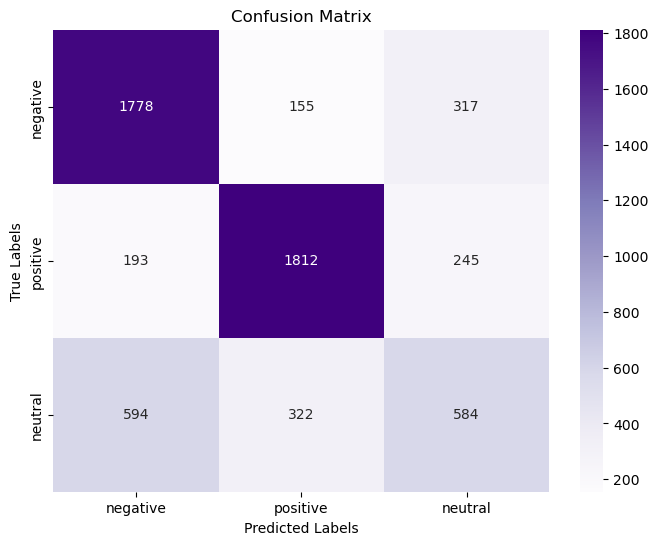

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0936 - accuracy: 0.4154 - val_loss: 1.0863 - val_accuracy: 0.5135
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0773 - accuracy: 0.5237 - val_loss: 1.0661 - val_accuracy: 0.5851
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0514 - accuracy: 0.5838 - val_loss: 1.0322 - val_accuracy: 0.6215
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0078 - accuracy: 0.6224 - val_loss: 0.9781 - val_accuracy: 0.6430
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9472 - accuracy: 0.6411 - val_loss: 0.9118 - val_accuracy: 0.6532
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8830 - accuracy: 0.6506 - val_loss: 0.8493 - val_accuracy: 0.6589
Epoch 7/10
1407/1407 [=========

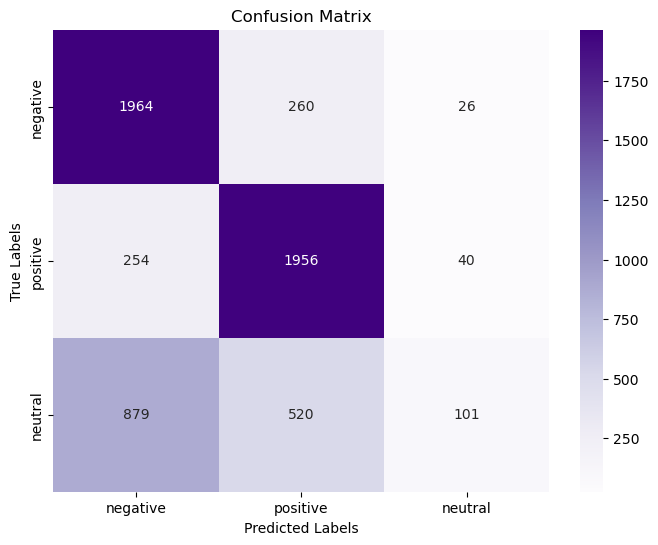

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 0.8953 - accuracy: 0.5839 - val_loss: 0.6890 - val_accuracy: 0.6971
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6840 - accuracy: 0.7000 - val_loss: 0.6283 - val_accuracy: 0.7316
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6456 - accuracy: 0.7232 - val_loss: 0.6056 - val_accuracy: 0.7414
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6270 - accuracy: 0.7312 - val_loss: 0.5882 - val_accuracy: 0.7531
Epoch 5/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6103 - accuracy: 0.7421 - val_loss: 0.5740 - val_accuracy: 0.7611
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5991 - accuracy: 0.7478 - val_loss: 0.5610 - val_accuracy: 0.7694
Epoch 7/10
1407/1407 [=========

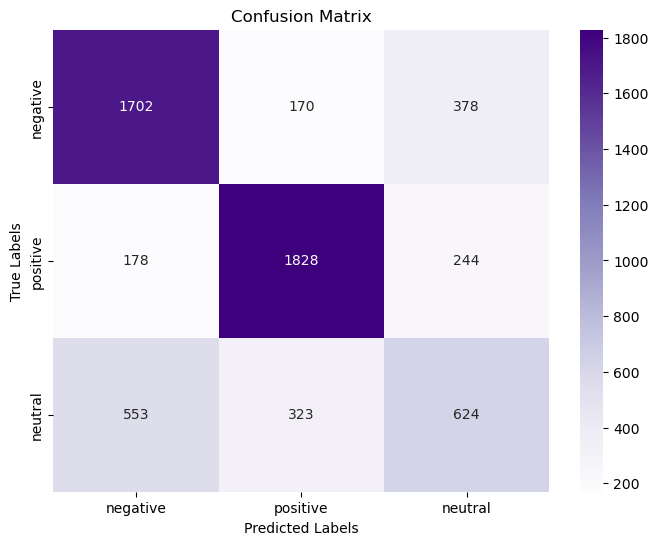

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0934 - accuracy: 0.3873 - val_loss: 1.0876 - val_accuracy: 0.3879
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0809 - accuracy: 0.4343 - val_loss: 1.0722 - val_accuracy: 0.4916
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0596 - accuracy: 0.5340 - val_loss: 1.0412 - val_accuracy: 0.6009
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0146 - accuracy: 0.6083 - val_loss: 0.9805 - val_accuracy: 0.6392
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9437 - accuracy: 0.6386 - val_loss: 0.8983 - val_accuracy: 0.6521
Epoch 6/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.8649 - accuracy: 0.6500 - val_loss: 0.8212 - val_accuracy: 0.6595
Epoch 7/10
1407/1407 [=========

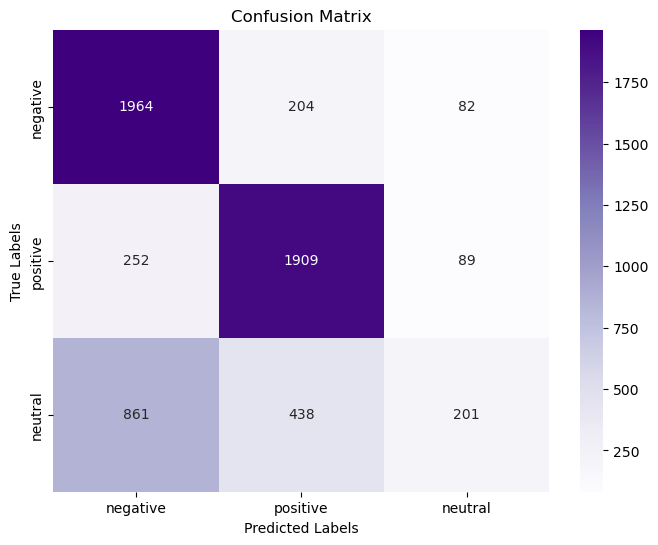

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8528 - accuracy: 0.6148 - val_loss: 0.6724 - val_accuracy: 0.7026
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6702 - accuracy: 0.7069 - val_loss: 0.6148 - val_accuracy: 0.7372
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6320 - accuracy: 0.7275 - val_loss: 0.5896 - val_accuracy: 0.7496
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6091 - accuracy: 0.7407 - val_loss: 0.5675 - val_accuracy: 0.7642
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5898 - accuracy: 0.7525 - val_loss: 0.5456 - val_accuracy: 0.7775
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5678 - accuracy: 0.7643 - val_loss: 0.5212 - val_accuracy: 0.7899
Epoch 7/10
1407/1407 [=========

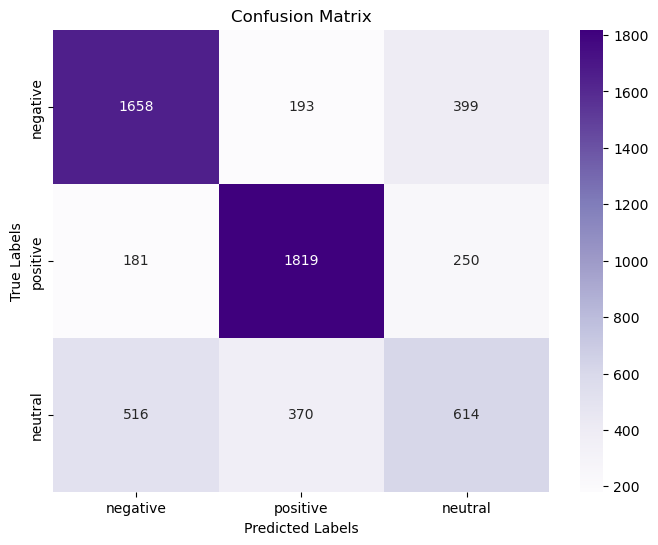

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0916 - accuracy: 0.4140 - val_loss: 1.0835 - val_accuracy: 0.4864
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0737 - accuracy: 0.5046 - val_loss: 1.0604 - val_accuracy: 0.5959
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0348 - accuracy: 0.6026 - val_loss: 0.9949 - val_accuracy: 0.6387
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9402 - accuracy: 0.6409 - val_loss: 0.8779 - val_accuracy: 0.6536
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8333 - accuracy: 0.6545 - val_loss: 0.7868 - val_accuracy: 0.6606
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7678 - accuracy: 0.6620 - val_loss: 0.7393 - val_accuracy: 0.6670
Epoch 7/10
1407/1407 [=========

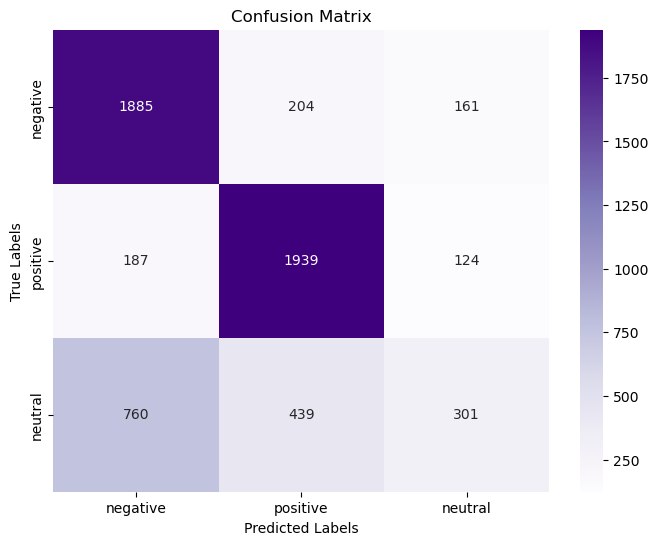

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0064 - accuracy: 0.5950 - val_loss: 0.8851 - val_accuracy: 0.6599
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8098 - accuracy: 0.6622 - val_loss: 0.7408 - val_accuracy: 0.6827
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7205 - accuracy: 0.6884 - val_loss: 0.6836 - val_accuracy: 0.7057
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6815 - accuracy: 0.7062 - val_loss: 0.6543 - val_accuracy: 0.7199
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6581 - accuracy: 0.7153 - val_loss: 0.6356 - val_accuracy: 0.7276
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6449 - accuracy: 0.7214 - val_loss: 0.6233 - val_accuracy: 0.7335
Epoch 7/10
1407/1407 [=========

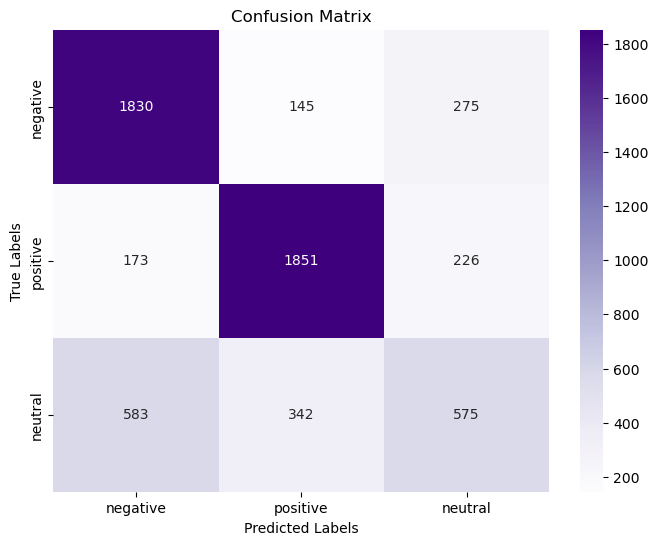

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0925 - accuracy: 0.4043 - val_loss: 1.0861 - val_accuracy: 0.4546
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0797 - accuracy: 0.4842 - val_loss: 1.0722 - val_accuracy: 0.5282
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0644 - accuracy: 0.5466 - val_loss: 1.0555 - val_accuracy: 0.5816
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0466 - accuracy: 0.5839 - val_loss: 1.0364 - val_accuracy: 0.6131
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0270 - accuracy: 0.6102 - val_loss: 1.0156 - val_accuracy: 0.6311
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0058 - accuracy: 0.6238 - val_loss: 0.9936 - val_accuracy: 0.6423
Epoch 7/10
1407/1407 [=========

C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


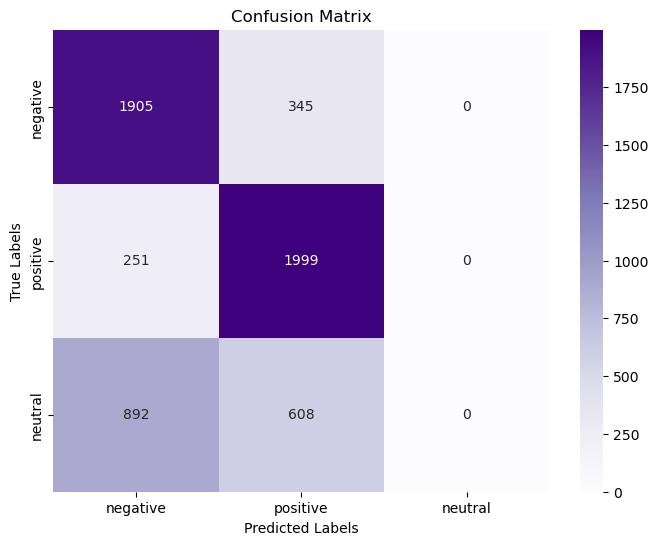

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9896 - accuracy: 0.6023 - val_loss: 0.8479 - val_accuracy: 0.6631
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7755 - accuracy: 0.6734 - val_loss: 0.7105 - val_accuracy: 0.6999
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6954 - accuracy: 0.7020 - val_loss: 0.6615 - val_accuracy: 0.7172
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6626 - accuracy: 0.7141 - val_loss: 0.6373 - val_accuracy: 0.7276
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6441 - accuracy: 0.7231 - val_loss: 0.6216 - val_accuracy: 0.7356
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6315 - accuracy: 0.7283 - val_loss: 0.6108 - val_accuracy: 0.7411
Epoch 7/10
1407/1407 [=========

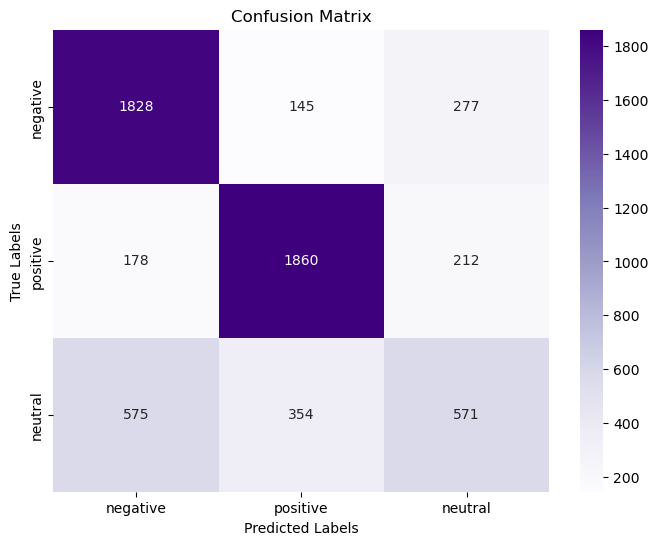

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0911 - accuracy: 0.4400 - val_loss: 1.0832 - val_accuracy: 0.5380
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0755 - accuracy: 0.5519 - val_loss: 1.0663 - val_accuracy: 0.6072
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0570 - accuracy: 0.6052 - val_loss: 1.0461 - val_accuracy: 0.6384
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0353 - accuracy: 0.6282 - val_loss: 1.0226 - val_accuracy: 0.6496
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0107 - accuracy: 0.6404 - val_loss: 0.9969 - val_accuracy: 0.6541
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9850 - accuracy: 0.6468 - val_loss: 0.9704 - val_accuracy: 0.6563
Epoch 7/10
1407/1407 [=========

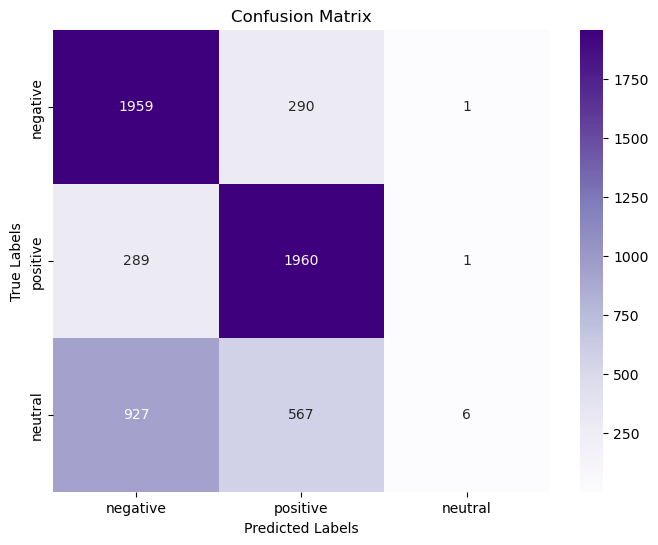

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9264 - accuracy: 0.6002 - val_loss: 0.7194 - val_accuracy: 0.6799
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6983 - accuracy: 0.6888 - val_loss: 0.6478 - val_accuracy: 0.7192
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6533 - accuracy: 0.7153 - val_loss: 0.6178 - val_accuracy: 0.7341
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6317 - accuracy: 0.7281 - val_loss: 0.5995 - val_accuracy: 0.7460
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6173 - accuracy: 0.7356 - val_loss: 0.5871 - val_accuracy: 0.7513
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6051 - accuracy: 0.7427 - val_loss: 0.5791 - val_accuracy: 0.7568
Epoch 7/10
1407/1407 [=========

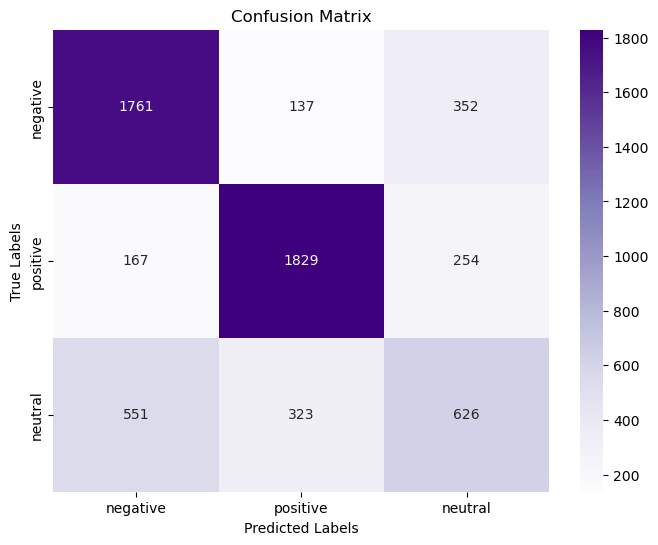

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0900 - accuracy: 0.4355 - val_loss: 1.0829 - val_accuracy: 0.5103
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0751 - accuracy: 0.5163 - val_loss: 1.0658 - val_accuracy: 0.5868
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0554 - accuracy: 0.5743 - val_loss: 1.0419 - val_accuracy: 0.6120
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0266 - accuracy: 0.6049 - val_loss: 1.0068 - val_accuracy: 0.6336
Epoch 5/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.9860 - accuracy: 0.6322 - val_loss: 0.9596 - val_accuracy: 0.6482
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9357 - accuracy: 0.6430 - val_loss: 0.9071 - val_accuracy: 0.6551
Epoch 7/10
1407/1407 [=========

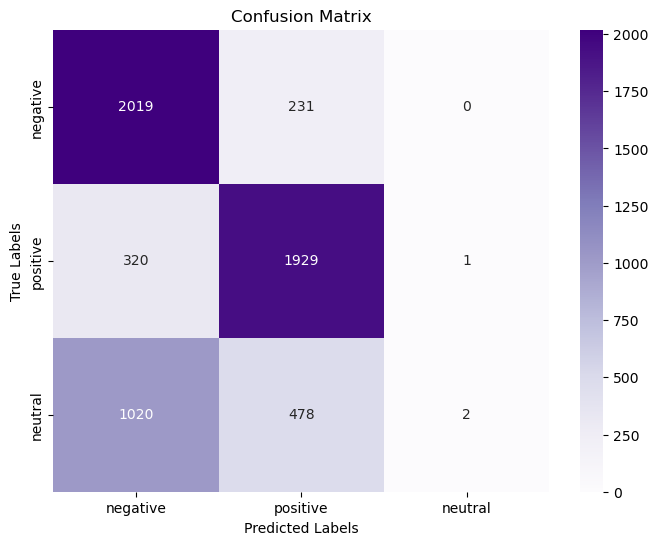

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8862 - accuracy: 0.6106 - val_loss: 0.6865 - val_accuracy: 0.6975
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6740 - accuracy: 0.7033 - val_loss: 0.6241 - val_accuracy: 0.7335
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6351 - accuracy: 0.7261 - val_loss: 0.5986 - val_accuracy: 0.7456
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6155 - accuracy: 0.7345 - val_loss: 0.5833 - val_accuracy: 0.7551
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6018 - accuracy: 0.7438 - val_loss: 0.5713 - val_accuracy: 0.7606
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5916 - accuracy: 0.7499 - val_loss: 0.5638 - val_accuracy: 0.7649
Epoch 7/10
1407/1407 [=========

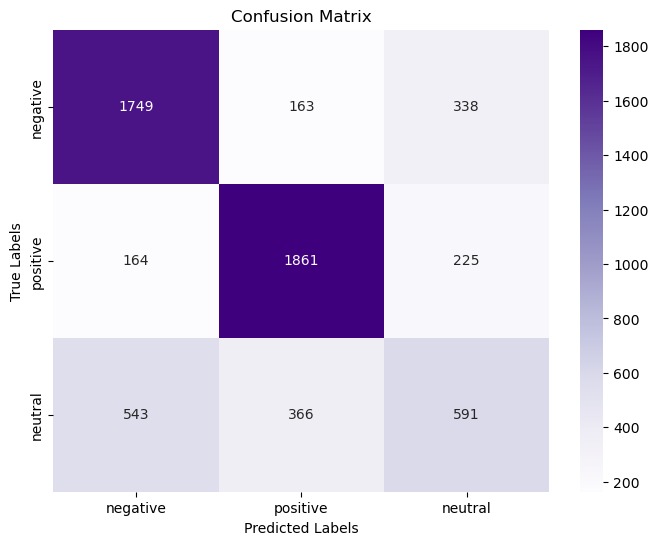

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0938 - accuracy: 0.4133 - val_loss: 1.0867 - val_accuracy: 0.5210
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0781 - accuracy: 0.5358 - val_loss: 1.0669 - val_accuracy: 0.6085
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0505 - accuracy: 0.6046 - val_loss: 1.0281 - val_accuracy: 0.6393
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9984 - accuracy: 0.6381 - val_loss: 0.9622 - val_accuracy: 0.6511
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9268 - accuracy: 0.6499 - val_loss: 0.8870 - val_accuracy: 0.6578
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8577 - accuracy: 0.6552 - val_loss: 0.8231 - val_accuracy: 0.6614
Epoch 7/10
1407/1407 [=========

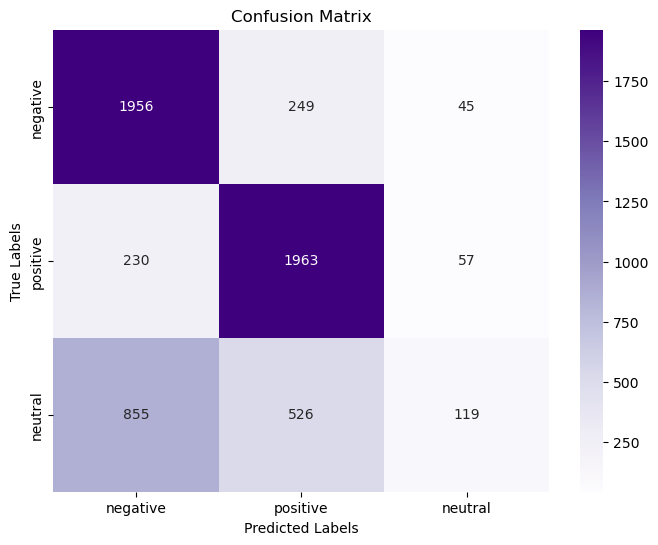

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8879 - accuracy: 0.5964 - val_loss: 0.6787 - val_accuracy: 0.6963
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6760 - accuracy: 0.7012 - val_loss: 0.6185 - val_accuracy: 0.7363
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6349 - accuracy: 0.7249 - val_loss: 0.5906 - val_accuracy: 0.7509
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6137 - accuracy: 0.7393 - val_loss: 0.5722 - val_accuracy: 0.7618
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5954 - accuracy: 0.7496 - val_loss: 0.5578 - val_accuracy: 0.7703
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5826 - accuracy: 0.7568 - val_loss: 0.5426 - val_accuracy: 0.7787
Epoch 7/10
1407/1407 [=========

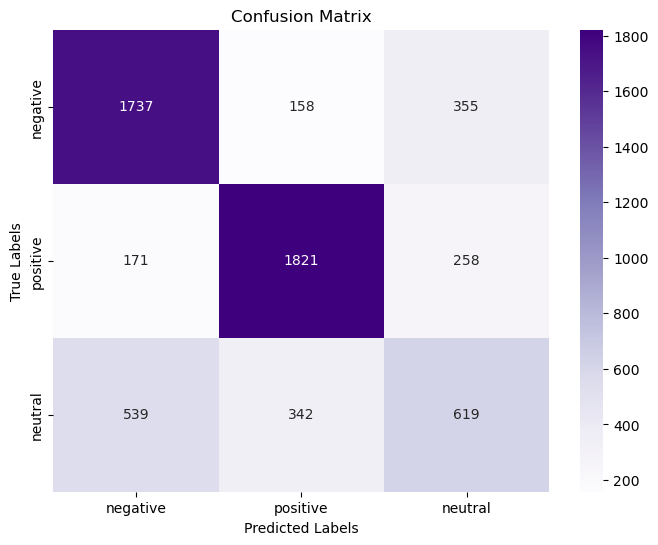

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0935 - accuracy: 0.3976 - val_loss: 1.0876 - val_accuracy: 0.4842
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0797 - accuracy: 0.4861 - val_loss: 1.0688 - val_accuracy: 0.5876
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0503 - accuracy: 0.5825 - val_loss: 1.0240 - val_accuracy: 0.6324
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9884 - accuracy: 0.6330 - val_loss: 0.9423 - val_accuracy: 0.6512
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9014 - accuracy: 0.6471 - val_loss: 0.8523 - val_accuracy: 0.6577
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8250 - accuracy: 0.6572 - val_loss: 0.7863 - val_accuracy: 0.6622
Epoch 7/10
1407/1407 [=========

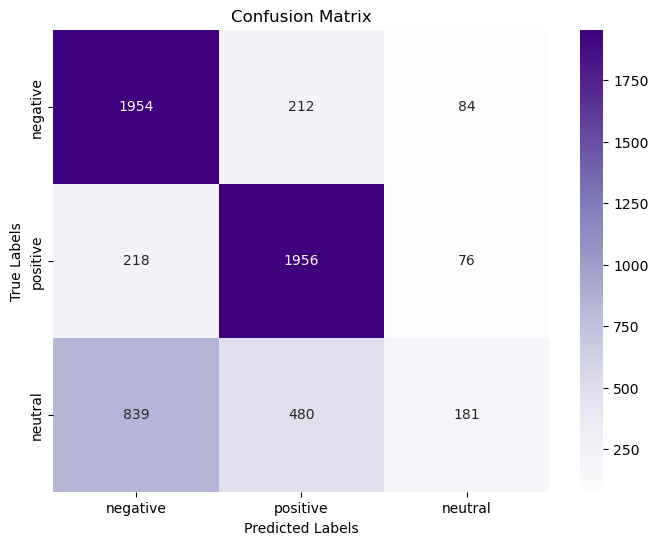

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8526 - accuracy: 0.6142 - val_loss: 0.6612 - val_accuracy: 0.7091
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6592 - accuracy: 0.7128 - val_loss: 0.6022 - val_accuracy: 0.7446
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6183 - accuracy: 0.7355 - val_loss: 0.5727 - val_accuracy: 0.7608
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5950 - accuracy: 0.7482 - val_loss: 0.5521 - val_accuracy: 0.7734
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5736 - accuracy: 0.7609 - val_loss: 0.5267 - val_accuracy: 0.7884
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5518 - accuracy: 0.7731 - val_loss: 0.5020 - val_accuracy: 0.8017
Epoch 7/10
1407/1407 [=========

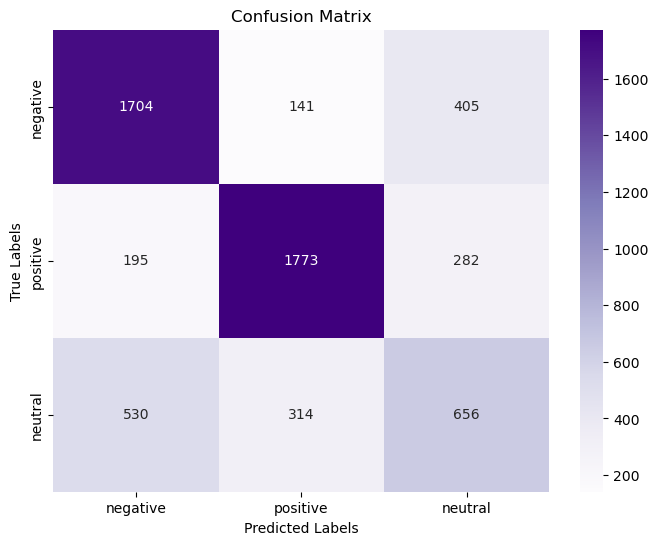

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0915 - accuracy: 0.4043 - val_loss: 1.0830 - val_accuracy: 0.4408
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0723 - accuracy: 0.5012 - val_loss: 1.0565 - val_accuracy: 0.5847
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0270 - accuracy: 0.6062 - val_loss: 0.9823 - val_accuracy: 0.6396
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9262 - accuracy: 0.6421 - val_loss: 0.8624 - val_accuracy: 0.6554
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8210 - accuracy: 0.6562 - val_loss: 0.7756 - val_accuracy: 0.6631
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7588 - accuracy: 0.6631 - val_loss: 0.7303 - val_accuracy: 0.6701
Epoch 7/10
1407/1407 [=========

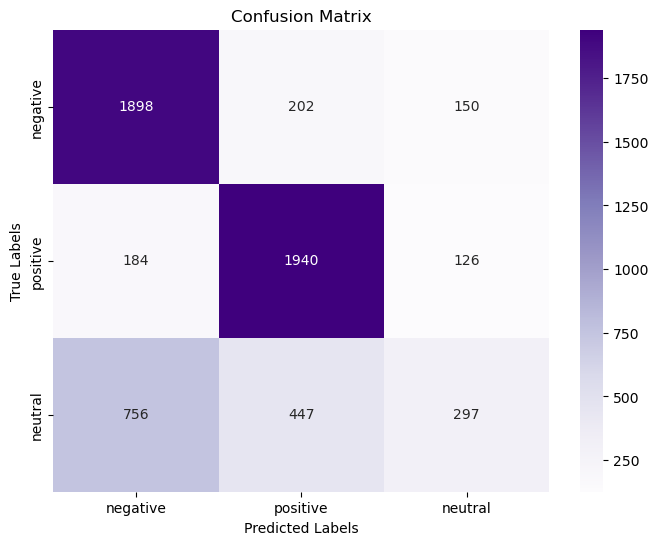

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0065 - accuracy: 0.5784 - val_loss: 0.8854 - val_accuracy: 0.6597
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8122 - accuracy: 0.6619 - val_loss: 0.7432 - val_accuracy: 0.6812
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7229 - accuracy: 0.6892 - val_loss: 0.6846 - val_accuracy: 0.7070
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6828 - accuracy: 0.7065 - val_loss: 0.6544 - val_accuracy: 0.7216
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6600 - accuracy: 0.7159 - val_loss: 0.6361 - val_accuracy: 0.7272
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6445 - accuracy: 0.7234 - val_loss: 0.6231 - val_accuracy: 0.7349
Epoch 7/10
1407/1407 [=========

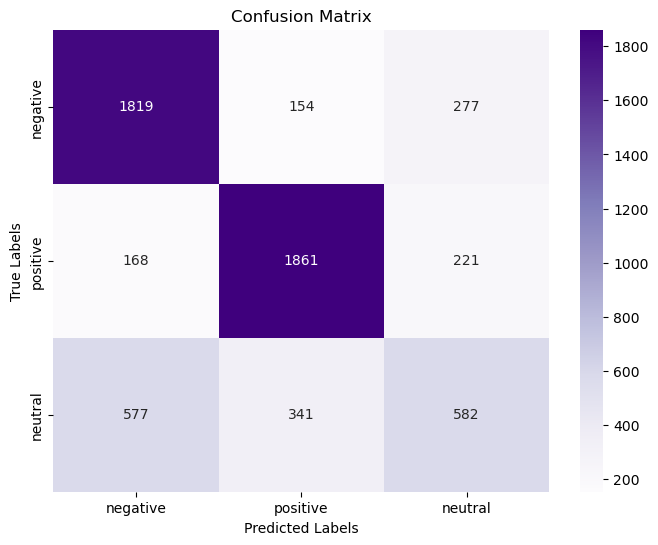

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0911 - accuracy: 0.4188 - val_loss: 1.0846 - val_accuracy: 0.4785
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0778 - accuracy: 0.5054 - val_loss: 1.0698 - val_accuracy: 0.5555
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0618 - accuracy: 0.5600 - val_loss: 1.0522 - val_accuracy: 0.5989
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0431 - accuracy: 0.5953 - val_loss: 1.0326 - val_accuracy: 0.6252
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0237 - accuracy: 0.6165 - val_loss: 1.0122 - val_accuracy: 0.6374
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0027 - accuracy: 0.6311 - val_loss: 0.9911 - val_accuracy: 0.6459
Epoch 7/10
1407/1407 [=========

C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


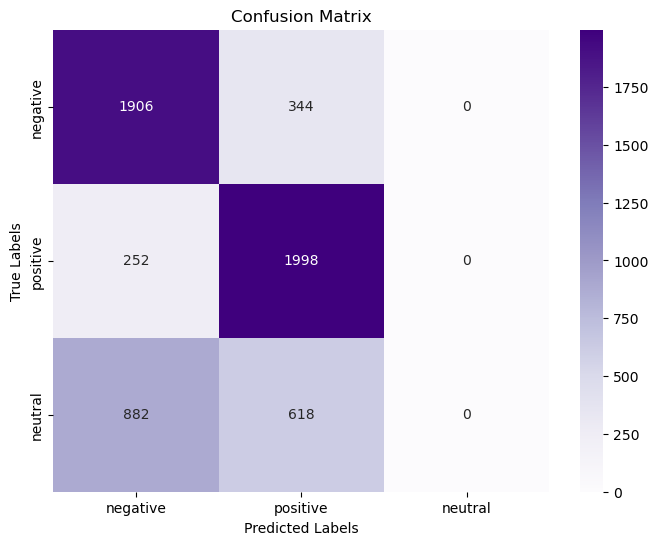

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9902 - accuracy: 0.6035 - val_loss: 0.8466 - val_accuracy: 0.6636
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7751 - accuracy: 0.6732 - val_loss: 0.7093 - val_accuracy: 0.7011
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6943 - accuracy: 0.7008 - val_loss: 0.6613 - val_accuracy: 0.7186
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6620 - accuracy: 0.7152 - val_loss: 0.6370 - val_accuracy: 0.7280
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6436 - accuracy: 0.7228 - val_loss: 0.6218 - val_accuracy: 0.7352
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6298 - accuracy: 0.7292 - val_loss: 0.6110 - val_accuracy: 0.7402
Epoch 7/10
1407/1407 [=========

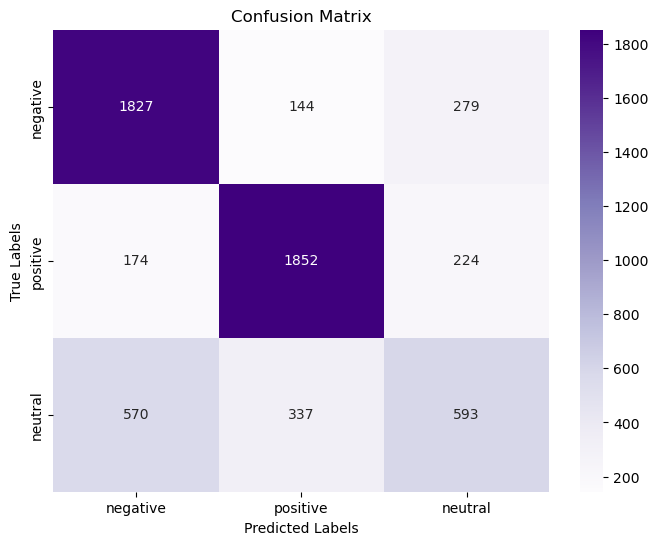

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0934 - accuracy: 0.4179 - val_loss: 1.0858 - val_accuracy: 0.5303
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0782 - accuracy: 0.5434 - val_loss: 1.0696 - val_accuracy: 0.5992
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0608 - accuracy: 0.5933 - val_loss: 1.0503 - val_accuracy: 0.6287
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0398 - accuracy: 0.6211 - val_loss: 1.0277 - val_accuracy: 0.6425
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0162 - accuracy: 0.6346 - val_loss: 1.0026 - val_accuracy: 0.6498
Epoch 6/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.9906 - accuracy: 0.6427 - val_loss: 0.9765 - val_accuracy: 0.6537
Epoch 7/10
1407/1407 [=========

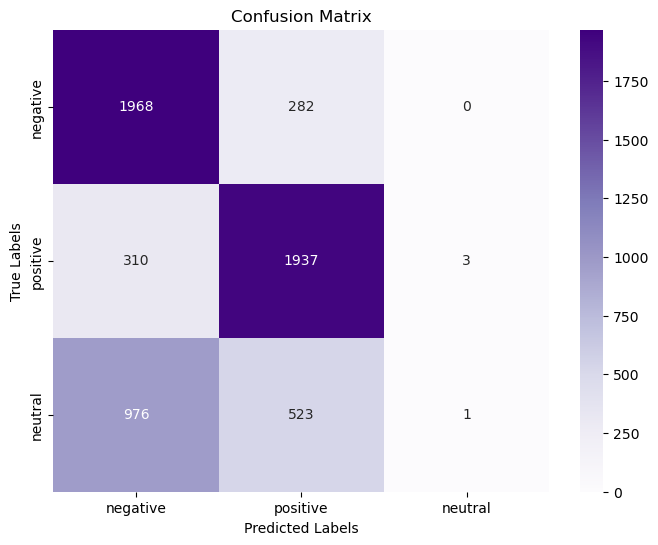

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9530 - accuracy: 0.5751 - val_loss: 0.7278 - val_accuracy: 0.6800
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7012 - accuracy: 0.6932 - val_loss: 0.6464 - val_accuracy: 0.7202
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6540 - accuracy: 0.7157 - val_loss: 0.6171 - val_accuracy: 0.7367
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6333 - accuracy: 0.7275 - val_loss: 0.6011 - val_accuracy: 0.7449
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6201 - accuracy: 0.7360 - val_loss: 0.5896 - val_accuracy: 0.7511
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6105 - accuracy: 0.7422 - val_loss: 0.5813 - val_accuracy: 0.7561
Epoch 7/10
1407/1407 [=========

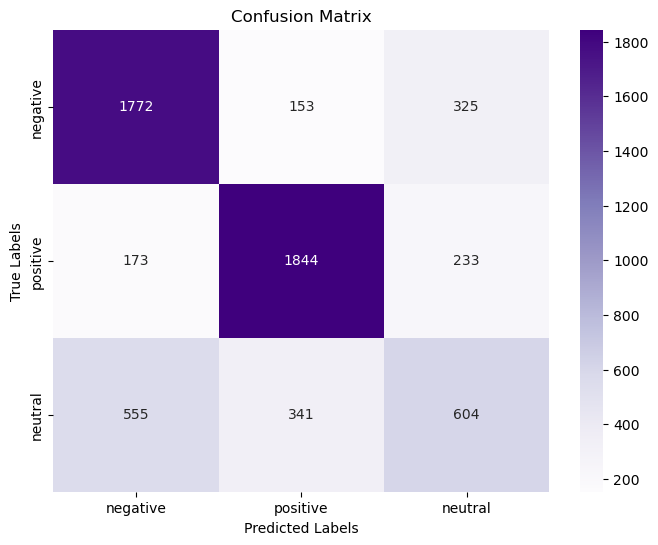

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0924 - accuracy: 0.4014 - val_loss: 1.0870 - val_accuracy: 0.4594
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0816 - accuracy: 0.4686 - val_loss: 1.0753 - val_accuracy: 0.5526
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0679 - accuracy: 0.5378 - val_loss: 1.0582 - val_accuracy: 0.6060
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0466 - accuracy: 0.5932 - val_loss: 1.0303 - val_accuracy: 0.6322
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0119 - accuracy: 0.6243 - val_loss: 0.9882 - val_accuracy: 0.6441
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9650 - accuracy: 0.6402 - val_loss: 0.9371 - val_accuracy: 0.6511
Epoch 7/10
1407/1407 [=========

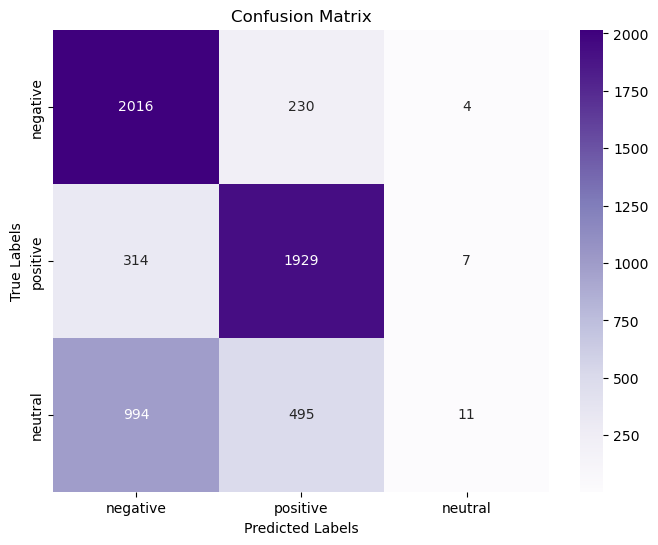

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8927 - accuracy: 0.6113 - val_loss: 0.6858 - val_accuracy: 0.6990
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6731 - accuracy: 0.7035 - val_loss: 0.6238 - val_accuracy: 0.7340
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6350 - accuracy: 0.7268 - val_loss: 0.5987 - val_accuracy: 0.7456
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6157 - accuracy: 0.7358 - val_loss: 0.5833 - val_accuracy: 0.7538
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6040 - accuracy: 0.7424 - val_loss: 0.5732 - val_accuracy: 0.7603
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5934 - accuracy: 0.7491 - val_loss: 0.5628 - val_accuracy: 0.7656
Epoch 7/10
1407/1407 [=========

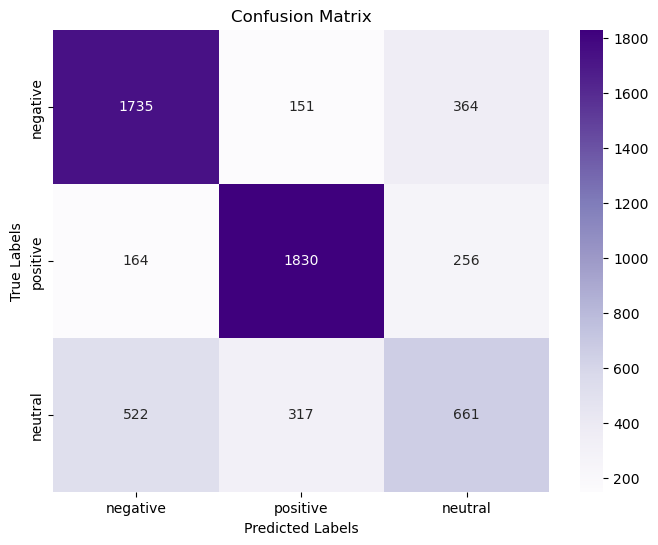

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0927 - accuracy: 0.4300 - val_loss: 1.0854 - val_accuracy: 0.5232
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0762 - accuracy: 0.5342 - val_loss: 1.0649 - val_accuracy: 0.6043
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0500 - accuracy: 0.6005 - val_loss: 1.0301 - val_accuracy: 0.6374
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0056 - accuracy: 0.6349 - val_loss: 0.9751 - val_accuracy: 0.6498
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9445 - accuracy: 0.6478 - val_loss: 0.9083 - val_accuracy: 0.6558
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8791 - accuracy: 0.6533 - val_loss: 0.8448 - val_accuracy: 0.6598
Epoch 7/10
1407/1407 [=========

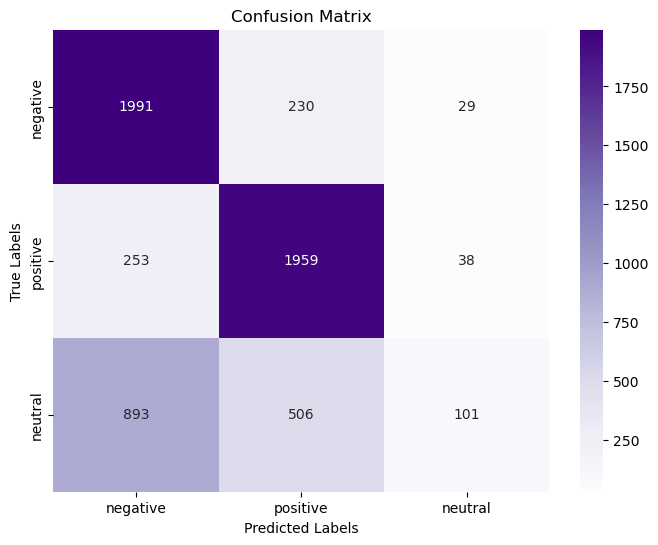

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8796 - accuracy: 0.5944 - val_loss: 0.6859 - val_accuracy: 0.6920
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6902 - accuracy: 0.6916 - val_loss: 0.6375 - val_accuracy: 0.7232
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6489 - accuracy: 0.7193 - val_loss: 0.6051 - val_accuracy: 0.7415
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6221 - accuracy: 0.7358 - val_loss: 0.5818 - val_accuracy: 0.7559
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6048 - accuracy: 0.7444 - val_loss: 0.5648 - val_accuracy: 0.7658
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5891 - accuracy: 0.7530 - val_loss: 0.5502 - val_accuracy: 0.7753
Epoch 7/10
1407/1407 [=========

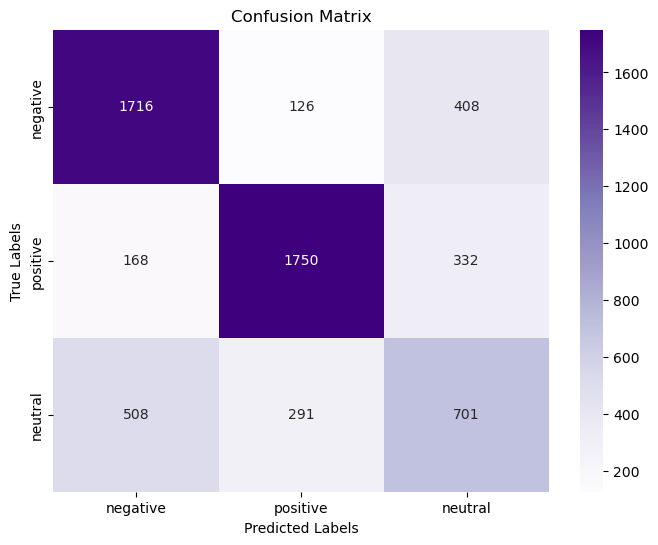

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0918 - accuracy: 0.3902 - val_loss: 1.0846 - val_accuracy: 0.4026
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0772 - accuracy: 0.4426 - val_loss: 1.0677 - val_accuracy: 0.4830
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0544 - accuracy: 0.5351 - val_loss: 1.0352 - val_accuracy: 0.6030
Epoch 4/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0073 - accuracy: 0.6152 - val_loss: 0.9703 - val_accuracy: 0.6423
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9314 - accuracy: 0.6430 - val_loss: 0.8836 - val_accuracy: 0.6565
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8493 - accuracy: 0.6551 - val_loss: 0.8074 - val_accuracy: 0.6620
Epoch 7/10
1407/1407 [=========

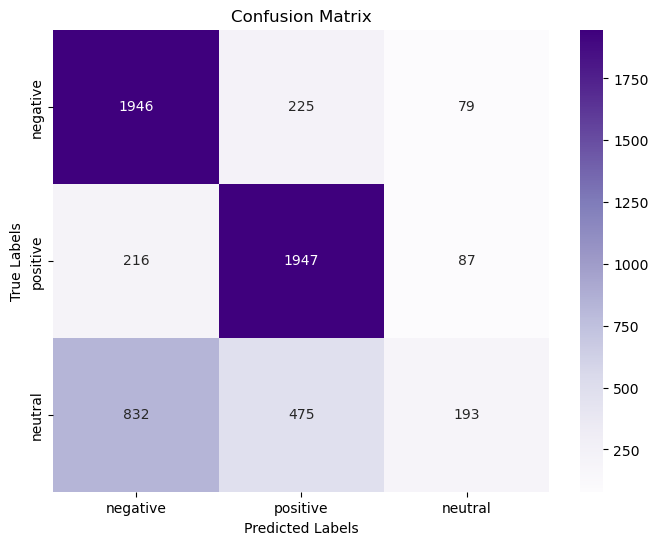

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8361 - accuracy: 0.6209 - val_loss: 0.6623 - val_accuracy: 0.7079
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6635 - accuracy: 0.7085 - val_loss: 0.6082 - val_accuracy: 0.7417
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6241 - accuracy: 0.7322 - val_loss: 0.5767 - val_accuracy: 0.7594
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5990 - accuracy: 0.7469 - val_loss: 0.5539 - val_accuracy: 0.7723
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5787 - accuracy: 0.7580 - val_loss: 0.5335 - val_accuracy: 0.7846
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5594 - accuracy: 0.7671 - val_loss: 0.5143 - val_accuracy: 0.7954
Epoch 7/10
1407/1407 [=========

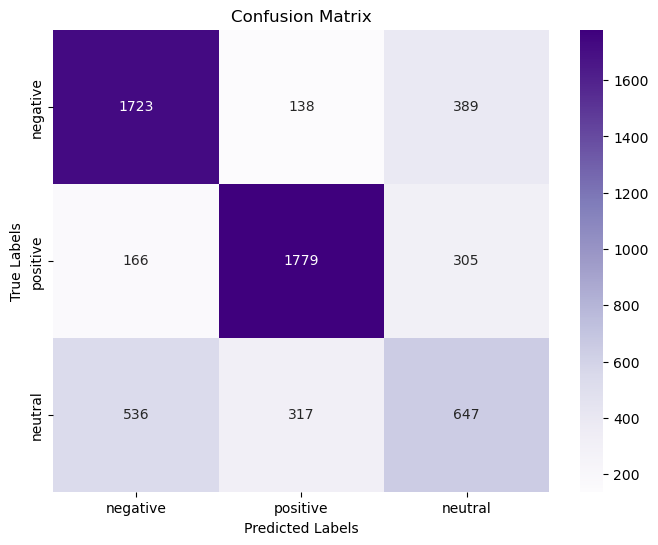

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0928 - accuracy: 0.4187 - val_loss: 1.0843 - val_accuracy: 0.5124
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0715 - accuracy: 0.5269 - val_loss: 1.0531 - val_accuracy: 0.5882
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0198 - accuracy: 0.6088 - val_loss: 0.9718 - val_accuracy: 0.6410
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9147 - accuracy: 0.6437 - val_loss: 0.8518 - val_accuracy: 0.6552
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8131 - accuracy: 0.6554 - val_loss: 0.7711 - val_accuracy: 0.6632
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7554 - accuracy: 0.6648 - val_loss: 0.7283 - val_accuracy: 0.6697
Epoch 7/10
1407/1407 [=========

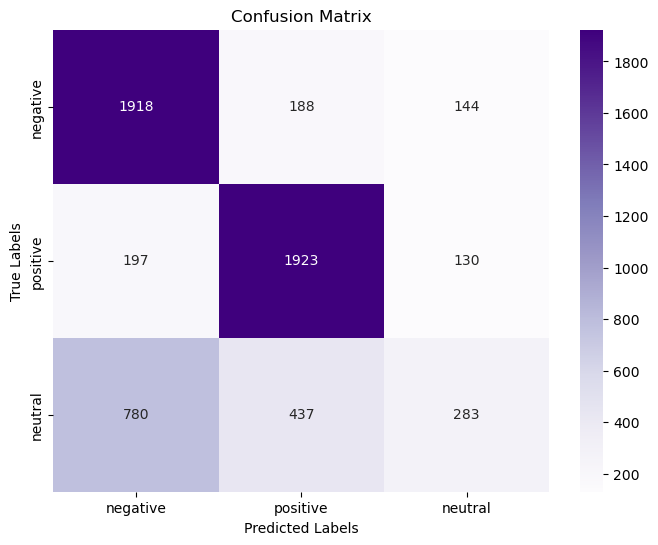

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0168 - accuracy: 0.5818 - val_loss: 0.9035 - val_accuracy: 0.6632
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8262 - accuracy: 0.6670 - val_loss: 0.7516 - val_accuracy: 0.6898
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7285 - accuracy: 0.6944 - val_loss: 0.6879 - val_accuracy: 0.7120
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6861 - accuracy: 0.7079 - val_loss: 0.6556 - val_accuracy: 0.7222
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6609 - accuracy: 0.7204 - val_loss: 0.6356 - val_accuracy: 0.7309
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6444 - accuracy: 0.7260 - val_loss: 0.6216 - val_accuracy: 0.7366
Epoch 7/10
1407/1407 [=========

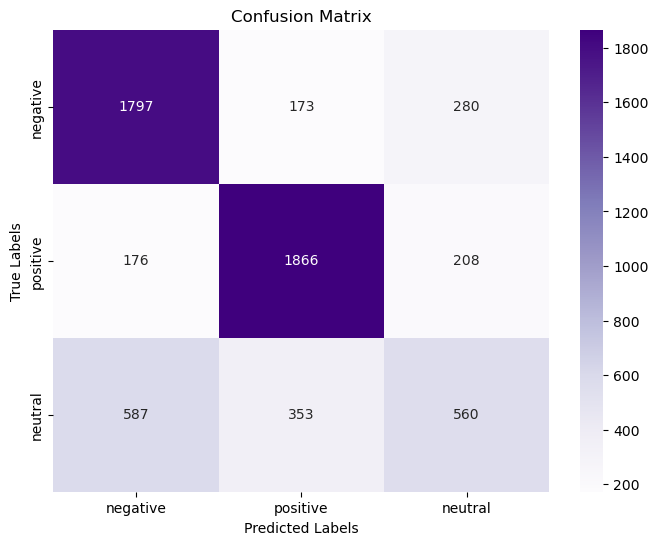

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0911 - accuracy: 0.4291 - val_loss: 1.0843 - val_accuracy: 0.5141
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0769 - accuracy: 0.5330 - val_loss: 1.0682 - val_accuracy: 0.5924
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0595 - accuracy: 0.5845 - val_loss: 1.0494 - val_accuracy: 0.6200
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0401 - accuracy: 0.6119 - val_loss: 1.0293 - val_accuracy: 0.6349
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0201 - accuracy: 0.6260 - val_loss: 1.0087 - val_accuracy: 0.6460
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9995 - accuracy: 0.6381 - val_loss: 0.9880 - val_accuracy: 0.6503
Epoch 7/10
1407/1407 [=========

C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andreea\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


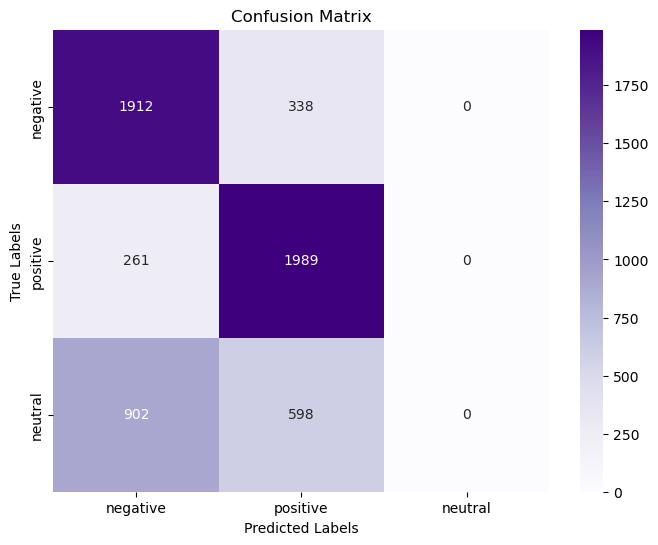

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9857 - accuracy: 0.6113 - val_loss: 0.8461 - val_accuracy: 0.6676
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7778 - accuracy: 0.6756 - val_loss: 0.7123 - val_accuracy: 0.6998
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6978 - accuracy: 0.7018 - val_loss: 0.6628 - val_accuracy: 0.7197
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6640 - accuracy: 0.7166 - val_loss: 0.6368 - val_accuracy: 0.7304
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6425 - accuracy: 0.7255 - val_loss: 0.6198 - val_accuracy: 0.7389
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6281 - accuracy: 0.7331 - val_loss: 0.6075 - val_accuracy: 0.7452
Epoch 7/10
1407/1407 [=========

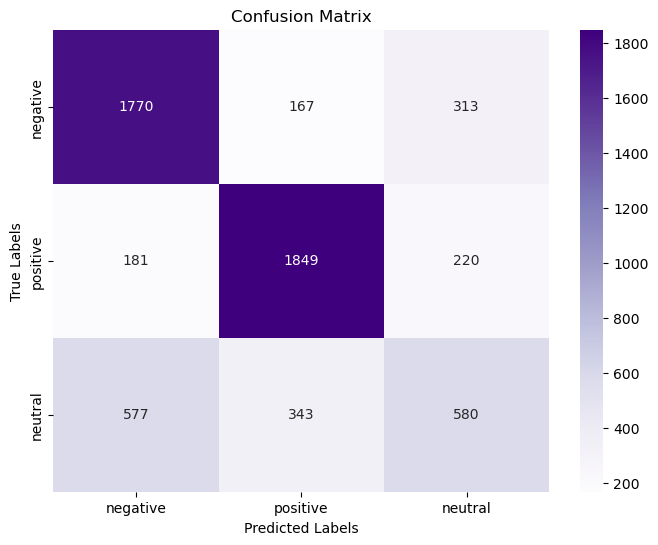

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0930 - accuracy: 0.4048 - val_loss: 1.0856 - val_accuracy: 0.4597
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0780 - accuracy: 0.5166 - val_loss: 1.0689 - val_accuracy: 0.5719
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0596 - accuracy: 0.5901 - val_loss: 1.0486 - val_accuracy: 0.6274
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0378 - accuracy: 0.6274 - val_loss: 1.0251 - val_accuracy: 0.6487
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0135 - accuracy: 0.6428 - val_loss: 0.9997 - val_accuracy: 0.6574
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9880 - accuracy: 0.6497 - val_loss: 0.9736 - val_accuracy: 0.6609
Epoch 7/10
1407/1407 [=========

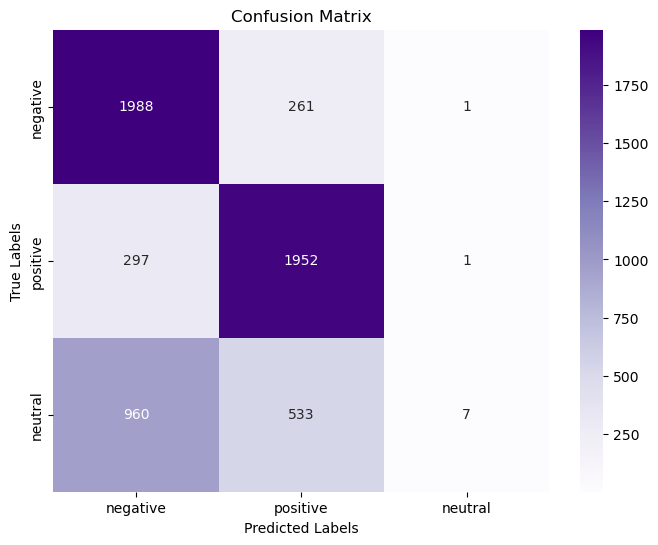

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9211 - accuracy: 0.5994 - val_loss: 0.7150 - val_accuracy: 0.6853
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6950 - accuracy: 0.6949 - val_loss: 0.6446 - val_accuracy: 0.7226
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6501 - accuracy: 0.7197 - val_loss: 0.6102 - val_accuracy: 0.7416
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6248 - accuracy: 0.7327 - val_loss: 0.5909 - val_accuracy: 0.7519
Epoch 5/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6092 - accuracy: 0.7416 - val_loss: 0.5763 - val_accuracy: 0.7591
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5969 - accuracy: 0.7482 - val_loss: 0.5648 - val_accuracy: 0.7666
Epoch 7/10
1407/1407 [=========

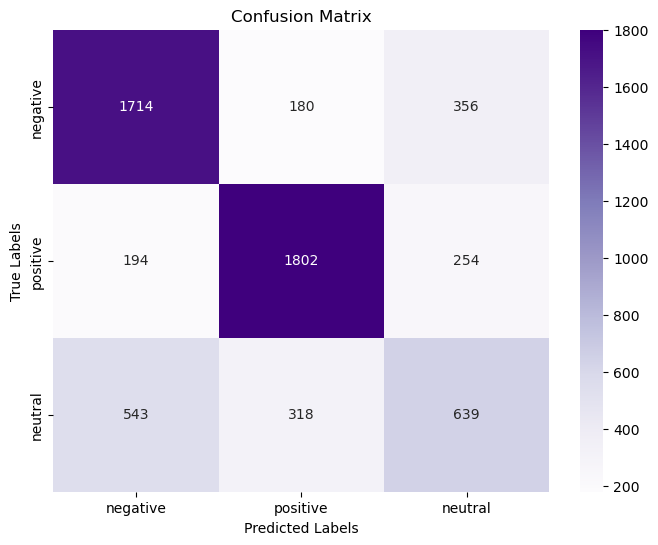

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0959 - accuracy: 0.3713 - val_loss: 1.0909 - val_accuracy: 0.3899
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0841 - accuracy: 0.4015 - val_loss: 1.0753 - val_accuracy: 0.3888
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0642 - accuracy: 0.4218 - val_loss: 1.0501 - val_accuracy: 0.4631
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0330 - accuracy: 0.5224 - val_loss: 1.0117 - val_accuracy: 0.5852
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9895 - accuracy: 0.6080 - val_loss: 0.9625 - val_accuracy: 0.6280
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9381 - accuracy: 0.6379 - val_loss: 0.9086 - val_accuracy: 0.6503
Epoch 7/10
1407/1407 [=========

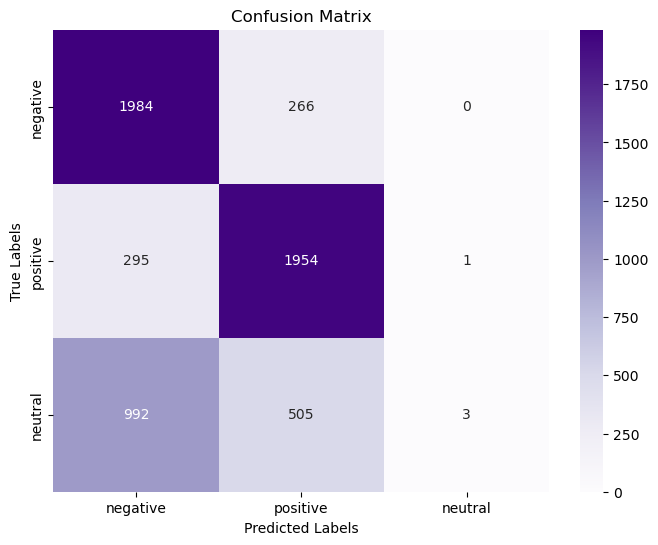

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8791 - accuracy: 0.6173 - val_loss: 0.6823 - val_accuracy: 0.7001
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6717 - accuracy: 0.7069 - val_loss: 0.6195 - val_accuracy: 0.7376
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6304 - accuracy: 0.7290 - val_loss: 0.5912 - val_accuracy: 0.7519
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6083 - accuracy: 0.7417 - val_loss: 0.5728 - val_accuracy: 0.7622
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5932 - accuracy: 0.7493 - val_loss: 0.5570 - val_accuracy: 0.7695
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5793 - accuracy: 0.7584 - val_loss: 0.5433 - val_accuracy: 0.7763
Epoch 7/10
1407/1407 [=========

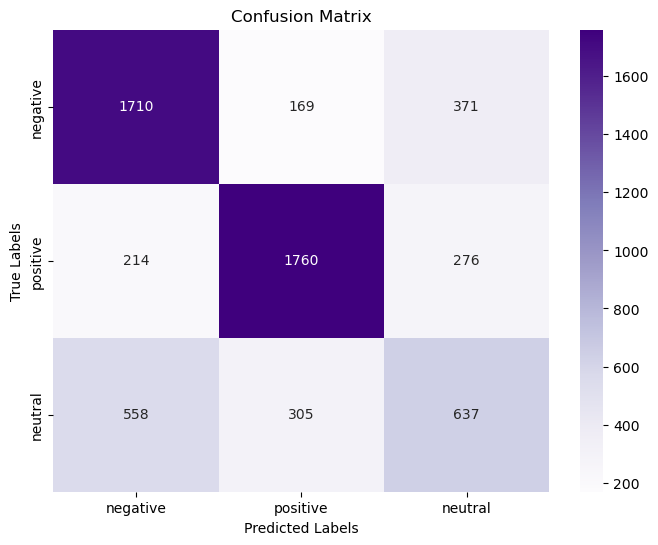

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0918 - accuracy: 0.4043 - val_loss: 1.0840 - val_accuracy: 0.4359
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0738 - accuracy: 0.5021 - val_loss: 1.0602 - val_accuracy: 0.5683
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0411 - accuracy: 0.5941 - val_loss: 1.0167 - val_accuracy: 0.6301
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9877 - accuracy: 0.6382 - val_loss: 0.9521 - val_accuracy: 0.6550
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9187 - accuracy: 0.6535 - val_loss: 0.8804 - val_accuracy: 0.6636
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8526 - accuracy: 0.6606 - val_loss: 0.8194 - val_accuracy: 0.6666
Epoch 7/10
1407/1407 [=========

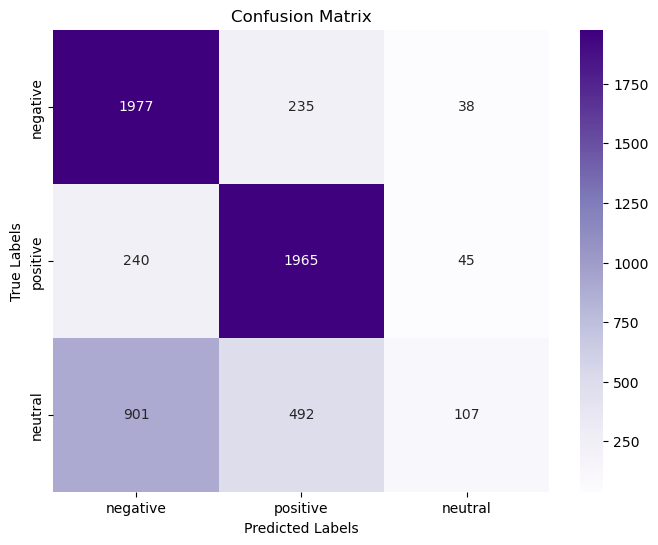

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8660 - accuracy: 0.6104 - val_loss: 0.6852 - val_accuracy: 0.6888
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6860 - accuracy: 0.6954 - val_loss: 0.6285 - val_accuracy: 0.7309
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6401 - accuracy: 0.7264 - val_loss: 0.5899 - val_accuracy: 0.7530
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6106 - accuracy: 0.7402 - val_loss: 0.5656 - val_accuracy: 0.7657
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5918 - accuracy: 0.7525 - val_loss: 0.5482 - val_accuracy: 0.7750
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5743 - accuracy: 0.7604 - val_loss: 0.5299 - val_accuracy: 0.7877
Epoch 7/10
1407/1407 [=========

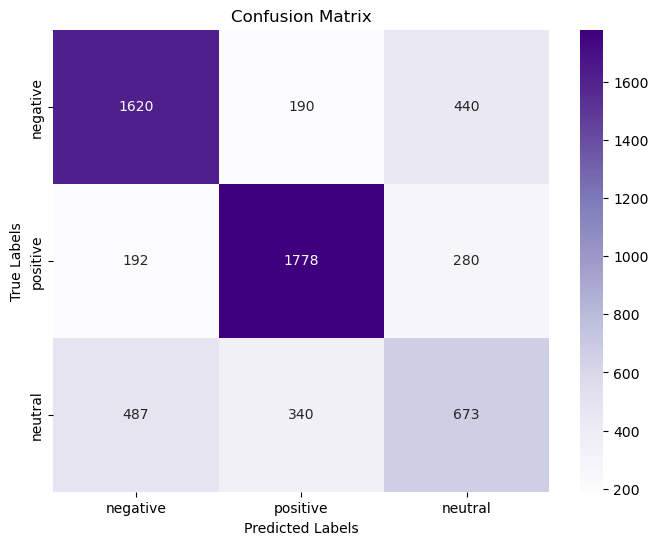

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0913 - accuracy: 0.4125 - val_loss: 1.0837 - val_accuracy: 0.5005
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0745 - accuracy: 0.4980 - val_loss: 1.0623 - val_accuracy: 0.6003
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0433 - accuracy: 0.5882 - val_loss: 1.0147 - val_accuracy: 0.6345
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9775 - accuracy: 0.6342 - val_loss: 0.9303 - val_accuracy: 0.6491
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8897 - accuracy: 0.6488 - val_loss: 0.8428 - val_accuracy: 0.6602
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8171 - accuracy: 0.6583 - val_loss: 0.7802 - val_accuracy: 0.6652
Epoch 7/10
1407/1407 [=========

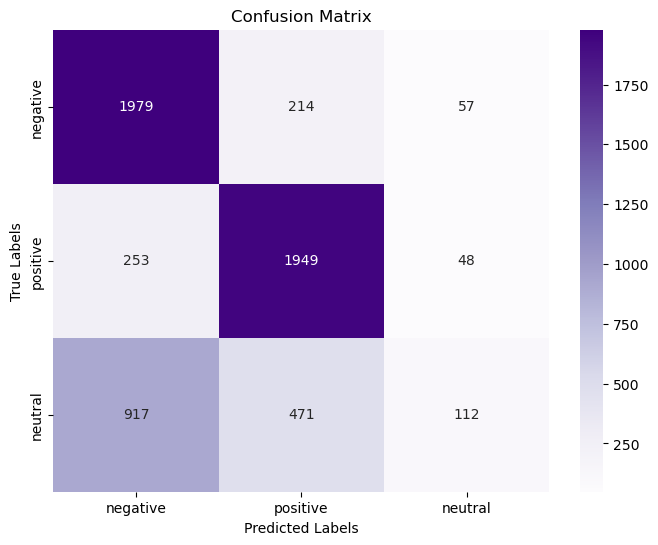

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8351 - accuracy: 0.6254 - val_loss: 0.6609 - val_accuracy: 0.7134
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6617 - accuracy: 0.7136 - val_loss: 0.5999 - val_accuracy: 0.7491
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6168 - accuracy: 0.7375 - val_loss: 0.5657 - val_accuracy: 0.7670
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5896 - accuracy: 0.7524 - val_loss: 0.5414 - val_accuracy: 0.7810
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5638 - accuracy: 0.7656 - val_loss: 0.5120 - val_accuracy: 0.7955
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5389 - accuracy: 0.7766 - val_loss: 0.4847 - val_accuracy: 0.8110
Epoch 7/10
1407/1407 [=========

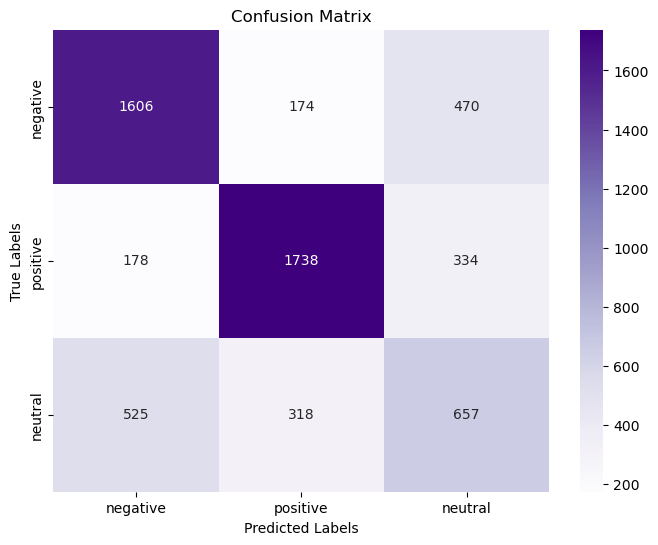

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0903 - accuracy: 0.4256 - val_loss: 1.0807 - val_accuracy: 0.5295
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0658 - accuracy: 0.5384 - val_loss: 1.0434 - val_accuracy: 0.6117
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0011 - accuracy: 0.6276 - val_loss: 0.9431 - val_accuracy: 0.6524
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.8846 - accuracy: 0.6535 - val_loss: 0.8229 - val_accuracy: 0.6618
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7893 - accuracy: 0.6621 - val_loss: 0.7508 - val_accuracy: 0.6676
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7392 - accuracy: 0.6691 - val_loss: 0.7141 - val_accuracy: 0.6754
Epoch 7/10
1407/1407 [=========

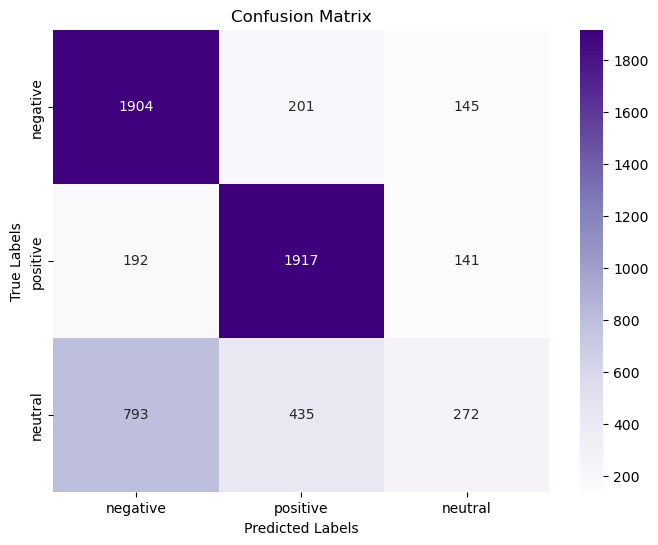

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0107 - accuracy: 0.6013 - val_loss: 0.8872 - val_accuracy: 0.6652
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8093 - accuracy: 0.6705 - val_loss: 0.7328 - val_accuracy: 0.6947
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7114 - accuracy: 0.6998 - val_loss: 0.6688 - val_accuracy: 0.7195
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6664 - accuracy: 0.7176 - val_loss: 0.6352 - val_accuracy: 0.7360
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6410 - accuracy: 0.7280 - val_loss: 0.6136 - val_accuracy: 0.7430
Epoch 6/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.6228 - accuracy: 0.7354 - val_loss: 0.5981 - val_accuracy: 0.7500
Epoch 7/10
1407/1407 [=========

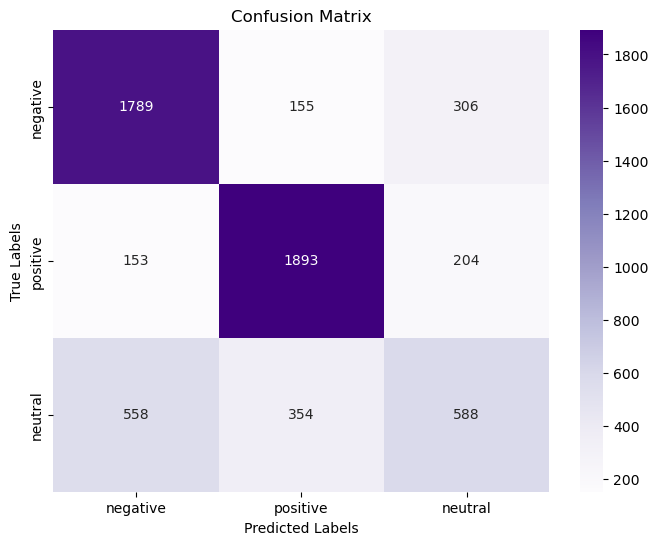

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0927 - accuracy: 0.4316 - val_loss: 1.0864 - val_accuracy: 0.5292
Epoch 2/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0796 - accuracy: 0.5452 - val_loss: 1.0717 - val_accuracy: 0.6093
Epoch 3/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0638 - accuracy: 0.5992 - val_loss: 1.0543 - val_accuracy: 0.6390
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0456 - accuracy: 0.6271 - val_loss: 1.0351 - val_accuracy: 0.6507
Epoch 5/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0260 - accuracy: 0.6379 - val_loss: 1.0149 - val_accuracy: 0.6545
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0056 - accuracy: 0.6454 - val_loss: 0.9940 - val_accuracy: 0.6578
Epoch 7/10
1407/1407 [=========

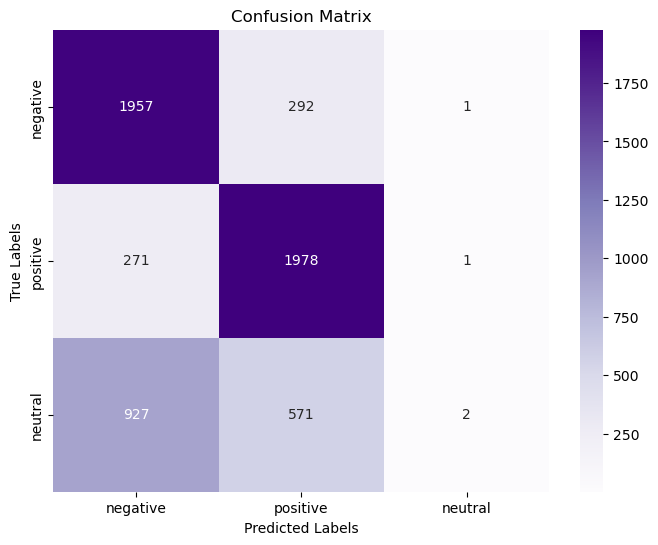

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9835 - accuracy: 0.6124 - val_loss: 0.8376 - val_accuracy: 0.6665
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7663 - accuracy: 0.6774 - val_loss: 0.6981 - val_accuracy: 0.7052
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6822 - accuracy: 0.7087 - val_loss: 0.6449 - val_accuracy: 0.7274
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6443 - accuracy: 0.7252 - val_loss: 0.6161 - val_accuracy: 0.7400
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6225 - accuracy: 0.7346 - val_loss: 0.5971 - val_accuracy: 0.7489
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6066 - accuracy: 0.7397 - val_loss: 0.5829 - val_accuracy: 0.7548
Epoch 7/10
1407/1407 [=========

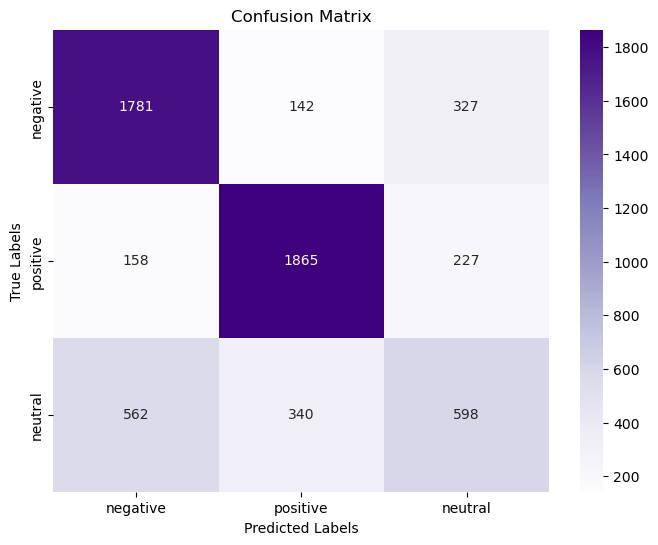

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0892 - accuracy: 0.4590 - val_loss: 1.0809 - val_accuracy: 0.5651
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0718 - accuracy: 0.5728 - val_loss: 1.0610 - val_accuracy: 0.6310
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0498 - accuracy: 0.6218 - val_loss: 1.0371 - val_accuracy: 0.6485
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0252 - accuracy: 0.6388 - val_loss: 1.0114 - val_accuracy: 0.6556
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9989 - accuracy: 0.6484 - val_loss: 0.9849 - val_accuracy: 0.6589
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9728 - accuracy: 0.6529 - val_loss: 0.9583 - val_accuracy: 0.6608
Epoch 7/10
1407/1407 [=========

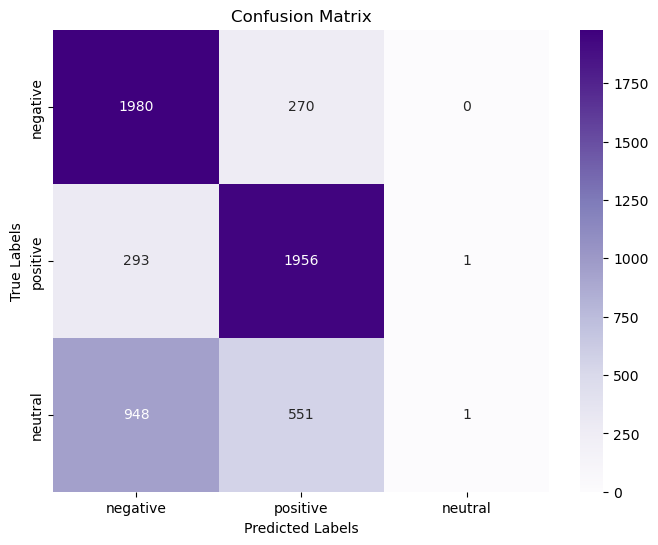

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9417 - accuracy: 0.5922 - val_loss: 0.7163 - val_accuracy: 0.6859
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6820 - accuracy: 0.7026 - val_loss: 0.6165 - val_accuracy: 0.7384
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6258 - accuracy: 0.7335 - val_loss: 0.5819 - val_accuracy: 0.7548
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6003 - accuracy: 0.7450 - val_loss: 0.5590 - val_accuracy: 0.7681
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5802 - accuracy: 0.7561 - val_loss: 0.5431 - val_accuracy: 0.7760
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5686 - accuracy: 0.7626 - val_loss: 0.5309 - val_accuracy: 0.7814
Epoch 7/10
1407/1407 [=========

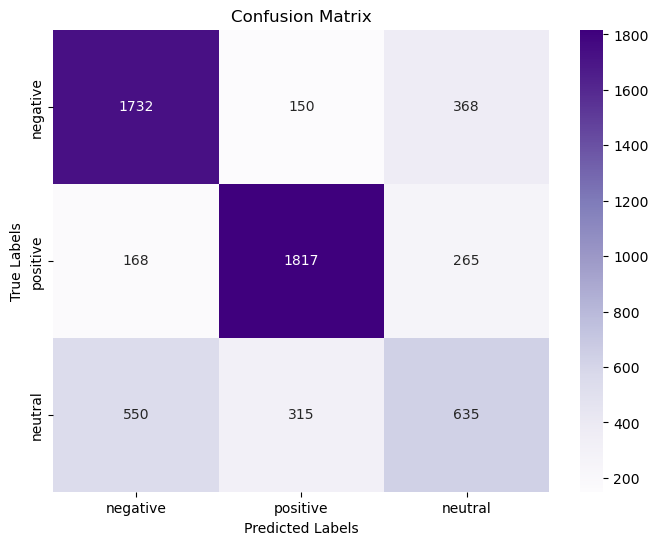

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0929 - accuracy: 0.4107 - val_loss: 1.0866 - val_accuracy: 0.4599
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0794 - accuracy: 0.4791 - val_loss: 1.0707 - val_accuracy: 0.5403
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0602 - accuracy: 0.5564 - val_loss: 1.0466 - val_accuracy: 0.6189
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0306 - accuracy: 0.6128 - val_loss: 1.0092 - val_accuracy: 0.6447
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9861 - accuracy: 0.6394 - val_loss: 0.9578 - val_accuracy: 0.6538
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9326 - accuracy: 0.6497 - val_loss: 0.9014 - val_accuracy: 0.6596
Epoch 7/10
1407/1407 [=========

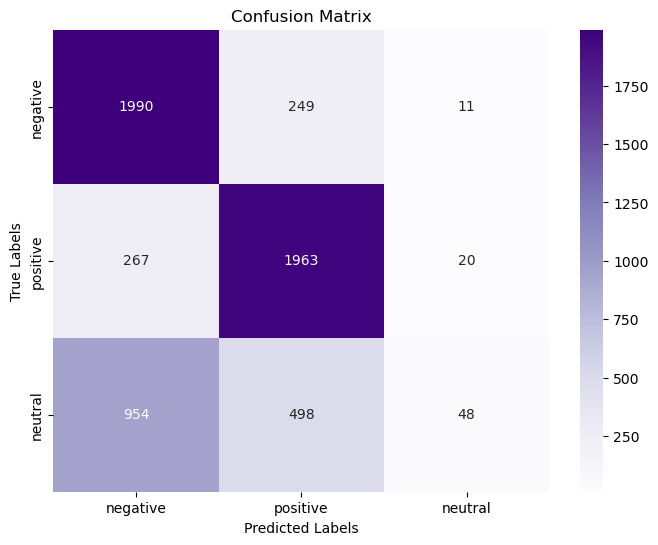

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8809 - accuracy: 0.6076 - val_loss: 0.6731 - val_accuracy: 0.7016
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6587 - accuracy: 0.7133 - val_loss: 0.5980 - val_accuracy: 0.7460
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6103 - accuracy: 0.7390 - val_loss: 0.5642 - val_accuracy: 0.7649
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5852 - accuracy: 0.7516 - val_loss: 0.5426 - val_accuracy: 0.7771
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5652 - accuracy: 0.7637 - val_loss: 0.5246 - val_accuracy: 0.7864
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5514 - accuracy: 0.7699 - val_loss: 0.5100 - val_accuracy: 0.7942
Epoch 7/10
1407/1407 [=========

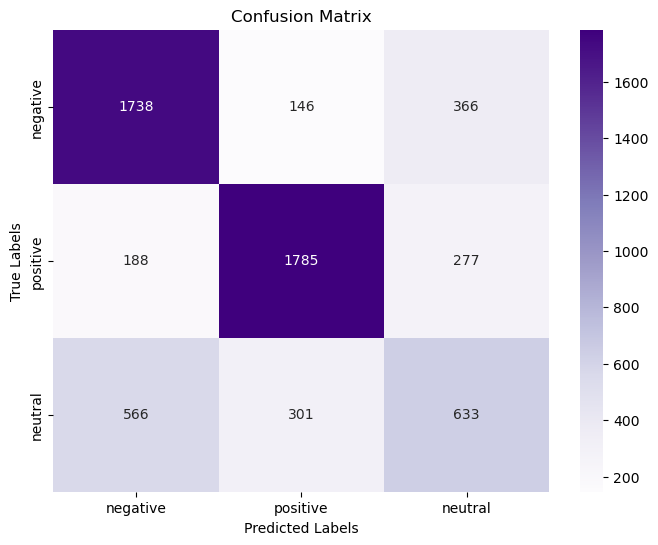

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0914 - accuracy: 0.4331 - val_loss: 1.0821 - val_accuracy: 0.5096
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0705 - accuracy: 0.5372 - val_loss: 1.0551 - val_accuracy: 0.6005
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0341 - accuracy: 0.6095 - val_loss: 1.0072 - val_accuracy: 0.6385
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9767 - accuracy: 0.6389 - val_loss: 0.9405 - val_accuracy: 0.6550
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9083 - accuracy: 0.6521 - val_loss: 0.8705 - val_accuracy: 0.6610
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8439 - accuracy: 0.6605 - val_loss: 0.8108 - val_accuracy: 0.6652
Epoch 7/10
1407/1407 [=========

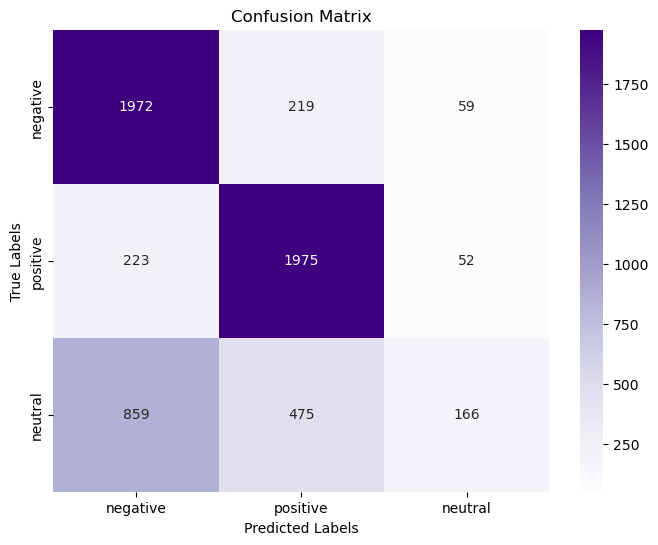

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8783 - accuracy: 0.5865 - val_loss: 0.6676 - val_accuracy: 0.7054
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6662 - accuracy: 0.7081 - val_loss: 0.5983 - val_accuracy: 0.7472
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6151 - accuracy: 0.7393 - val_loss: 0.5602 - val_accuracy: 0.7686
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5855 - accuracy: 0.7534 - val_loss: 0.5349 - val_accuracy: 0.7820
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5638 - accuracy: 0.7665 - val_loss: 0.5131 - val_accuracy: 0.7954
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5430 - accuracy: 0.7776 - val_loss: 0.4942 - val_accuracy: 0.8050
Epoch 7/10
1407/1407 [=========

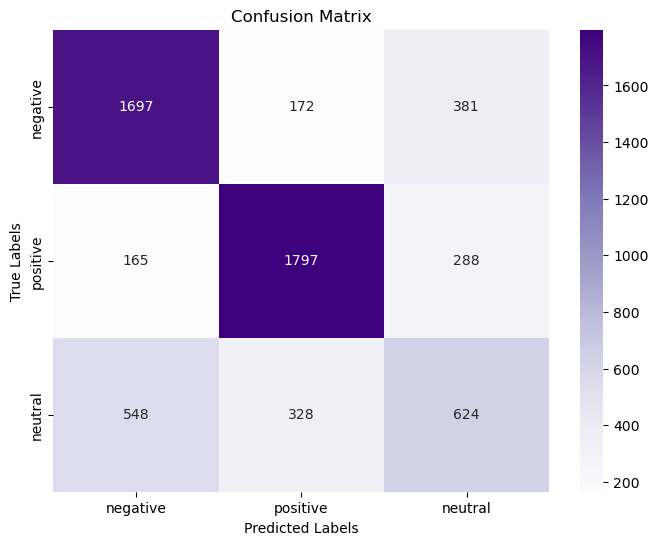

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0932 - accuracy: 0.3968 - val_loss: 1.0869 - val_accuracy: 0.4834
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0801 - accuracy: 0.4568 - val_loss: 1.0726 - val_accuracy: 0.5817
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0632 - accuracy: 0.5396 - val_loss: 1.0494 - val_accuracy: 0.6288
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0267 - accuracy: 0.6158 - val_loss: 0.9949 - val_accuracy: 0.6478
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9585 - accuracy: 0.6442 - val_loss: 0.9128 - val_accuracy: 0.6575
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8753 - accuracy: 0.6551 - val_loss: 0.8298 - val_accuracy: 0.6633
Epoch 7/10
1407/1407 [=========

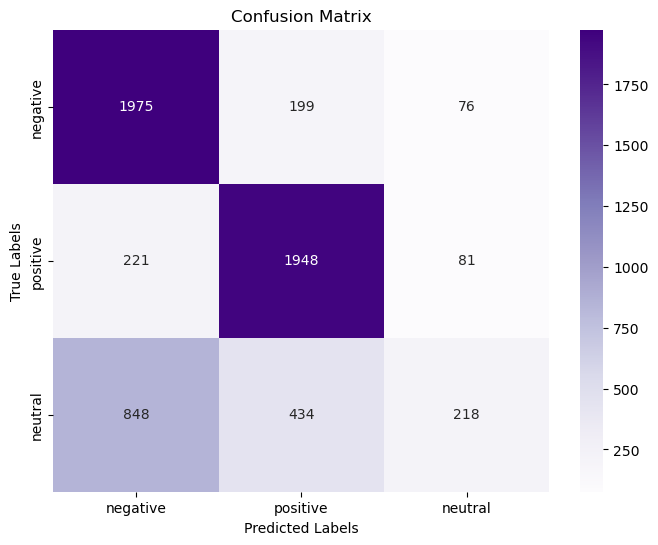

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8258 - accuracy: 0.6315 - val_loss: 0.6393 - val_accuracy: 0.7233
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6408 - accuracy: 0.7207 - val_loss: 0.5682 - val_accuracy: 0.7621
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5895 - accuracy: 0.7513 - val_loss: 0.5311 - val_accuracy: 0.7841
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5572 - accuracy: 0.7667 - val_loss: 0.4957 - val_accuracy: 0.8030
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5260 - accuracy: 0.7859 - val_loss: 0.4624 - val_accuracy: 0.8229
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.4921 - accuracy: 0.8047 - val_loss: 0.4230 - val_accuracy: 0.8431
Epoch 7/10
1407/1407 [=========

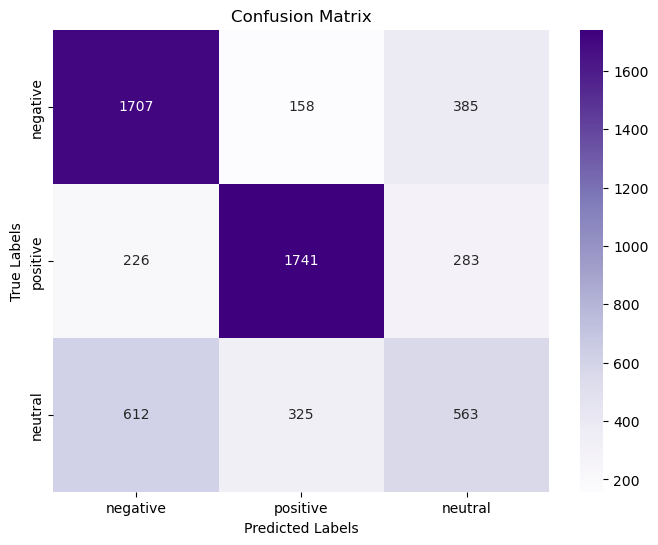

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 10s 6ms/step - loss: 1.0936 - accuracy: 0.3822 - val_loss: 1.0864 - val_accuracy: 0.3810
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0743 - accuracy: 0.4290 - val_loss: 1.0543 - val_accuracy: 0.5310
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0108 - accuracy: 0.5950 - val_loss: 0.9500 - val_accuracy: 0.6478
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.8875 - accuracy: 0.6509 - val_loss: 0.8226 - val_accuracy: 0.6621
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7876 - accuracy: 0.6626 - val_loss: 0.7480 - val_accuracy: 0.6693
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7355 - accuracy: 0.6703 - val_loss: 0.7086 - val_accuracy: 0.6756
Epoch 7/10
1407/1407 [========

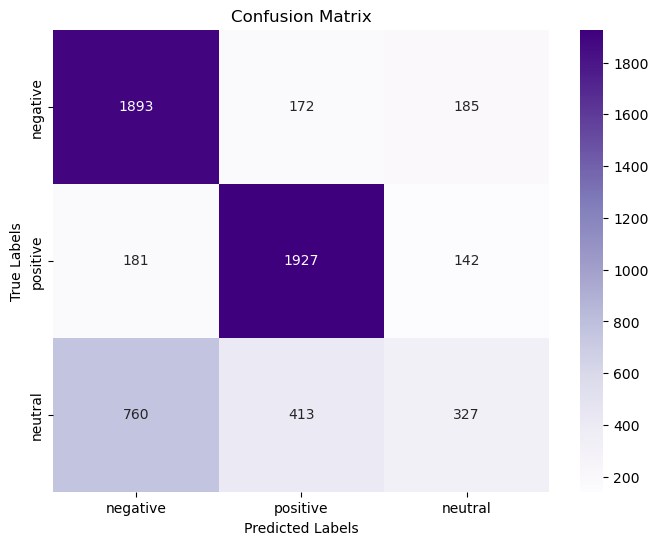

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0065 - accuracy: 0.5904 - val_loss: 0.8833 - val_accuracy: 0.6652
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8069 - accuracy: 0.6708 - val_loss: 0.7313 - val_accuracy: 0.6979
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7097 - accuracy: 0.7008 - val_loss: 0.6678 - val_accuracy: 0.7207
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6660 - accuracy: 0.7174 - val_loss: 0.6339 - val_accuracy: 0.7343
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6394 - accuracy: 0.7278 - val_loss: 0.6121 - val_accuracy: 0.7428
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6219 - accuracy: 0.7352 - val_loss: 0.5964 - val_accuracy: 0.7493
Epoch 7/10
1407/1407 [=========

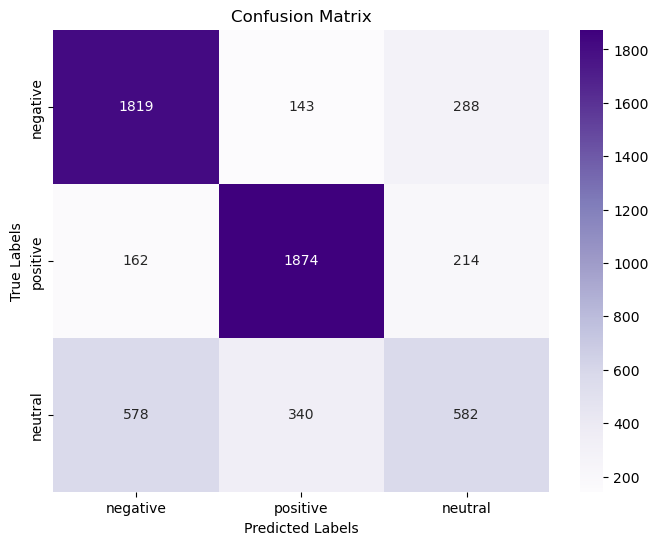

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0934 - accuracy: 0.4194 - val_loss: 1.0866 - val_accuracy: 0.5049
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0799 - accuracy: 0.5276 - val_loss: 1.0718 - val_accuracy: 0.5829
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0640 - accuracy: 0.5795 - val_loss: 1.0547 - val_accuracy: 0.6190
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0460 - accuracy: 0.6086 - val_loss: 1.0361 - val_accuracy: 0.6344
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0271 - accuracy: 0.6272 - val_loss: 1.0167 - val_accuracy: 0.6447
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0081 - accuracy: 0.6352 - val_loss: 0.9968 - val_accuracy: 0.6505
Epoch 7/10
1407/1407 [=========

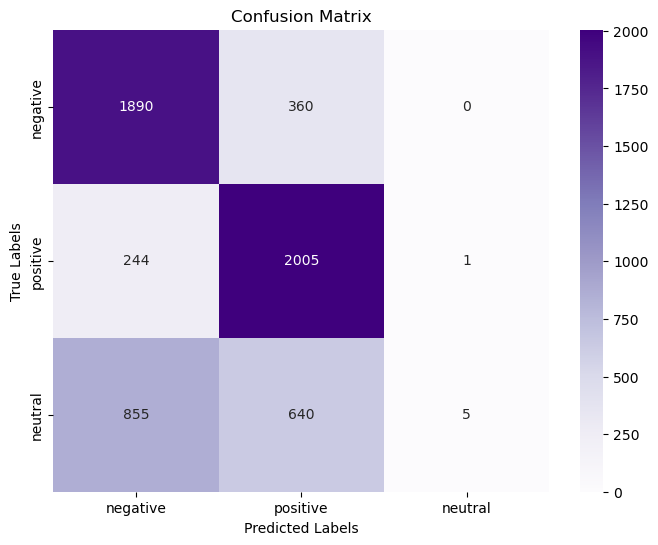

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9863 - accuracy: 0.6084 - val_loss: 0.8399 - val_accuracy: 0.6682
Epoch 2/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7679 - accuracy: 0.6805 - val_loss: 0.6985 - val_accuracy: 0.7051
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6826 - accuracy: 0.7102 - val_loss: 0.6447 - val_accuracy: 0.7271
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6446 - accuracy: 0.7236 - val_loss: 0.6160 - val_accuracy: 0.7403
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6231 - accuracy: 0.7354 - val_loss: 0.5971 - val_accuracy: 0.7491
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.6060 - accuracy: 0.7426 - val_loss: 0.5828 - val_accuracy: 0.7560
Epoch 7/10
1407/1407 [=========

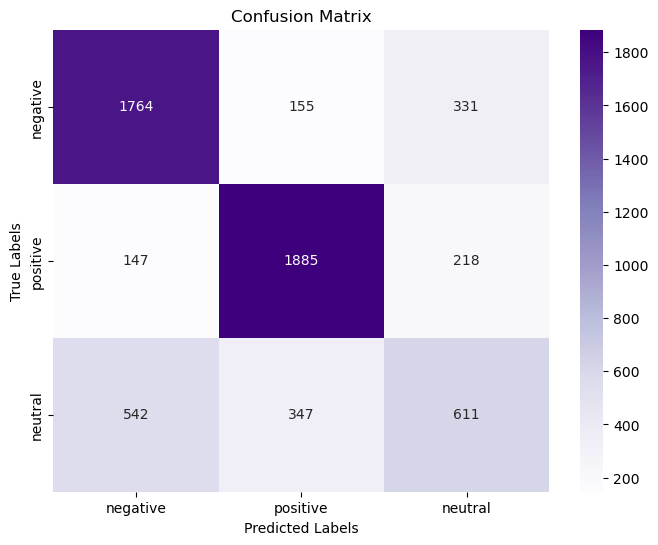

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0933 - accuracy: 0.4267 - val_loss: 1.0856 - val_accuracy: 0.5495
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0778 - accuracy: 0.5657 - val_loss: 1.0688 - val_accuracy: 0.6253
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0596 - accuracy: 0.6169 - val_loss: 1.0490 - val_accuracy: 0.6481
Epoch 4/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0389 - accuracy: 0.6386 - val_loss: 1.0267 - val_accuracy: 0.6563
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0154 - accuracy: 0.6456 - val_loss: 1.0026 - val_accuracy: 0.6600
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9911 - accuracy: 0.6529 - val_loss: 0.9777 - val_accuracy: 0.6616
Epoch 7/10
1407/1407 [=========

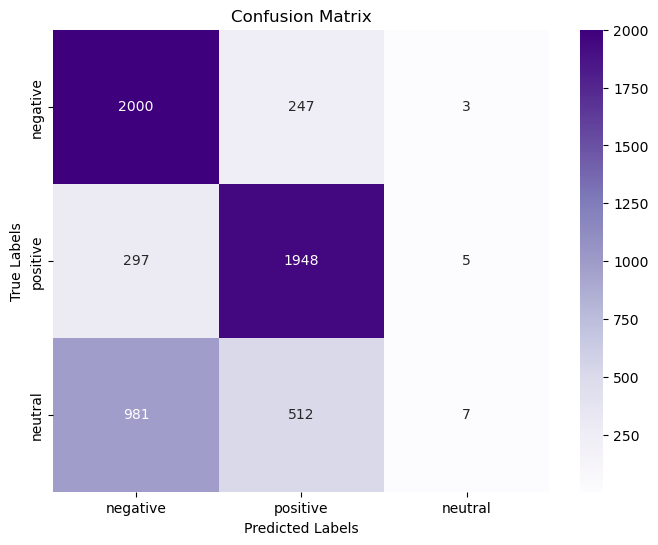

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9091 - accuracy: 0.6078 - val_loss: 0.6997 - val_accuracy: 0.6846
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6796 - accuracy: 0.7016 - val_loss: 0.6198 - val_accuracy: 0.7378
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6285 - accuracy: 0.7297 - val_loss: 0.5847 - val_accuracy: 0.7547
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6022 - accuracy: 0.7428 - val_loss: 0.5626 - val_accuracy: 0.7646
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5850 - accuracy: 0.7530 - val_loss: 0.5469 - val_accuracy: 0.7742
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5714 - accuracy: 0.7605 - val_loss: 0.5349 - val_accuracy: 0.7806
Epoch 7/10
1407/1407 [=========

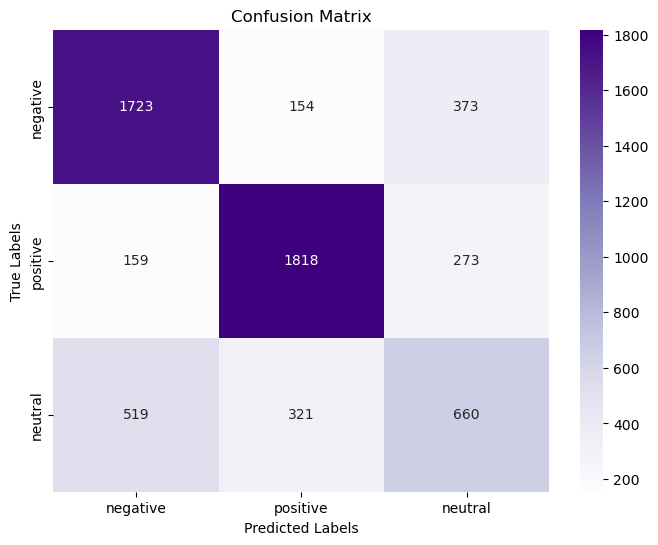

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0935 - accuracy: 0.4212 - val_loss: 1.0873 - val_accuracy: 0.5258
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0800 - accuracy: 0.5127 - val_loss: 1.0710 - val_accuracy: 0.6027
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0599 - accuracy: 0.5822 - val_loss: 1.0455 - val_accuracy: 0.6387
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0276 - accuracy: 0.6238 - val_loss: 1.0051 - val_accuracy: 0.6507
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9816 - accuracy: 0.6432 - val_loss: 0.9526 - val_accuracy: 0.6564
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9273 - accuracy: 0.6522 - val_loss: 0.8967 - val_accuracy: 0.6607
Epoch 7/10
1407/1407 [=========

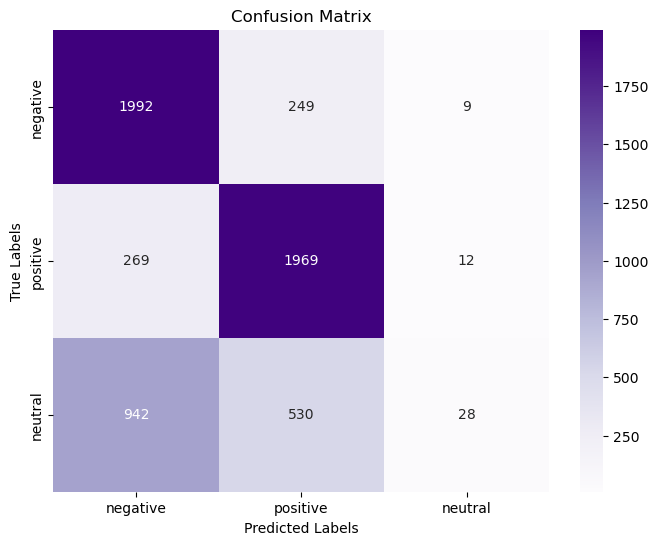

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 5ms/step - loss: 0.8831 - accuracy: 0.6078 - val_loss: 0.6684 - val_accuracy: 0.7084
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6580 - accuracy: 0.7136 - val_loss: 0.6015 - val_accuracy: 0.7452
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6117 - accuracy: 0.7380 - val_loss: 0.5684 - val_accuracy: 0.7585
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5868 - accuracy: 0.7500 - val_loss: 0.5457 - val_accuracy: 0.7738
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5691 - accuracy: 0.7595 - val_loss: 0.5290 - val_accuracy: 0.7827
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5543 - accuracy: 0.7692 - val_loss: 0.5143 - val_accuracy: 0.7921
Epoch 7/10
1407/1407 [=========

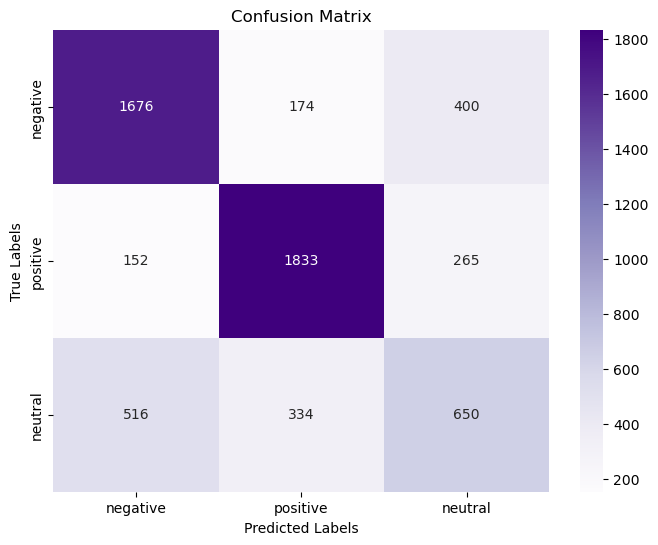

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0903 - accuracy: 0.4327 - val_loss: 1.0817 - val_accuracy: 0.5390
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0711 - accuracy: 0.5374 - val_loss: 1.0566 - val_accuracy: 0.6169
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0365 - accuracy: 0.6164 - val_loss: 1.0096 - val_accuracy: 0.6494
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.9777 - accuracy: 0.6448 - val_loss: 0.9394 - val_accuracy: 0.6592
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9050 - accuracy: 0.6550 - val_loss: 0.8650 - val_accuracy: 0.6639
Epoch 6/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8371 - accuracy: 0.6615 - val_loss: 0.8035 - val_accuracy: 0.6670
Epoch 7/10
1407/1407 [=========

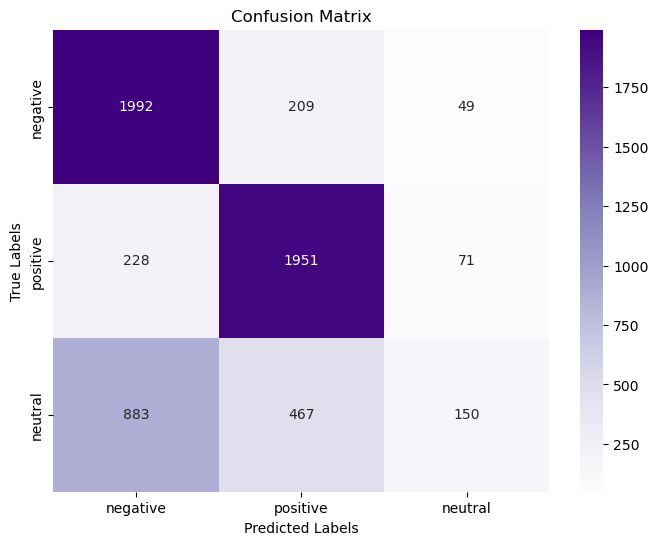

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8573 - accuracy: 0.6215 - val_loss: 0.6585 - val_accuracy: 0.7121
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6594 - accuracy: 0.7104 - val_loss: 0.5927 - val_accuracy: 0.7507
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6119 - accuracy: 0.7390 - val_loss: 0.5576 - val_accuracy: 0.7668
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5843 - accuracy: 0.7542 - val_loss: 0.5328 - val_accuracy: 0.7831
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5635 - accuracy: 0.7664 - val_loss: 0.5116 - val_accuracy: 0.7952
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5439 - accuracy: 0.7763 - val_loss: 0.4935 - val_accuracy: 0.8064
Epoch 7/10
1407/1407 [=========

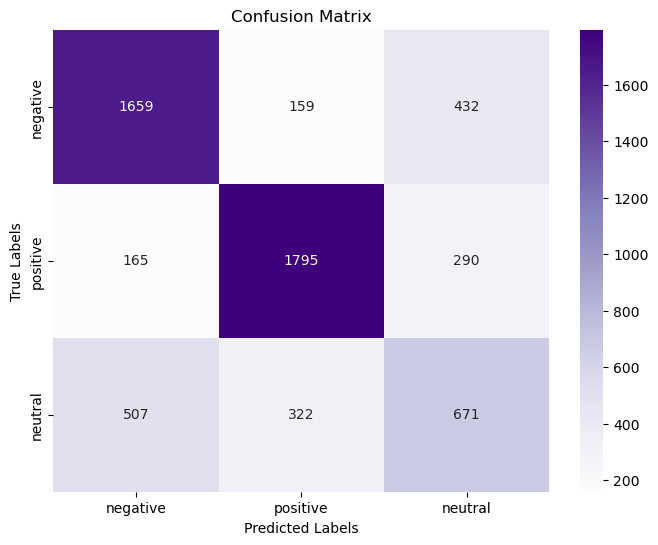

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0918 - accuracy: 0.4270 - val_loss: 1.0840 - val_accuracy: 0.4974
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.0732 - accuracy: 0.5224 - val_loss: 1.0573 - val_accuracy: 0.6105
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.0283 - accuracy: 0.6177 - val_loss: 0.9887 - val_accuracy: 0.6462
Epoch 4/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.9421 - accuracy: 0.6480 - val_loss: 0.8886 - val_accuracy: 0.6577
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.8491 - accuracy: 0.6581 - val_loss: 0.8040 - val_accuracy: 0.6650
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.7833 - accuracy: 0.6648 - val_loss: 0.7503 - val_accuracy: 0.6706
Epoch 7/10
1407/1407 [=========

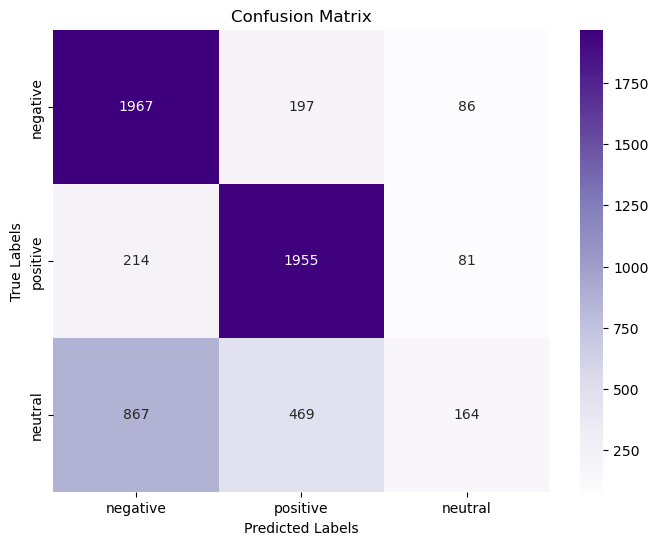

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 0.8242 - accuracy: 0.6315 - val_loss: 0.6498 - val_accuracy: 0.7134
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6487 - accuracy: 0.7166 - val_loss: 0.5816 - val_accuracy: 0.7607
Epoch 3/10
1407/1407 [==============================] - 6s 5ms/step - loss: 0.5976 - accuracy: 0.7460 - val_loss: 0.5376 - val_accuracy: 0.7823
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5626 - accuracy: 0.7649 - val_loss: 0.5035 - val_accuracy: 0.7980
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5324 - accuracy: 0.7813 - val_loss: 0.4692 - val_accuracy: 0.8194
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.4987 - accuracy: 0.8001 - val_loss: 0.4341 - val_accuracy: 0.8368
Epoch 7/10
1407/1407 [=========

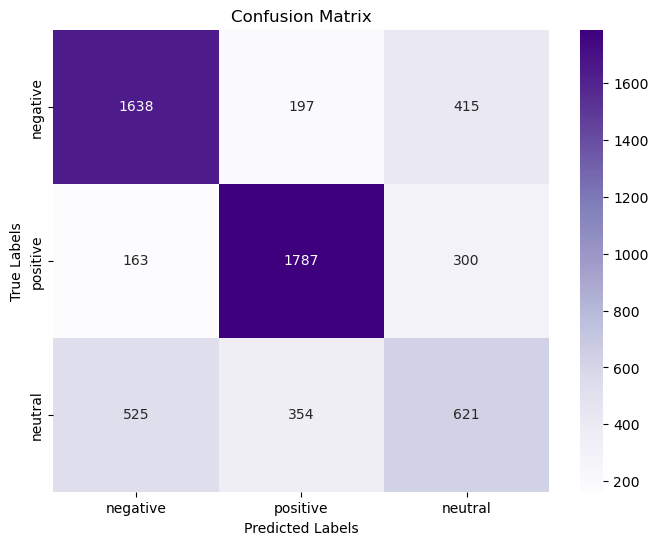

-------------------------------------------------------------------------------------------------------

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0899 - accuracy: 0.4280 - val_loss: 1.0805 - val_accuracy: 0.5599
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0649 - accuracy: 0.5479 - val_loss: 1.0392 - val_accuracy: 0.6374
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9909 - accuracy: 0.6346 - val_loss: 0.9246 - val_accuracy: 0.6567
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8612 - accuracy: 0.6570 - val_loss: 0.7983 - val_accuracy: 0.6655
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7685 - accuracy: 0.6658 - val_loss: 0.7316 - val_accuracy: 0.6719
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7229 - accuracy: 0.6737 - val_loss: 0.6974 - val_accuracy: 0.6823
Epoch 7/10
1407/1407 [=========

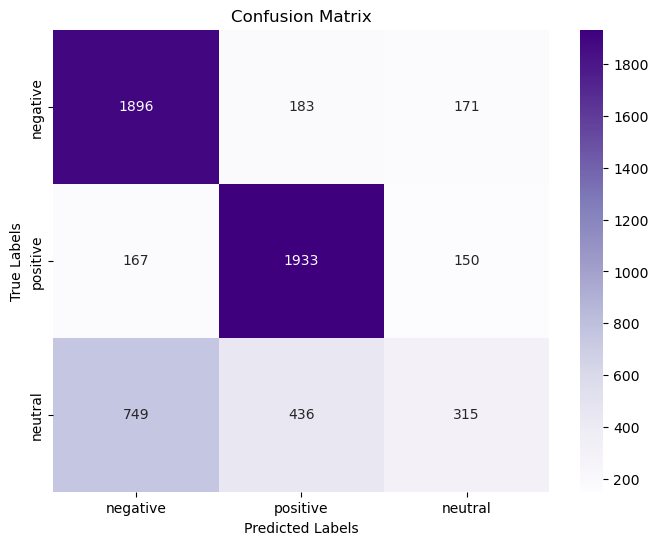

-------------------------------------------------------------------------------------------------------



In [11]:
#codul rulat initial, pe 10 epoci la train
for max_ft in [3000, 5000]:
    for ngram_range in [(1, 1), (1, 2), (1, 3)]: 
        for layers_no in [1, 2, 3]:
            for units_no in [64, 96]:
                for learning_rate in [0.0001, 0.00001]:
                    tfidf_vectorizer = TfidfVectorizer(ngram_range = ngram_range, max_features = max_ft)
                    train_tfidf = tfidf_vectorizer.fit_transform(preprocessed_data_train['text']) 
                    test_tfidf = tfidf_vectorizer.transform(preprocessed_data_test['text'])
                    
                    build_model = [tf.keras.layers.Input(shape = (max_ft,), sparse = True)]
                    for i in range (0, layers_no):
                        build_model.append(tf.keras.layers.Dense(units_no, activation = 'relu'))
                    build_model.append(tf.keras.layers.Dropout(0.3))
                    build_model.append(tf.keras.layers.Dense(3, activation = 'softmax'))
                    model = tf.keras.models.Sequential(build_model)
                    optimizer = Adam(learning_rate = learning_rate)  
                    model.compile(optimizer = optimizer,
                         loss = 'sparse_categorical_crossentropy',
                         metrics = ['accuracy'])
                    train_tfidf_sorted = sort_sparse_indices(train_tfidf)

                    model.fit(sort_sparse_indices(train_tfidf), np.array(list_labels),
                        epochs = 10, batch_size = 32, initial_epoch = 0, 
                        validation_data=(sort_sparse_indices(train_tfidf), np.array(list_labels))) 
                    test_loss, test_metrics = model.evaluate(sort_sparse_indices(test_tfidf), np.array(list_test), verbose = 0) 
                    print('\n ngram_range -', ngram_range, 'max_ft -', max_ft, 'layers_no -',layers_no, 'units_no -',units_no, 'learning_rate -',learning_rate, '- LOSS -', test_loss, ' ACCURACY -', test_metrics)
                    
                    test_predictions = model.predict(sort_sparse_indices(test_tfidf))
                    predicted_labels = np.argmax(test_predictions, axis = 1)
                    
                    print(classification_report(np.array(list_test), predicted_labels))
                    conf_matrix = confusion_matrix(np.array(list_test), predicted_labels)
                    
                    plt.figure(figsize = (8, 6))
                    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Purples", xticklabels = ['negative', 'positive', 'neutral'], yticklabels = ['negative', 'positive', 'neutral'])
                    plt.xlabel('Predicted Labels')
                    plt.ylabel('True Labels')
                    plt.title('Confusion Matrix')
                    plt.show()
                    print("-------------------------------------------------------------------------------------------------------\n")

Epoch 1/10
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0060 - accuracy: 0.6065 - val_loss: 0.8764 - val_accuracy: 0.6742
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7977 - accuracy: 0.6700 - val_loss: 0.7349 - val_accuracy: 0.6909
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7044 - accuracy: 0.6960 - val_loss: 0.6852 - val_accuracy: 0.7046
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6611 - accuracy: 0.7155 - val_loss: 0.6633 - val_accuracy: 0.7117
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6356 - accuracy: 0.7269 - val_loss: 0.6525 - val_accuracy: 0.7135
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6193 - accuracy: 0.7354 - val_loss: 0.6476 - val_accuracy: 0.7171
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6057 - accuracy: 0.7425 - val_loss: 0.6447 - val_accuracy:

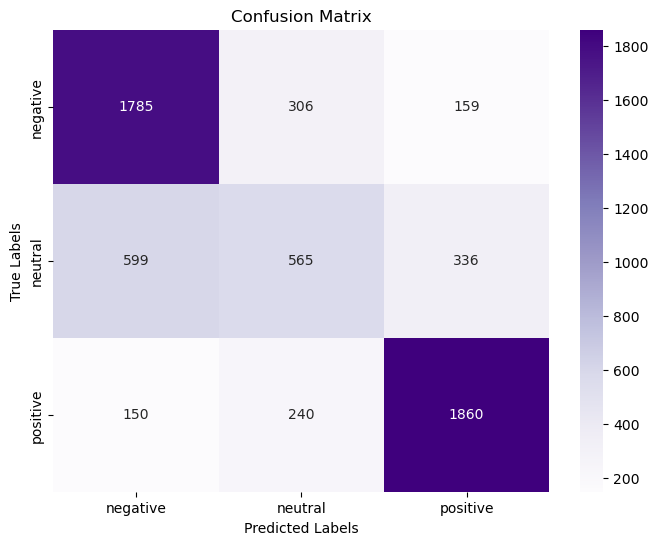

In [13]:
#fix matrice de confuzie pt cel mai bun scor - label neutru in mijloc
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), max_features = 5000)
train_tfidf = tfidf_vectorizer.fit_transform(preprocessed_data_train['text']) 
test_tfidf = tfidf_vectorizer.transform(preprocessed_data_test['text'])
val_tfidf = tfidf_vectorizer.transform(preprocessed_data_validation['text'])

build_model = [tf.keras.layers.Input(shape = (5000,), sparse = True)]
build_model.append(tf.keras.layers.Dense(64, activation = 'relu'))
build_model.append(tf.keras.layers.Dropout(0.3))
build_model.append(tf.keras.layers.Dense(3, activation = 'softmax'))
model = tf.keras.models.Sequential(build_model)
optimizer = Adam(learning_rate = 0.0001)  
model.compile(optimizer = optimizer,
     loss = 'sparse_categorical_crossentropy',
     metrics = ['accuracy'])
train_tfidf_sorted = sort_sparse_indices(train_tfidf)
model.fit(sort_sparse_indices(train_tfidf), np.array(list_labels),
    epochs = 10, batch_size = 32, initial_epoch = 0, 
    validation_data=(sort_sparse_indices(val_tfidf), np.array(list_val))) 
test_loss, test_metrics = model.evaluate(sort_sparse_indices(test_tfidf), np.array(list_test), verbose = 0) 
#print('\n ngram_range -', ngram_range, 'max_ft -', max_ft, 'layers_no -',layers_no, 'units_no -',units_no, 'learning_rate -',learning_rate, '- LOSS -', test_loss, ' ACCURACY -', test_metrics)

test_predictions = model.predict(sort_sparse_indices(test_tfidf))
predicted_labels = np.argmax(test_predictions, axis = 1)

print(classification_report(np.array(list_test), predicted_labels))
conf_matrix = confusion_matrix(np.array(list_test), predicted_labels)

plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Purples", xticklabels = ['negative', 'neutral', 'positive'], yticklabels = ['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

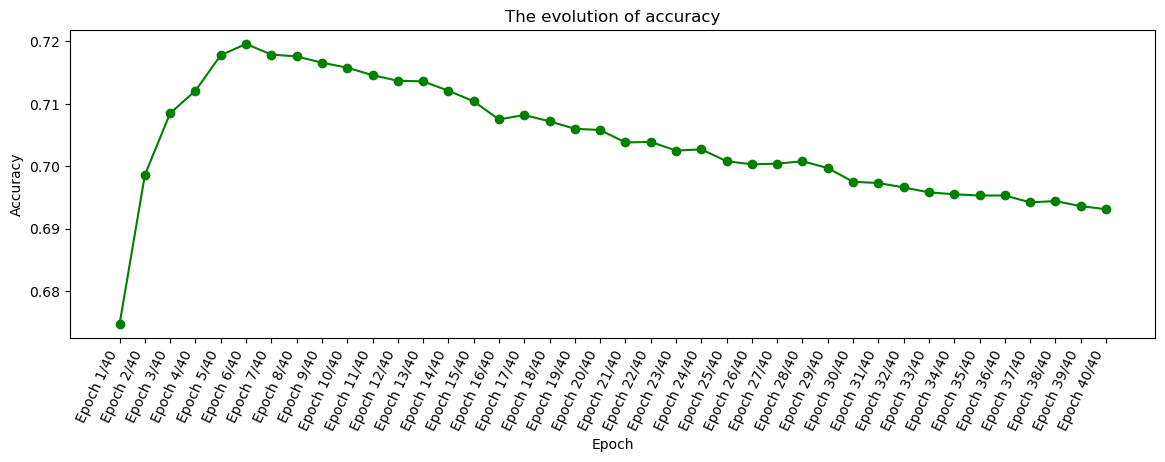

In [10]:
#plot the evolution of validation accuracy on training stage
values = [0.6747, 0.6986, 0.7085, 0.7121, 0.7178, 0.7196, 0.7179, 0.7176, 0.7166, 0.7158, 0.7146, 0.7137, 0.7136, 0.7121, 0.7104, 0.7075, 0.7082, 0.7072, 0.7060, 0.7058, 0.7038, 0.7039, 0.7025, 0.7027, 0.7008, 0.7003, 0.7004, 0.7008, 0.6997, 0.6975, 0.6973, 0.6966, 0.6958, 0.6955, 0.6953, 0.6953, 0.6942, 0.6944, 0.6936, 0.6931]
epoch = ['Epoch 1/40', 'Epoch 2/40', 'Epoch 3/40', 'Epoch 4/40', 'Epoch 5/40', 'Epoch 6/40', 'Epoch 7/40', 'Epoch 8/40', 'Epoch 9/40', 'Epoch 10/40', 'Epoch 11/40', 'Epoch 12/40', 'Epoch 13/40', 'Epoch 14/40', 'Epoch 15/40', 'Epoch 16/40', 'Epoch 17/40', 'Epoch 18/40', 'Epoch 19/40', 'Epoch 20/40', 'Epoch 21/40', 'Epoch 22/40', 'Epoch 23/40', 'Epoch 24/40', 'Epoch 25/40', 'Epoch 26/40', 'Epoch 27/40', 'Epoch 28/40', 'Epoch 29/40', 'Epoch 30/40', 'Epoch 31/40', 'Epoch 32/40', 'Epoch 33/40', 'Epoch 34/40', 'Epoch 35/40', 'Epoch 36/40', 'Epoch 37/40', 'Epoch 38/40', 'Epoch 39/40', 'Epoch 40/40']
plt.figure(figsize = (14, 4))
plt.plot(epoch, values, marker = 'o', linestyle = '-', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('The evolution of accuracy')
plt.xticks(rotation=65, ha='right')
plt.show()

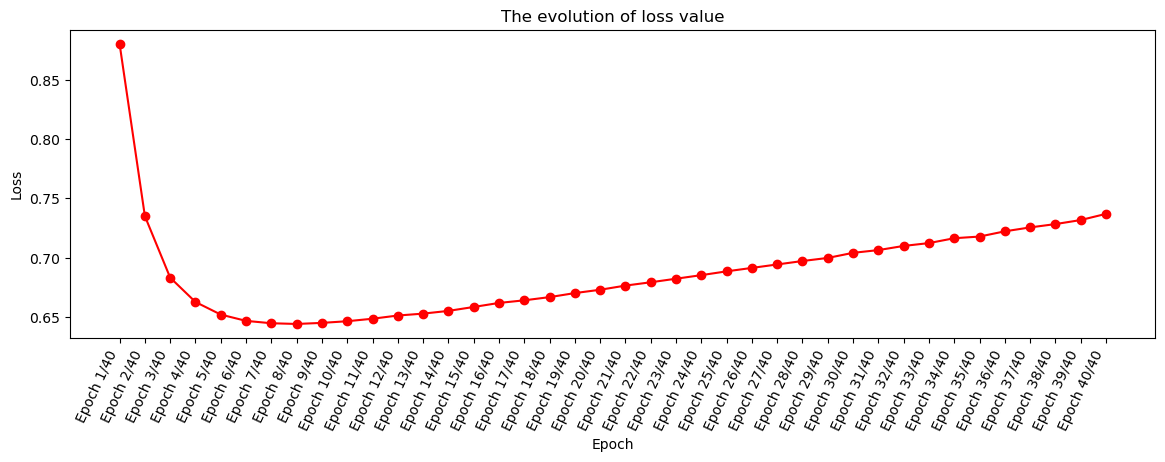

In [11]:
#plot the evolution of validation loss on training stage
values = [0.8801, 0.7351, 0.6833, 0.6628, 0.6522, 0.6469, 0.6449, 0.6443, 0.6452, 0.6466, 0.6487, 0.6514, 0.6530, 0.6553, 0.6586, 0.6620, 0.6642, 0.6669, 0.6703, 0.6731, 0.6766, 0.6794, 0.6824, 0.6854, 0.6886, 0.6915, 0.6944, 0.6973, 0.6999, 0.7042, 0.7065, 0.7100, 0.7124, 0.7165, 0.7179, 0.7223, 0.7256, 0.7284, 0.7318, 0.7370]
epoch = ['Epoch 1/40', 'Epoch 2/40', 'Epoch 3/40', 'Epoch 4/40', 'Epoch 5/40', 'Epoch 6/40', 'Epoch 7/40', 'Epoch 8/40', 'Epoch 9/40', 'Epoch 10/40', 'Epoch 11/40', 'Epoch 12/40', 'Epoch 13/40', 'Epoch 14/40', 'Epoch 15/40', 'Epoch 16/40', 'Epoch 17/40', 'Epoch 18/40', 'Epoch 19/40', 'Epoch 20/40', 'Epoch 21/40', 'Epoch 22/40', 'Epoch 23/40', 'Epoch 24/40', 'Epoch 25/40', 'Epoch 26/40', 'Epoch 27/40', 'Epoch 28/40', 'Epoch 29/40', 'Epoch 30/40', 'Epoch 31/40', 'Epoch 32/40', 'Epoch 33/40', 'Epoch 34/40', 'Epoch 35/40', 'Epoch 36/40', 'Epoch 37/40', 'Epoch 38/40', 'Epoch 39/40', 'Epoch 40/40']
plt.figure(figsize = (14, 4))
plt.plot(epoch, values, marker = 'o', linestyle = '-', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The evolution of loss value')
plt.xticks(rotation=65, ha='right')
plt.show()

Epoch 1/7
1407/1407 [==============================] - 8s 4ms/step - loss: 0.8653 - accuracy: 0.6000 - val_loss: 0.7106 - val_accuracy: 0.6835
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6740 - accuracy: 0.7033 - val_loss: 0.6717 - val_accuracy: 0.7044
Epoch 3/7
1407/1407 [==============================] - 5s 4ms/step - loss: 0.6334 - accuracy: 0.7274 - val_loss: 0.6701 - val_accuracy: 0.7052
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6113 - accuracy: 0.7426 - val_loss: 0.6774 - val_accuracy: 0.7045
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5914 - accuracy: 0.7533 - val_loss: 0.6847 - val_accuracy: 0.6949
Epoch 6/7
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5735 - accuracy: 0.7644 - val_loss: 0.6952 - val_accuracy: 0.6942
Epoch 7/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5526 - accuracy: 0.7765 - val_loss: 0.7041 - val_accuracy: 0.6980

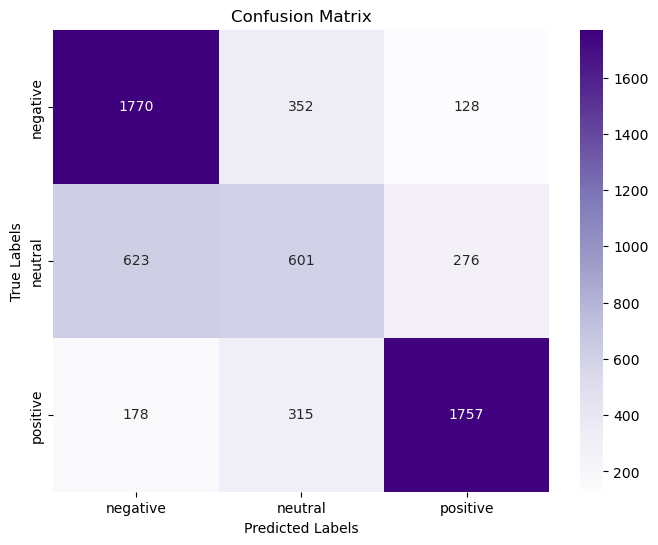

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 7s 4ms/step - loss: 1.0942 - accuracy: 0.4004 - val_loss: 1.0868 - val_accuracy: 0.4842
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0765 - accuracy: 0.4940 - val_loss: 1.0539 - val_accuracy: 0.5906
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0121 - accuracy: 0.6037 - val_loss: 0.9455 - val_accuracy: 0.6445
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8848 - accuracy: 0.6444 - val_loss: 0.8199 - val_accuracy: 0.6611
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7921 - accuracy: 0.6576 - val_loss: 0.7590 - val_accuracy: 0.6680
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7488 - accuracy: 0.6647 - val_loss: 0.7320 - val_accuracy: 0.6738
Epoch 7/7
1407/1407 [================

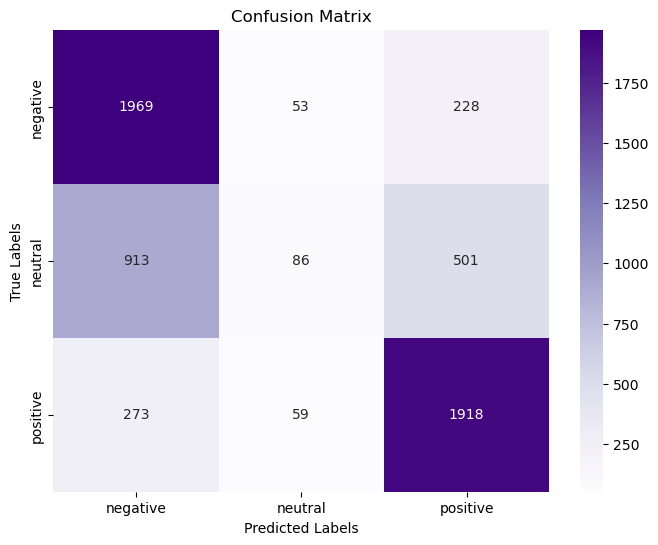

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8259 - accuracy: 0.6207 - val_loss: 0.6900 - val_accuracy: 0.6945
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6567 - accuracy: 0.7144 - val_loss: 0.6693 - val_accuracy: 0.7048
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6170 - accuracy: 0.7359 - val_loss: 0.6733 - val_accuracy: 0.7019
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5868 - accuracy: 0.7527 - val_loss: 0.6834 - val_accuracy: 0.6980
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5555 - accuracy: 0.7716 - val_loss: 0.6990 - val_accuracy: 0.6972
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5183 - accuracy: 0.7919 - val_loss: 0.7193 - val_accuracy: 0.6968
Epoch 7/7
1407/1407 [================

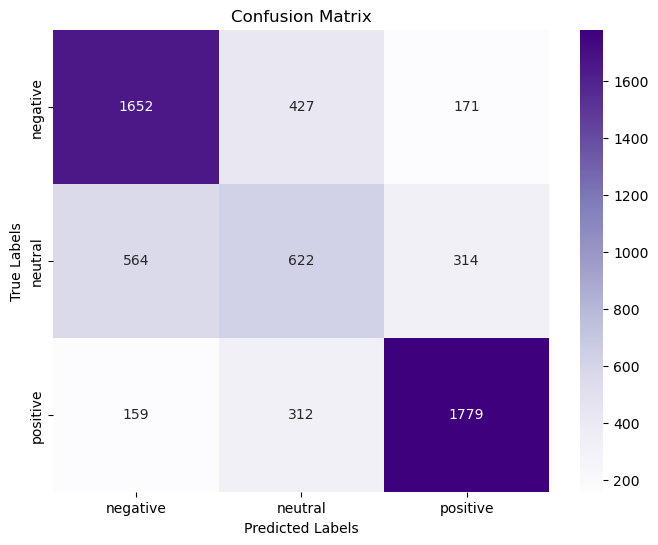

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0922 - accuracy: 0.4103 - val_loss: 1.0819 - val_accuracy: 0.4703
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0673 - accuracy: 0.5159 - val_loss: 1.0346 - val_accuracy: 0.6168
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9731 - accuracy: 0.6253 - val_loss: 0.8873 - val_accuracy: 0.6535
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8279 - accuracy: 0.6531 - val_loss: 0.7731 - val_accuracy: 0.6658
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7511 - accuracy: 0.6651 - val_loss: 0.7337 - val_accuracy: 0.6734
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7201 - accuracy: 0.6724 - val_loss: 0.7178 - val_accuracy: 0.6785
Epoch 7/7
1407/1407 [================

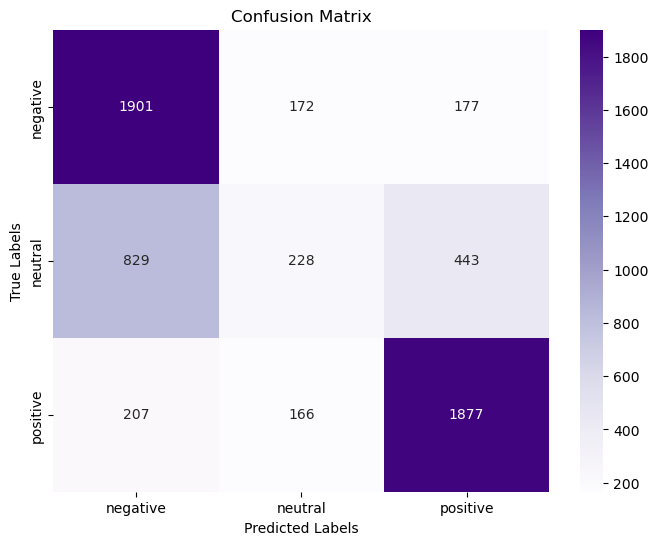

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 4ms/step - loss: 0.8380 - accuracy: 0.6094 - val_loss: 0.7064 - val_accuracy: 0.6845
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6894 - accuracy: 0.6884 - val_loss: 0.6956 - val_accuracy: 0.6842
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6536 - accuracy: 0.7129 - val_loss: 0.6849 - val_accuracy: 0.6933
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6157 - accuracy: 0.7364 - val_loss: 0.6860 - val_accuracy: 0.6912
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5836 - accuracy: 0.7557 - val_loss: 0.6945 - val_accuracy: 0.6932
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5557 - accuracy: 0.7716 - val_loss: 0.7114 - val_accuracy: 0.6936
Epoch 7/7
1407/1407 [================

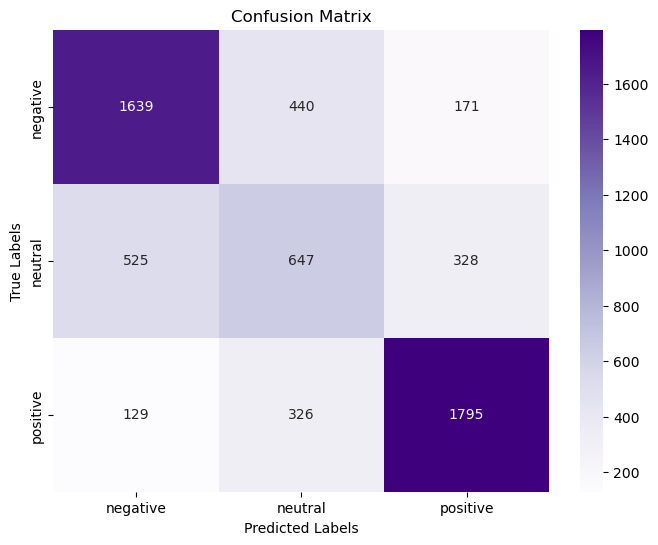

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 4ms/step - loss: 1.0933 - accuracy: 0.3836 - val_loss: 1.0841 - val_accuracy: 0.3846
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0787 - accuracy: 0.4016 - val_loss: 1.0655 - val_accuracy: 0.4096
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0487 - accuracy: 0.5291 - val_loss: 1.0082 - val_accuracy: 0.6153
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9526 - accuracy: 0.6306 - val_loss: 0.8720 - val_accuracy: 0.6602
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8240 - accuracy: 0.6528 - val_loss: 0.7706 - val_accuracy: 0.6704
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7570 - accuracy: 0.6645 - val_loss: 0.7326 - val_accuracy: 0.6757
Epoch 7/7
1407/1407 [================

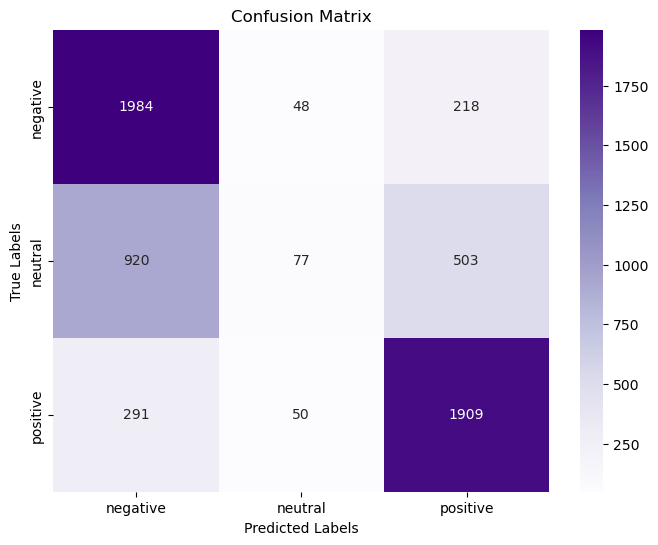

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 0.8265 - accuracy: 0.6048 - val_loss: 0.6936 - val_accuracy: 0.6916
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6580 - accuracy: 0.7108 - val_loss: 0.6714 - val_accuracy: 0.7024
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6084 - accuracy: 0.7410 - val_loss: 0.6804 - val_accuracy: 0.6969
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5677 - accuracy: 0.7649 - val_loss: 0.6924 - val_accuracy: 0.7023
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5221 - accuracy: 0.7903 - val_loss: 0.7211 - val_accuracy: 0.6958
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.4687 - accuracy: 0.8175 - val_loss: 0.7664 - val_accuracy: 0.6837
Epoch 7/7
1407/1407 [================

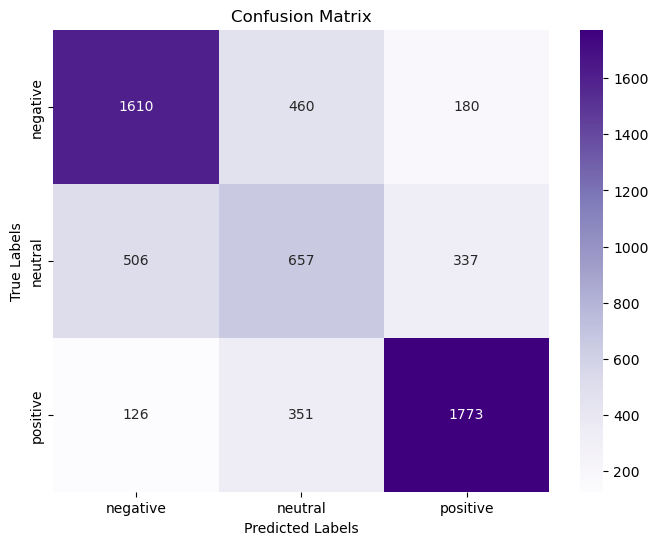

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 1.0906 - accuracy: 0.3890 - val_loss: 1.0764 - val_accuracy: 0.3909
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0491 - accuracy: 0.5127 - val_loss: 0.9819 - val_accuracy: 0.6334
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8881 - accuracy: 0.6358 - val_loss: 0.7975 - val_accuracy: 0.6589
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7703 - accuracy: 0.6558 - val_loss: 0.7423 - val_accuracy: 0.6691
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7311 - accuracy: 0.6676 - val_loss: 0.7243 - val_accuracy: 0.6769
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7113 - accuracy: 0.6784 - val_loss: 0.7154 - val_accuracy: 0.6775
Epoch 7/7
1407/1407 [================

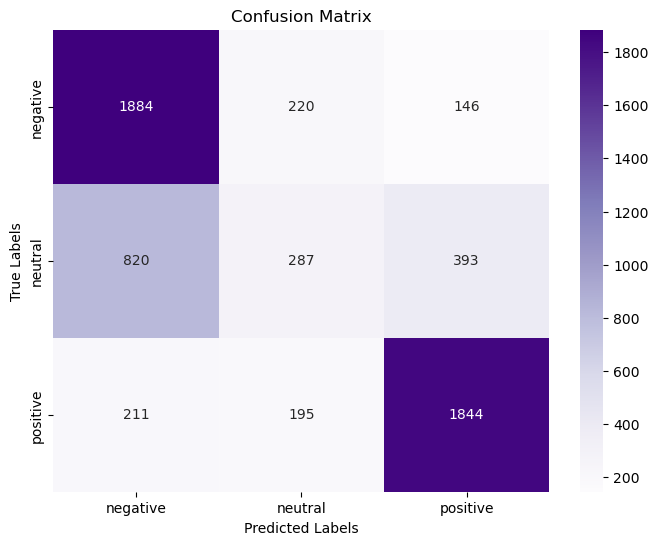

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 4ms/step - loss: 0.8536 - accuracy: 0.6129 - val_loss: 0.6957 - val_accuracy: 0.6894
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6760 - accuracy: 0.7029 - val_loss: 0.6733 - val_accuracy: 0.7035
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6301 - accuracy: 0.7301 - val_loss: 0.6675 - val_accuracy: 0.7063
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6020 - accuracy: 0.7455 - val_loss: 0.6739 - val_accuracy: 0.7032
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5786 - accuracy: 0.7582 - val_loss: 0.6771 - val_accuracy: 0.7032
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5550 - accuracy: 0.7728 - val_loss: 0.6872 - val_accuracy: 0.7046
Epoch 7/7
1407/1407 [================

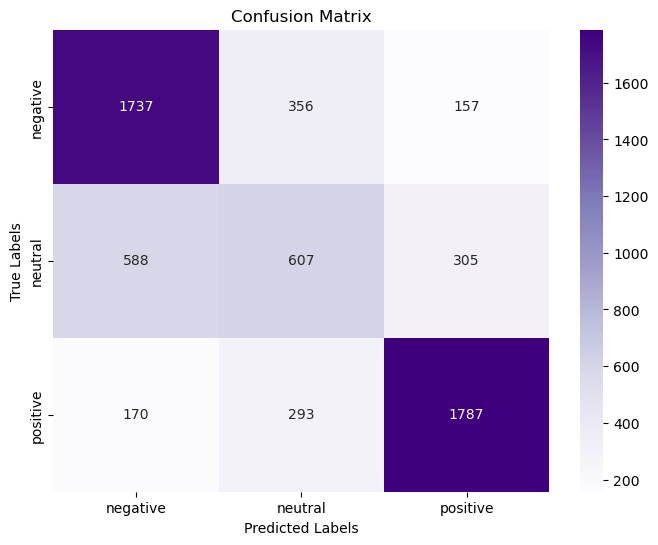

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 1.0933 - accuracy: 0.3934 - val_loss: 1.0844 - val_accuracy: 0.4685
Epoch 2/7
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0785 - accuracy: 0.4693 - val_loss: 1.0647 - val_accuracy: 0.5805
Epoch 3/7
1407/1407 [==============================] - 6s 5ms/step - loss: 1.0478 - accuracy: 0.5714 - val_loss: 1.0119 - val_accuracy: 0.6202
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9653 - accuracy: 0.6259 - val_loss: 0.9010 - val_accuracy: 0.6577
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8571 - accuracy: 0.6497 - val_loss: 0.8039 - val_accuracy: 0.6680
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7794 - accuracy: 0.6628 - val_loss: 0.7475 - val_accuracy: 0.6753
Epoch 7/7
1407/1407 [================

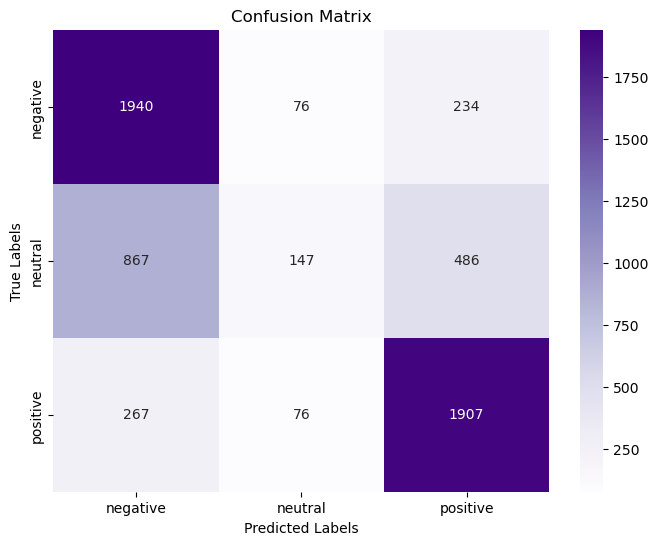

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 0.8323 - accuracy: 0.6079 - val_loss: 0.6791 - val_accuracy: 0.6973
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6468 - accuracy: 0.7168 - val_loss: 0.6581 - val_accuracy: 0.7071
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6053 - accuracy: 0.7422 - val_loss: 0.6638 - val_accuracy: 0.7057
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5746 - accuracy: 0.7599 - val_loss: 0.6702 - val_accuracy: 0.7048
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5433 - accuracy: 0.7770 - val_loss: 0.6930 - val_accuracy: 0.7041
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5054 - accuracy: 0.7978 - val_loss: 0.7110 - val_accuracy: 0.6962
Epoch 7/7
1407/1407 [================

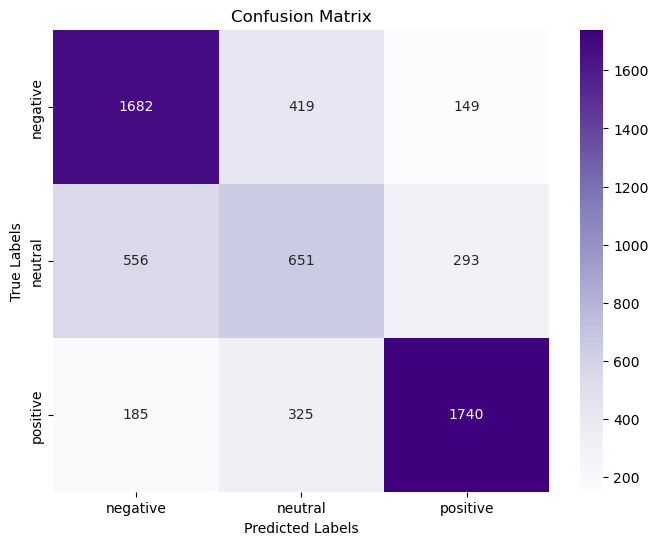

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 1.0886 - accuracy: 0.4180 - val_loss: 1.0743 - val_accuracy: 0.5407
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0544 - accuracy: 0.5618 - val_loss: 1.0075 - val_accuracy: 0.6362
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9307 - accuracy: 0.6380 - val_loss: 0.8350 - val_accuracy: 0.6612
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7905 - accuracy: 0.6573 - val_loss: 0.7472 - val_accuracy: 0.6718
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7322 - accuracy: 0.6683 - val_loss: 0.7167 - val_accuracy: 0.6767
Epoch 6/7
1407/1407 [==============================] - 8s 5ms/step - loss: 0.7060 - accuracy: 0.6779 - val_loss: 0.7033 - val_accuracy: 0.6856
Epoch 7/7
1407/1407 [================

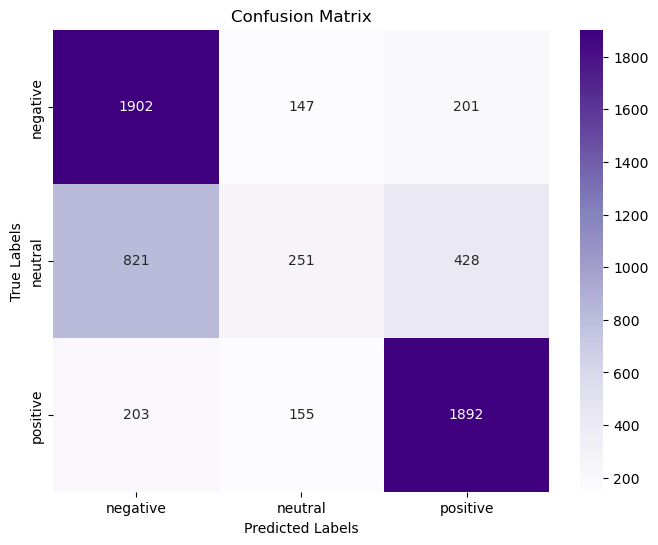

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8290 - accuracy: 0.6117 - val_loss: 0.6969 - val_accuracy: 0.6856
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6705 - accuracy: 0.7019 - val_loss: 0.6767 - val_accuracy: 0.6986
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6209 - accuracy: 0.7338 - val_loss: 0.6699 - val_accuracy: 0.7074
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5840 - accuracy: 0.7559 - val_loss: 0.6756 - val_accuracy: 0.7077
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5508 - accuracy: 0.7749 - val_loss: 0.6930 - val_accuracy: 0.6996
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5106 - accuracy: 0.7970 - val_loss: 0.7214 - val_accuracy: 0.6973
Epoch 7/7
1407/1407 [================

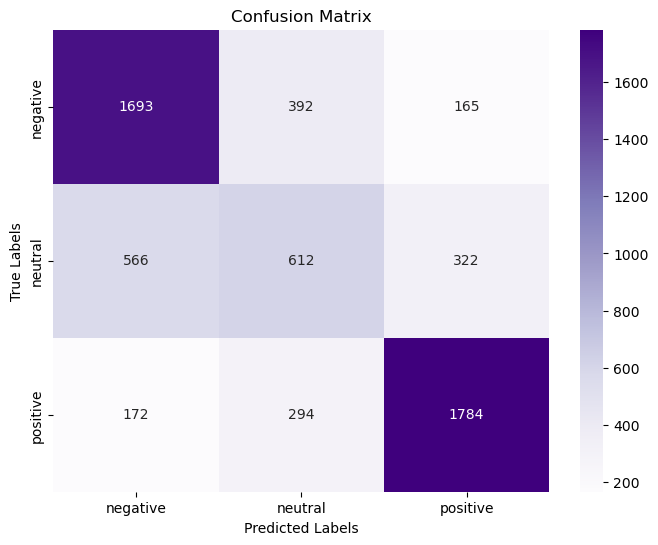

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0917 - accuracy: 0.3934 - val_loss: 1.0815 - val_accuracy: 0.4381
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0770 - accuracy: 0.4357 - val_loss: 1.0629 - val_accuracy: 0.5732
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0477 - accuracy: 0.5648 - val_loss: 1.0076 - val_accuracy: 0.6348
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9510 - accuracy: 0.6316 - val_loss: 0.8705 - val_accuracy: 0.6552
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8234 - accuracy: 0.6526 - val_loss: 0.7718 - val_accuracy: 0.6653
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7565 - accuracy: 0.6628 - val_loss: 0.7327 - val_accuracy: 0.6711
Epoch 7/7
1407/1407 [================

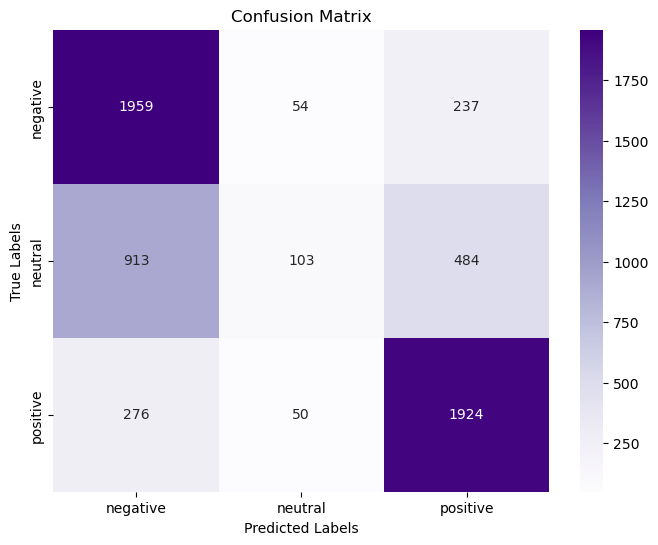

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 9s 5ms/step - loss: 0.8089 - accuracy: 0.6208 - val_loss: 0.6872 - val_accuracy: 0.6861
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6560 - accuracy: 0.7092 - val_loss: 0.6657 - val_accuracy: 0.7035
Epoch 3/7
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6026 - accuracy: 0.7405 - val_loss: 0.6668 - val_accuracy: 0.7055
Epoch 4/7
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5556 - accuracy: 0.7664 - val_loss: 0.6816 - val_accuracy: 0.7041
Epoch 5/7
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5052 - accuracy: 0.7964 - val_loss: 0.7143 - val_accuracy: 0.6996
Epoch 6/7
1407/1407 [==============================] - 8s 5ms/step - loss: 0.4425 - accuracy: 0.8282 - val_loss: 0.7607 - val_accuracy: 0.6896
Epoch 7/7
1407/1407 [================

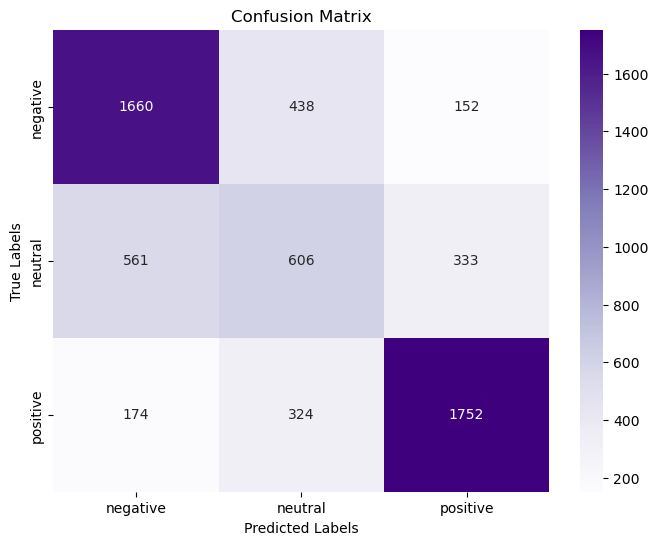

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 10s 5ms/step - loss: 1.0891 - accuracy: 0.4144 - val_loss: 1.0737 - val_accuracy: 0.5418
Epoch 2/7
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0447 - accuracy: 0.5697 - val_loss: 0.9739 - val_accuracy: 0.6424
Epoch 3/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8705 - accuracy: 0.6459 - val_loss: 0.7763 - val_accuracy: 0.6670
Epoch 4/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7477 - accuracy: 0.6632 - val_loss: 0.7270 - val_accuracy: 0.6777
Epoch 5/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7107 - accuracy: 0.6760 - val_loss: 0.7113 - val_accuracy: 0.6831
Epoch 6/7
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6927 - accuracy: 0.6846 - val_loss: 0.7031 - val_accuracy: 0.6851
Epoch 7/7
1407/1407 [===============

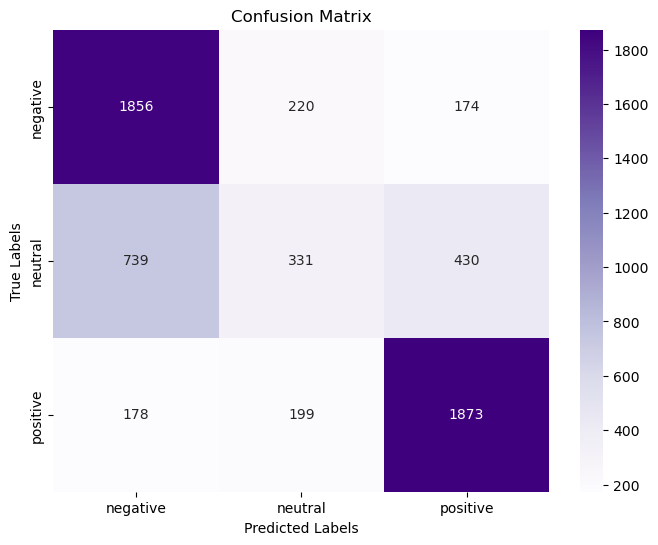

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 8s 4ms/step - loss: 0.8453 - accuracy: 0.6075 - val_loss: 0.6957 - val_accuracy: 0.6870
Epoch 2/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6764 - accuracy: 0.6970 - val_loss: 0.6756 - val_accuracy: 0.6995
Epoch 3/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6337 - accuracy: 0.7243 - val_loss: 0.6643 - val_accuracy: 0.7070
Epoch 4/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6004 - accuracy: 0.7436 - val_loss: 0.6685 - val_accuracy: 0.7095
Epoch 5/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5744 - accuracy: 0.7603 - val_loss: 0.6768 - val_accuracy: 0.7020
Epoch 6/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5448 - accuracy: 0.7753 - val_loss: 0.6869 - val_accuracy: 0.7052
Epoch 7/7
1407/1407 [================

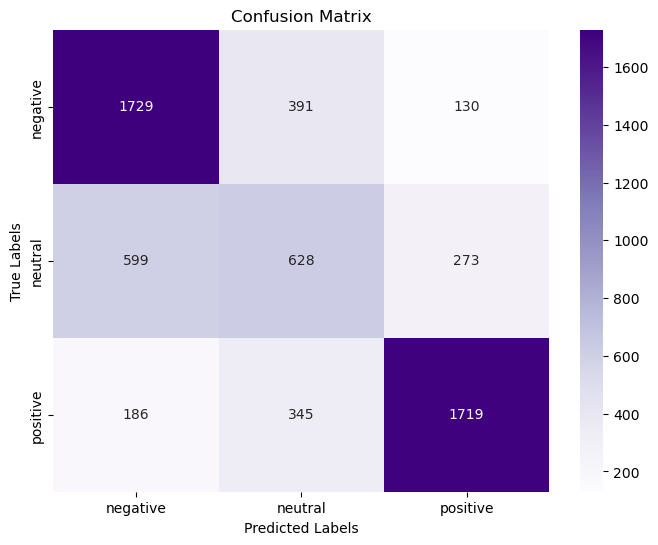

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0909 - accuracy: 0.4238 - val_loss: 1.0801 - val_accuracy: 0.4652
Epoch 2/7
1407/1407 [==============================] - 2s 2ms/step - loss: 1.0740 - accuracy: 0.4909 - val_loss: 1.0580 - val_accuracy: 0.5664
Epoch 3/7
1407/1407 [==============================] - 2s 2ms/step - loss: 1.0388 - accuracy: 0.5944 - val_loss: 0.9970 - val_accuracy: 0.6392
Epoch 4/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.9496 - accuracy: 0.6402 - val_loss: 0.8848 - val_accuracy: 0.6584
Epoch 5/7
1407/1407 [==============================] - 2s 1ms/step - loss: 0.8441 - accuracy: 0.6528 - val_loss: 0.7914 - val_accuracy: 0.6672
Epoch 6/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.7713 - accuracy: 0.6633 - val_loss: 0.7423 - val_accuracy: 0.6709
Epoch 7/7
1407/1407 [================

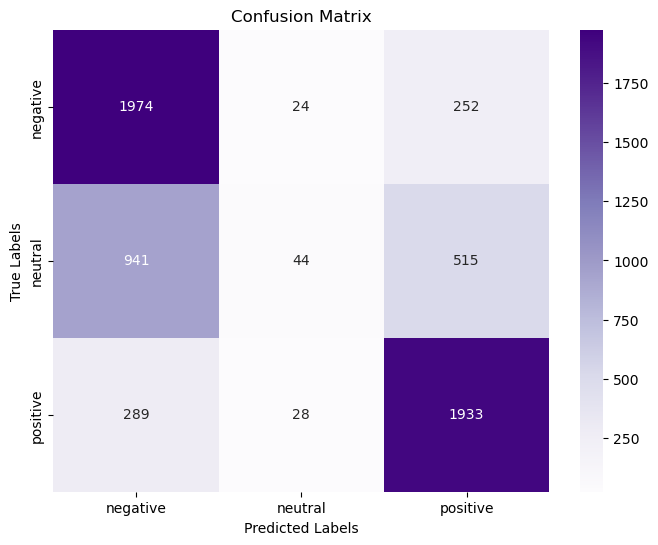

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8224 - accuracy: 0.6181 - val_loss: 0.6873 - val_accuracy: 0.6924
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6576 - accuracy: 0.7090 - val_loss: 0.6616 - val_accuracy: 0.7055
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6106 - accuracy: 0.7368 - val_loss: 0.6664 - val_accuracy: 0.7049
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5779 - accuracy: 0.7556 - val_loss: 0.6700 - val_accuracy: 0.7048
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5463 - accuracy: 0.7739 - val_loss: 0.6857 - val_accuracy: 0.6982
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5105 - accuracy: 0.7940 - val_loss: 0.7047 - val_accuracy: 0.6940
Epoch 7/7
1407/1407 [================

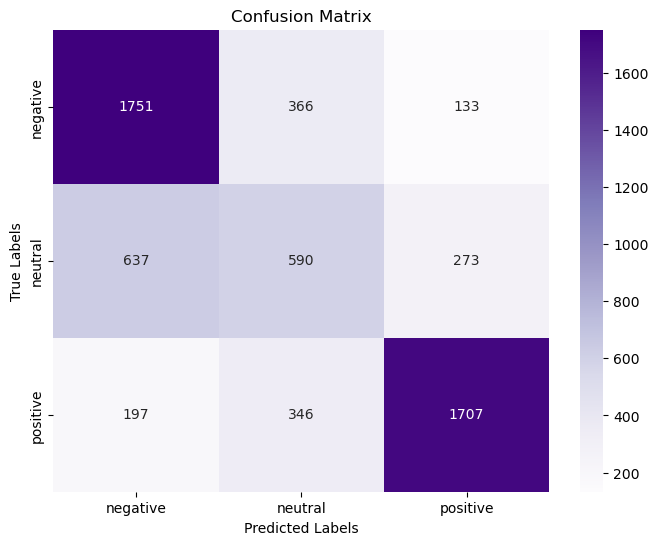

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0903 - accuracy: 0.4064 - val_loss: 1.0775 - val_accuracy: 0.5158
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0641 - accuracy: 0.5151 - val_loss: 1.0296 - val_accuracy: 0.6324
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.9643 - accuracy: 0.6294 - val_loss: 0.8682 - val_accuracy: 0.6601
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8115 - accuracy: 0.6548 - val_loss: 0.7553 - val_accuracy: 0.6689
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7390 - accuracy: 0.6656 - val_loss: 0.7190 - val_accuracy: 0.6769
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7092 - accuracy: 0.6772 - val_loss: 0.7042 - val_accuracy: 0.6815
Epoch 7/7
1407/1407 [================

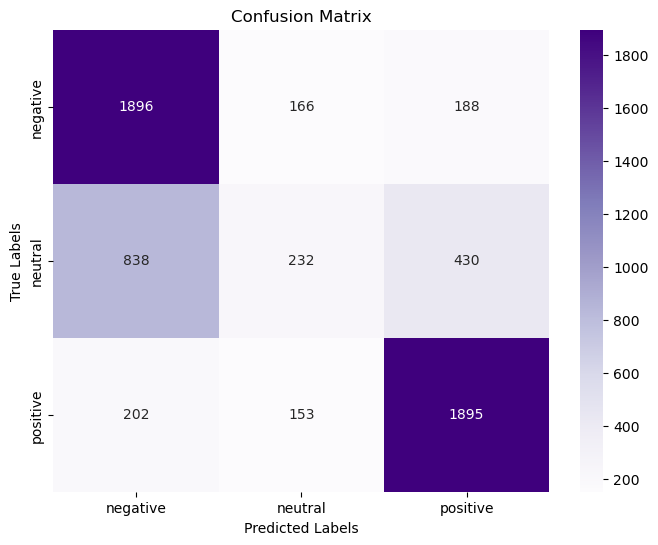

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8413 - accuracy: 0.6114 - val_loss: 0.6965 - val_accuracy: 0.6862
Epoch 2/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.6716 - accuracy: 0.7030 - val_loss: 0.6737 - val_accuracy: 0.7040
Epoch 3/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.6238 - accuracy: 0.7328 - val_loss: 0.6684 - val_accuracy: 0.7058
Epoch 4/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.5912 - accuracy: 0.7524 - val_loss: 0.6730 - val_accuracy: 0.7033
Epoch 5/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.5588 - accuracy: 0.7685 - val_loss: 0.6894 - val_accuracy: 0.6992
Epoch 6/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.5284 - accuracy: 0.7873 - val_loss: 0.7067 - val_accuracy: 0.6979
Epoch 7/7
1407/1407 [================

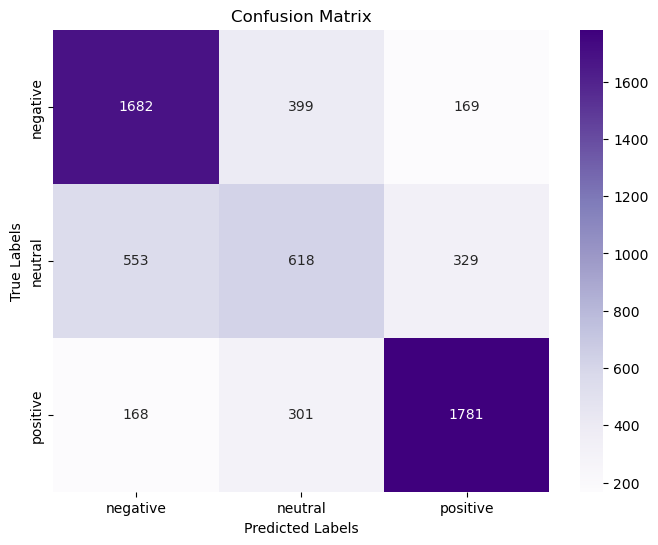

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0923 - accuracy: 0.3892 - val_loss: 1.0821 - val_accuracy: 0.3848
Epoch 2/7
1407/1407 [==============================] - 2s 2ms/step - loss: 1.0683 - accuracy: 0.4384 - val_loss: 1.0369 - val_accuracy: 0.5310
Epoch 3/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.9799 - accuracy: 0.5968 - val_loss: 0.8963 - val_accuracy: 0.6497
Epoch 4/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.8407 - accuracy: 0.6467 - val_loss: 0.7845 - val_accuracy: 0.6637
Epoch 5/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.7649 - accuracy: 0.6611 - val_loss: 0.7419 - val_accuracy: 0.6701
Epoch 6/7
1407/1407 [==============================] - 2s 2ms/step - loss: 0.7305 - accuracy: 0.6686 - val_loss: 0.7236 - val_accuracy: 0.6772
Epoch 7/7
1407/1407 [================

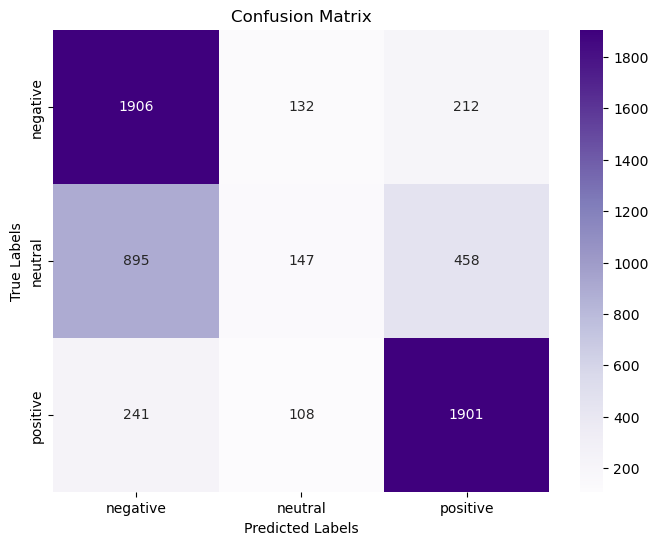

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8132 - accuracy: 0.6228 - val_loss: 0.6928 - val_accuracy: 0.6848
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6590 - accuracy: 0.7090 - val_loss: 0.6680 - val_accuracy: 0.7029
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6046 - accuracy: 0.7423 - val_loss: 0.6700 - val_accuracy: 0.7048
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5608 - accuracy: 0.7654 - val_loss: 0.6891 - val_accuracy: 0.6990
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5139 - accuracy: 0.7903 - val_loss: 0.7172 - val_accuracy: 0.6999
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4550 - accuracy: 0.8225 - val_loss: 0.7661 - val_accuracy: 0.6903
Epoch 7/7
1407/1407 [================

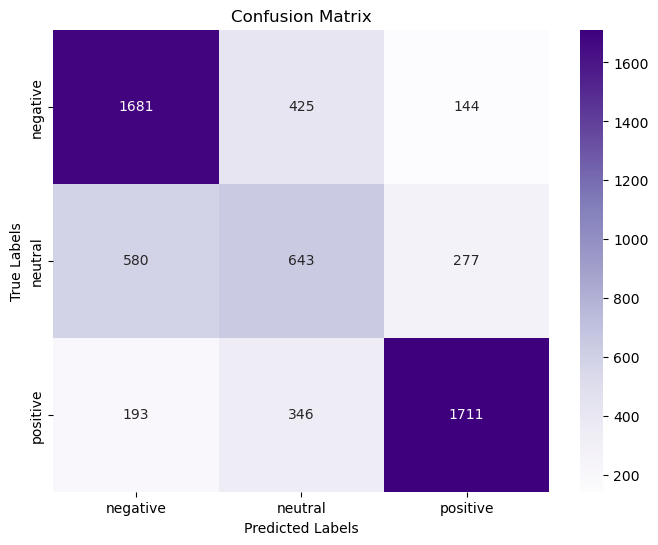

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0913 - accuracy: 0.3818 - val_loss: 1.0796 - val_accuracy: 0.4042
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0768 - accuracy: 0.4275 - val_loss: 1.0635 - val_accuracy: 0.5650
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0321 - accuracy: 0.5758 - val_loss: 0.9497 - val_accuracy: 0.6381
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8533 - accuracy: 0.6424 - val_loss: 0.7750 - val_accuracy: 0.6635
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7507 - accuracy: 0.6615 - val_loss: 0.7284 - val_accuracy: 0.6746
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7162 - accuracy: 0.6736 - val_loss: 0.7118 - val_accuracy: 0.6812
Epoch 7/7
1407/1407 [================

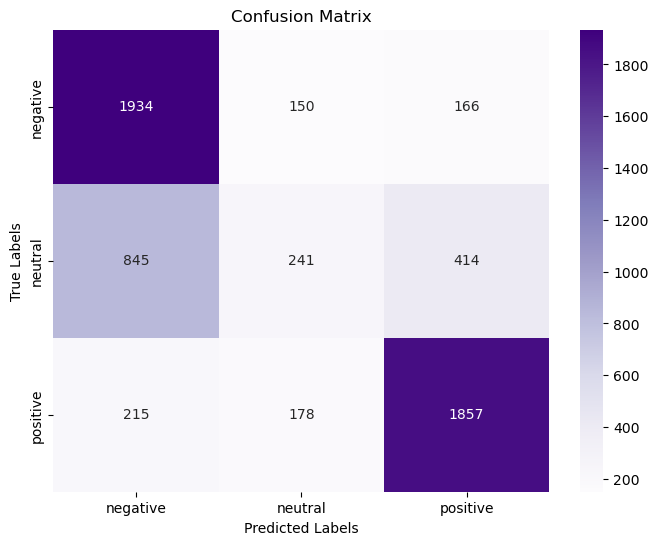

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8556 - accuracy: 0.6030 - val_loss: 0.6935 - val_accuracy: 0.6938
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6623 - accuracy: 0.7135 - val_loss: 0.6689 - val_accuracy: 0.7045
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6185 - accuracy: 0.7375 - val_loss: 0.6724 - val_accuracy: 0.7009
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5881 - accuracy: 0.7522 - val_loss: 0.6824 - val_accuracy: 0.7019
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5646 - accuracy: 0.7666 - val_loss: 0.6945 - val_accuracy: 0.6980
Epoch 6/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.5375 - accuracy: 0.7824 - val_loss: 0.7099 - val_accuracy: 0.6925
Epoch 7/7
1407/1407 [================

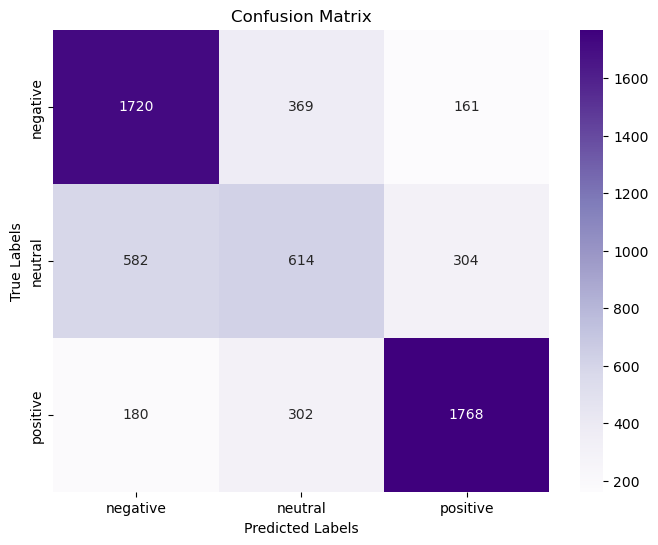

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0937 - accuracy: 0.3942 - val_loss: 1.0857 - val_accuracy: 0.4369
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0767 - accuracy: 0.4960 - val_loss: 1.0560 - val_accuracy: 0.6083
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0209 - accuracy: 0.6148 - val_loss: 0.9623 - val_accuracy: 0.6514
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.9030 - accuracy: 0.6505 - val_loss: 0.8364 - val_accuracy: 0.6649
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8030 - accuracy: 0.6610 - val_loss: 0.7647 - val_accuracy: 0.6721
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7512 - accuracy: 0.6684 - val_loss: 0.7318 - val_accuracy: 0.6753
Epoch 7/7
1407/1407 [================

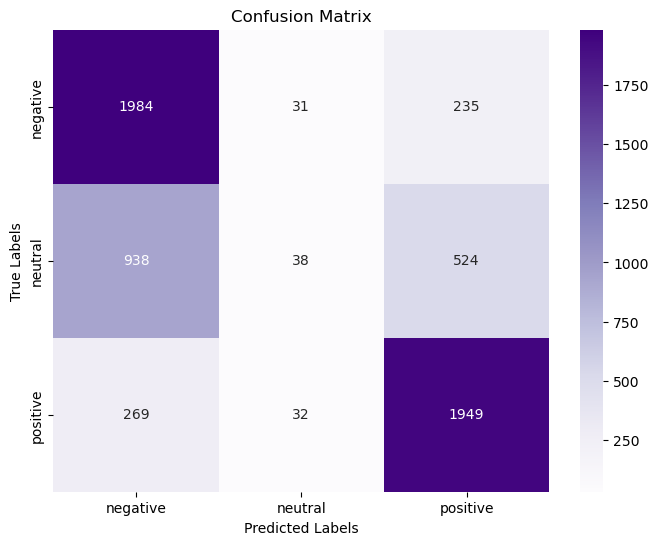

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8201 - accuracy: 0.6220 - val_loss: 0.6883 - val_accuracy: 0.6910
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6521 - accuracy: 0.7152 - val_loss: 0.6706 - val_accuracy: 0.6997
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6039 - accuracy: 0.7439 - val_loss: 0.6775 - val_accuracy: 0.6989
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5676 - accuracy: 0.7645 - val_loss: 0.6918 - val_accuracy: 0.6984
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5316 - accuracy: 0.7834 - val_loss: 0.7156 - val_accuracy: 0.6944
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4914 - accuracy: 0.8048 - val_loss: 0.7413 - val_accuracy: 0.6908
Epoch 7/7
1407/1407 [================

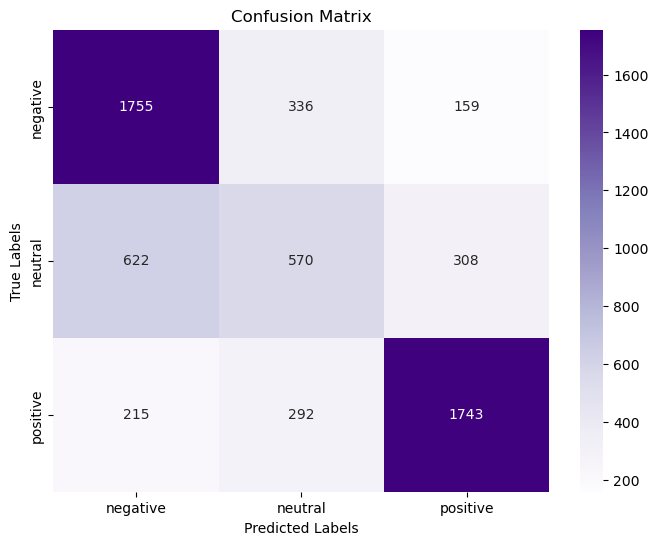

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 6s 3ms/step - loss: 1.0887 - accuracy: 0.3902 - val_loss: 1.0735 - val_accuracy: 0.4066
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0540 - accuracy: 0.5068 - val_loss: 1.0064 - val_accuracy: 0.6175
Epoch 3/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.9328 - accuracy: 0.6327 - val_loss: 0.8434 - val_accuracy: 0.6615
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7944 - accuracy: 0.6578 - val_loss: 0.7526 - val_accuracy: 0.6722
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7328 - accuracy: 0.6696 - val_loss: 0.7211 - val_accuracy: 0.6785
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7048 - accuracy: 0.6813 - val_loss: 0.7071 - val_accuracy: 0.6853
Epoch 7/7
1407/1407 [================

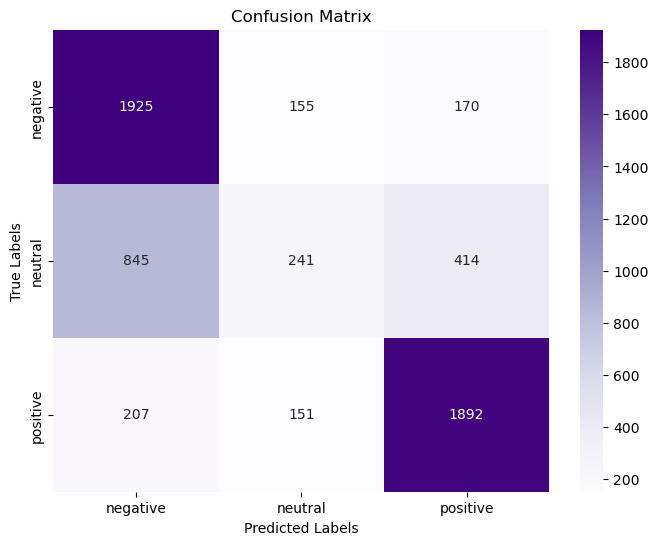

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8380 - accuracy: 0.6019 - val_loss: 0.7028 - val_accuracy: 0.6856
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6718 - accuracy: 0.7026 - val_loss: 0.6810 - val_accuracy: 0.6977
Epoch 3/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.6185 - accuracy: 0.7354 - val_loss: 0.6808 - val_accuracy: 0.6975
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5802 - accuracy: 0.7550 - val_loss: 0.6896 - val_accuracy: 0.6976
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5467 - accuracy: 0.7764 - val_loss: 0.7122 - val_accuracy: 0.6918
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5098 - accuracy: 0.7960 - val_loss: 0.7413 - val_accuracy: 0.6915
Epoch 7/7
1407/1407 [================

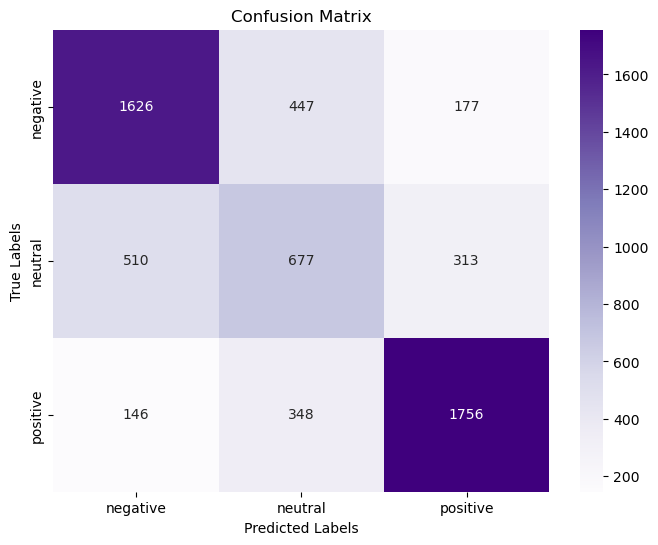

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0929 - accuracy: 0.3957 - val_loss: 1.0829 - val_accuracy: 0.4789
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0727 - accuracy: 0.5041 - val_loss: 1.0485 - val_accuracy: 0.6118
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0039 - accuracy: 0.6112 - val_loss: 0.9309 - val_accuracy: 0.6452
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8671 - accuracy: 0.6467 - val_loss: 0.8011 - val_accuracy: 0.6644
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7767 - accuracy: 0.6596 - val_loss: 0.7492 - val_accuracy: 0.6705
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7361 - accuracy: 0.6691 - val_loss: 0.7268 - val_accuracy: 0.6748
Epoch 7/7
1407/1407 [================

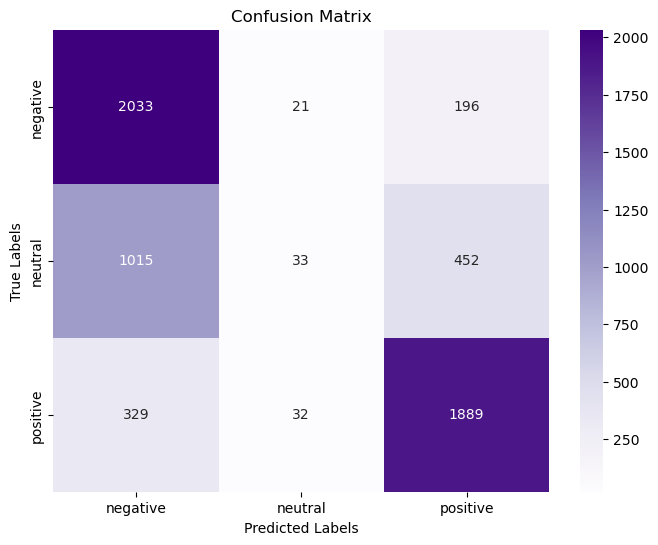

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8216 - accuracy: 0.6117 - val_loss: 0.6924 - val_accuracy: 0.6878
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6496 - accuracy: 0.7164 - val_loss: 0.6724 - val_accuracy: 0.7042
Epoch 3/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5929 - accuracy: 0.7494 - val_loss: 0.6817 - val_accuracy: 0.6979
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5449 - accuracy: 0.7786 - val_loss: 0.7071 - val_accuracy: 0.6974
Epoch 5/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4853 - accuracy: 0.8086 - val_loss: 0.7454 - val_accuracy: 0.6878
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4169 - accuracy: 0.8438 - val_loss: 0.8134 - val_accuracy: 0.6807
Epoch 7/7
1407/1407 [================

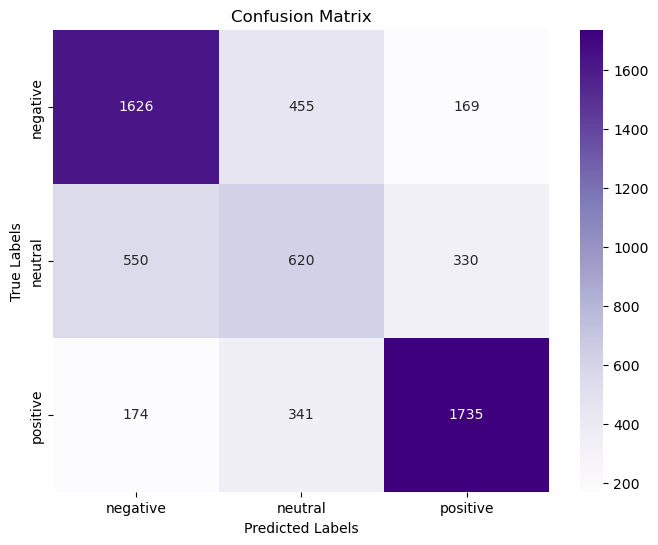

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0914 - accuracy: 0.4338 - val_loss: 1.0749 - val_accuracy: 0.5768
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0022 - accuracy: 0.6121 - val_loss: 0.8789 - val_accuracy: 0.6540
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.8026 - accuracy: 0.6559 - val_loss: 0.7519 - val_accuracy: 0.6707
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7322 - accuracy: 0.6684 - val_loss: 0.7246 - val_accuracy: 0.6758
Epoch 5/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7070 - accuracy: 0.6785 - val_loss: 0.7145 - val_accuracy: 0.6787
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6905 - accuracy: 0.6882 - val_loss: 0.7092 - val_accuracy: 0.6785
Epoch 7/7
1407/1407 [================

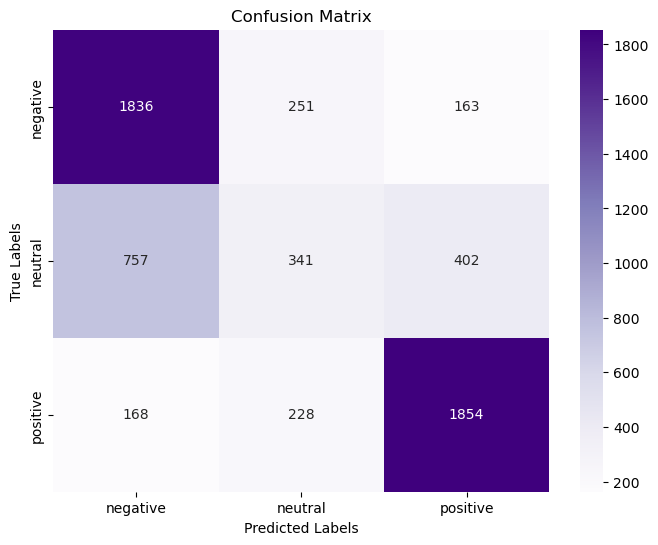

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8424 - accuracy: 0.6112 - val_loss: 0.6950 - val_accuracy: 0.6915
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6607 - accuracy: 0.7041 - val_loss: 0.6697 - val_accuracy: 0.7061
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6104 - accuracy: 0.7380 - val_loss: 0.6656 - val_accuracy: 0.7099
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5705 - accuracy: 0.7606 - val_loss: 0.6704 - val_accuracy: 0.7102
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5357 - accuracy: 0.7821 - val_loss: 0.6884 - val_accuracy: 0.7024
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4996 - accuracy: 0.8030 - val_loss: 0.7108 - val_accuracy: 0.7017
Epoch 7/7
1407/1407 [================

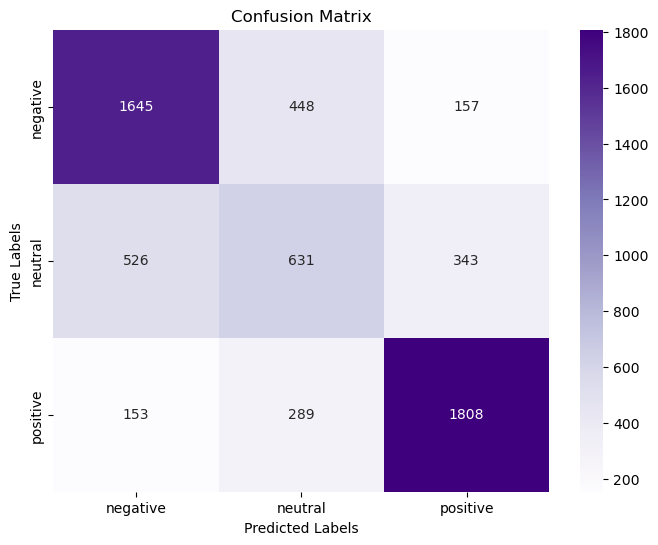

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0931 - accuracy: 0.4036 - val_loss: 1.0843 - val_accuracy: 0.4182
Epoch 2/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0754 - accuracy: 0.4658 - val_loss: 1.0549 - val_accuracy: 0.5665
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0199 - accuracy: 0.5989 - val_loss: 0.9587 - val_accuracy: 0.6538
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8992 - accuracy: 0.6494 - val_loss: 0.8308 - val_accuracy: 0.6683
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7978 - accuracy: 0.6624 - val_loss: 0.7578 - val_accuracy: 0.6747
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7427 - accuracy: 0.6702 - val_loss: 0.7227 - val_accuracy: 0.6782
Epoch 7/7
1407/1407 [================

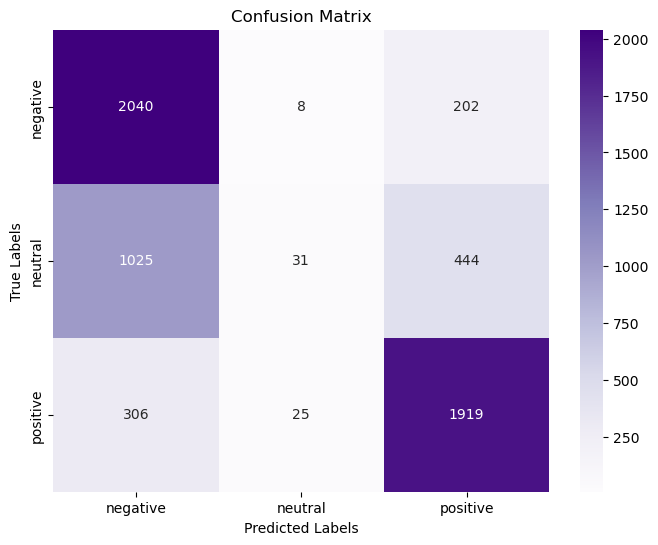

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8144 - accuracy: 0.6210 - val_loss: 0.6758 - val_accuracy: 0.6975
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6302 - accuracy: 0.7249 - val_loss: 0.6561 - val_accuracy: 0.7106
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5740 - accuracy: 0.7570 - val_loss: 0.6640 - val_accuracy: 0.7098
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5303 - accuracy: 0.7827 - val_loss: 0.6867 - val_accuracy: 0.7038
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4845 - accuracy: 0.8086 - val_loss: 0.7119 - val_accuracy: 0.7010
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4304 - accuracy: 0.8338 - val_loss: 0.7687 - val_accuracy: 0.6960
Epoch 7/7
1407/1407 [================

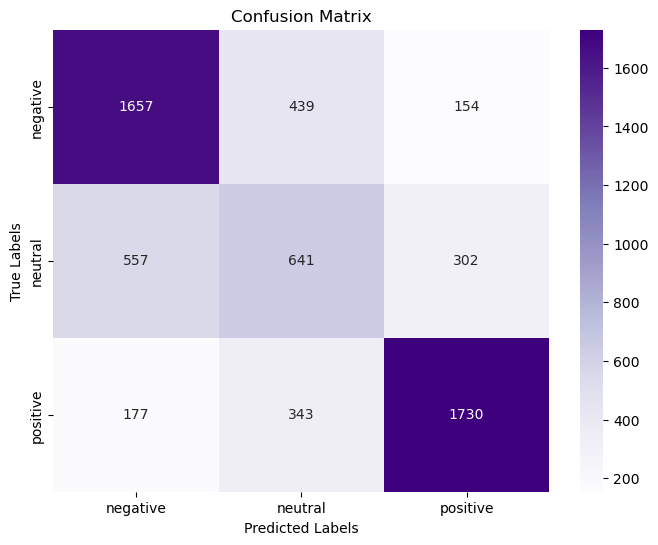

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0912 - accuracy: 0.3835 - val_loss: 1.0796 - val_accuracy: 0.3846
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0689 - accuracy: 0.4527 - val_loss: 1.0399 - val_accuracy: 0.5648
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.9794 - accuracy: 0.6217 - val_loss: 0.8883 - val_accuracy: 0.6615
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.8187 - accuracy: 0.6618 - val_loss: 0.7573 - val_accuracy: 0.6735
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7296 - accuracy: 0.6741 - val_loss: 0.7114 - val_accuracy: 0.6818
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6936 - accuracy: 0.6849 - val_loss: 0.6948 - val_accuracy: 0.6934
Epoch 7/7
1407/1407 [================

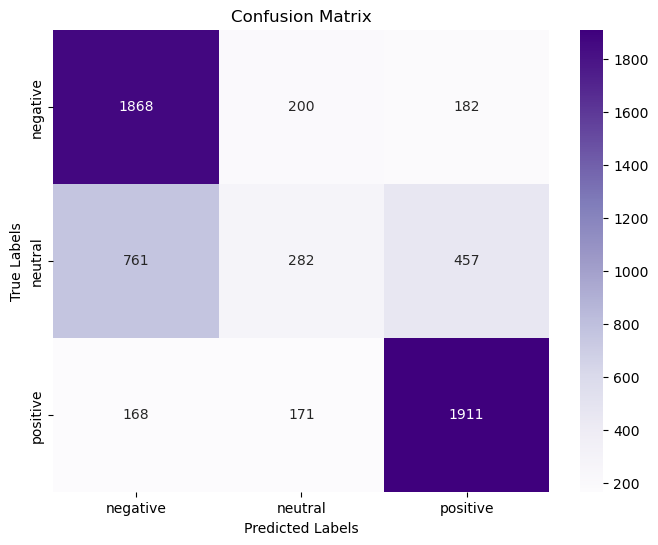

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8339 - accuracy: 0.6159 - val_loss: 0.6877 - val_accuracy: 0.6946
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6509 - accuracy: 0.7158 - val_loss: 0.6638 - val_accuracy: 0.7071
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5883 - accuracy: 0.7529 - val_loss: 0.6680 - val_accuracy: 0.7102
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5379 - accuracy: 0.7814 - val_loss: 0.6894 - val_accuracy: 0.7053
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4888 - accuracy: 0.8102 - val_loss: 0.7184 - val_accuracy: 0.6980
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4285 - accuracy: 0.8407 - val_loss: 0.7754 - val_accuracy: 0.6892
Epoch 7/7
1407/1407 [================

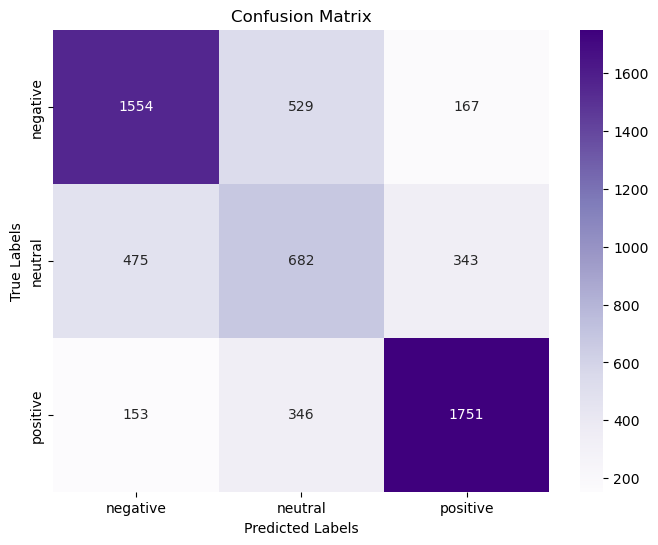

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0908 - accuracy: 0.3976 - val_loss: 1.0791 - val_accuracy: 0.4287
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0701 - accuracy: 0.4789 - val_loss: 1.0439 - val_accuracy: 0.6237
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.9873 - accuracy: 0.6283 - val_loss: 0.8982 - val_accuracy: 0.6587
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8306 - accuracy: 0.6596 - val_loss: 0.7689 - val_accuracy: 0.6708
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7428 - accuracy: 0.6706 - val_loss: 0.7225 - val_accuracy: 0.6768
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7039 - accuracy: 0.6827 - val_loss: 0.7041 - val_accuracy: 0.6835
Epoch 7/7
1407/1407 [================

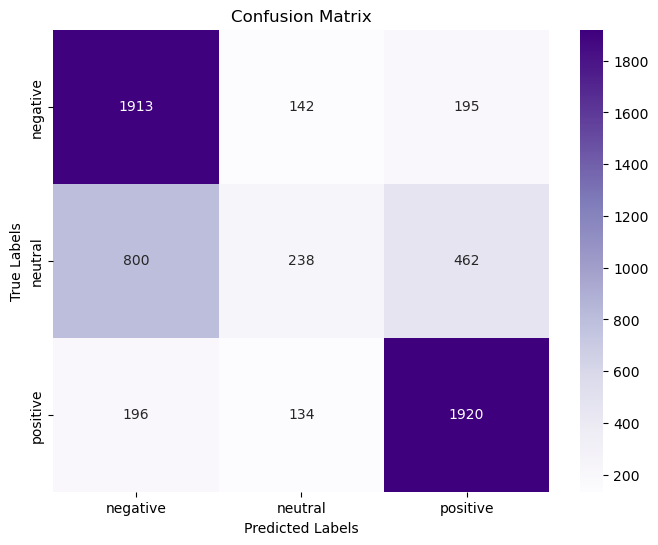

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8097 - accuracy: 0.6232 - val_loss: 0.6756 - val_accuracy: 0.7014
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6247 - accuracy: 0.7297 - val_loss: 0.6598 - val_accuracy: 0.7087
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5652 - accuracy: 0.7653 - val_loss: 0.6774 - val_accuracy: 0.7021
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5152 - accuracy: 0.7928 - val_loss: 0.6984 - val_accuracy: 0.6981
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4573 - accuracy: 0.8232 - val_loss: 0.7491 - val_accuracy: 0.6955
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.3914 - accuracy: 0.8547 - val_loss: 0.8173 - val_accuracy: 0.6895
Epoch 7/7
1407/1407 [================

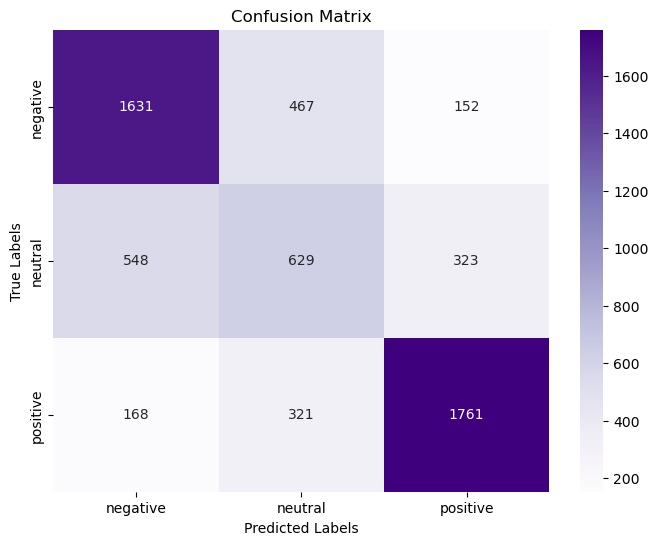

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0887 - accuracy: 0.3832 - val_loss: 1.0744 - val_accuracy: 0.3846
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0683 - accuracy: 0.4452 - val_loss: 1.0422 - val_accuracy: 0.5944
Epoch 3/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.9659 - accuracy: 0.6141 - val_loss: 0.8591 - val_accuracy: 0.6506
Epoch 4/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7968 - accuracy: 0.6513 - val_loss: 0.7515 - val_accuracy: 0.6648
Epoch 5/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7264 - accuracy: 0.6679 - val_loss: 0.7158 - val_accuracy: 0.6795
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6891 - accuracy: 0.6872 - val_loss: 0.6969 - val_accuracy: 0.6903
Epoch 7/7
1407/1407 [================

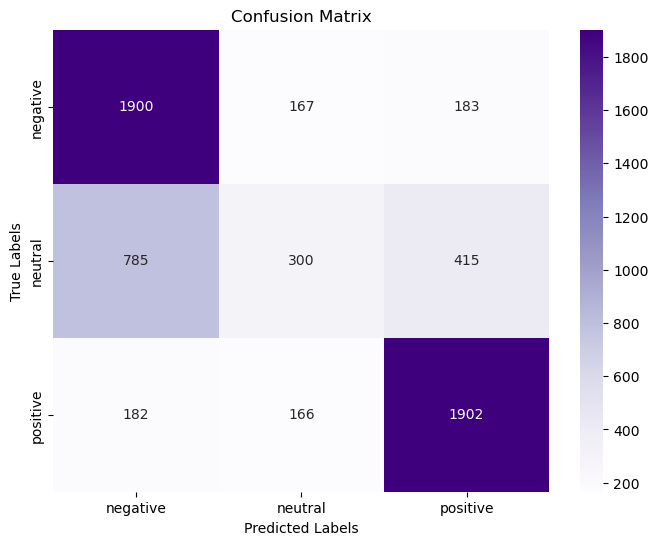

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 0.8406 - accuracy: 0.6174 - val_loss: 0.6856 - val_accuracy: 0.6926
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6551 - accuracy: 0.7108 - val_loss: 0.6595 - val_accuracy: 0.7073
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6018 - accuracy: 0.7462 - val_loss: 0.6582 - val_accuracy: 0.7091
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5670 - accuracy: 0.7653 - val_loss: 0.6700 - val_accuracy: 0.7068
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5358 - accuracy: 0.7808 - val_loss: 0.6876 - val_accuracy: 0.7023
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5034 - accuracy: 0.7980 - val_loss: 0.7118 - val_accuracy: 0.6968
Epoch 7/7
1407/1407 [================

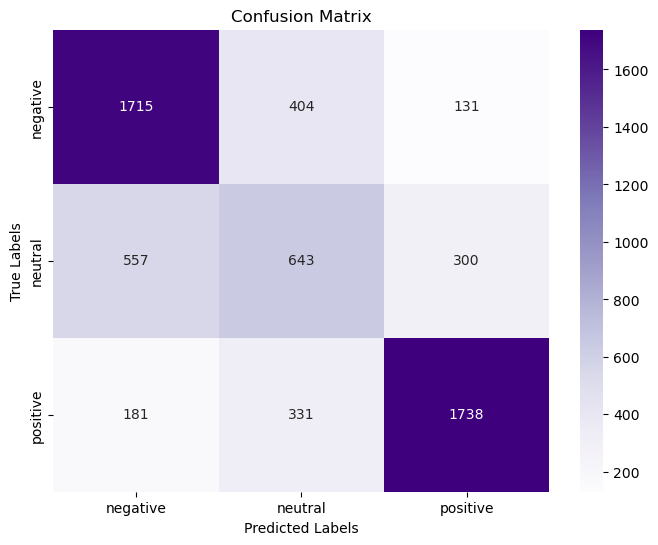

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0907 - accuracy: 0.4055 - val_loss: 1.0782 - val_accuracy: 0.4335
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 1.0637 - accuracy: 0.5054 - val_loss: 1.0338 - val_accuracy: 0.5955
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.9924 - accuracy: 0.6233 - val_loss: 0.9317 - val_accuracy: 0.6564
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8800 - accuracy: 0.6581 - val_loss: 0.8218 - val_accuracy: 0.6703
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7904 - accuracy: 0.6677 - val_loss: 0.7540 - val_accuracy: 0.6748
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7369 - accuracy: 0.6738 - val_loss: 0.7193 - val_accuracy: 0.6781
Epoch 7/7
1407/1407 [================

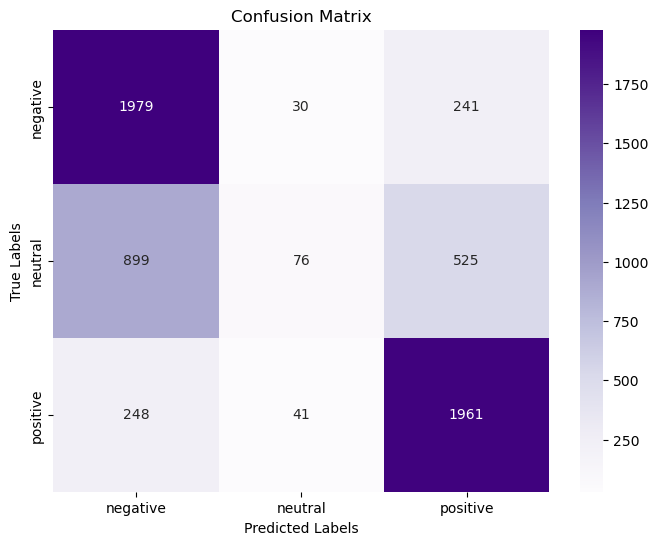

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8109 - accuracy: 0.6303 - val_loss: 0.6794 - val_accuracy: 0.6978
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6332 - accuracy: 0.7238 - val_loss: 0.6572 - val_accuracy: 0.7129
Epoch 3/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5800 - accuracy: 0.7554 - val_loss: 0.6622 - val_accuracy: 0.7107
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5421 - accuracy: 0.7766 - val_loss: 0.6808 - val_accuracy: 0.7002
Epoch 5/7
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5021 - accuracy: 0.8006 - val_loss: 0.7066 - val_accuracy: 0.7043
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4594 - accuracy: 0.8210 - val_loss: 0.7369 - val_accuracy: 0.6968
Epoch 7/7
1407/1407 [================

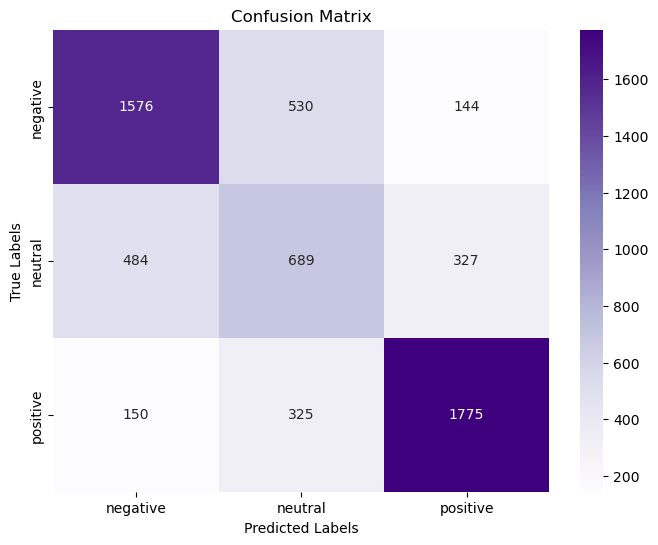

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0909 - accuracy: 0.3912 - val_loss: 1.0785 - val_accuracy: 0.3862
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0612 - accuracy: 0.4702 - val_loss: 1.0183 - val_accuracy: 0.6083
Epoch 3/7
1407/1407 [==============================] - 5s 4ms/step - loss: 0.9382 - accuracy: 0.6350 - val_loss: 0.8435 - val_accuracy: 0.6645
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7909 - accuracy: 0.6611 - val_loss: 0.7503 - val_accuracy: 0.6738
Epoch 5/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7270 - accuracy: 0.6718 - val_loss: 0.7166 - val_accuracy: 0.6795
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6968 - accuracy: 0.6824 - val_loss: 0.7018 - val_accuracy: 0.6876
Epoch 7/7
1407/1407 [================

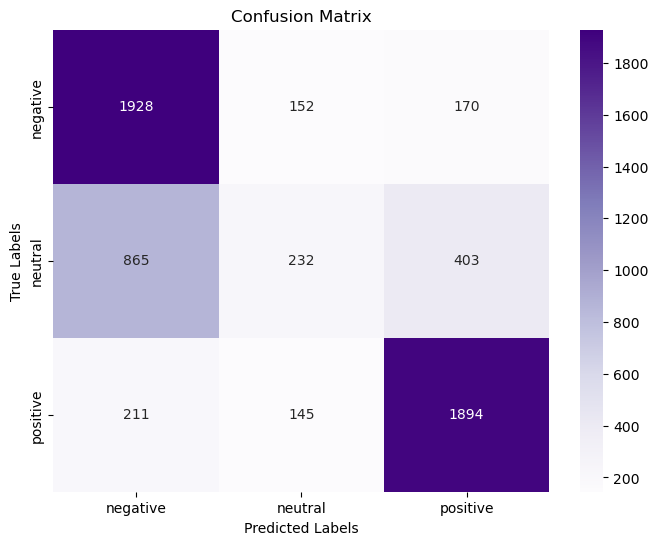

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.8294 - accuracy: 0.6224 - val_loss: 0.6932 - val_accuracy: 0.6867
Epoch 2/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6623 - accuracy: 0.7054 - val_loss: 0.6744 - val_accuracy: 0.7010
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6056 - accuracy: 0.7423 - val_loss: 0.6707 - val_accuracy: 0.7078
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5553 - accuracy: 0.7705 - val_loss: 0.6865 - val_accuracy: 0.7087
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5096 - accuracy: 0.7959 - val_loss: 0.7130 - val_accuracy: 0.7004
Epoch 6/7
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4563 - accuracy: 0.8248 - val_loss: 0.7560 - val_accuracy: 0.6933
Epoch 7/7
1407/1407 [================

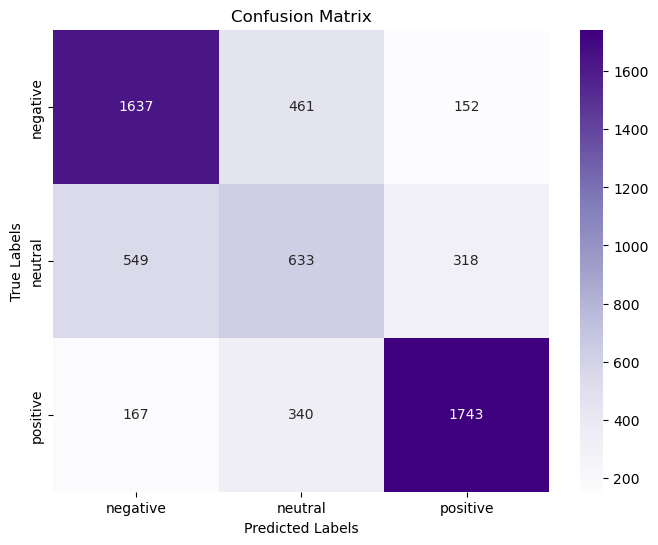

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 4s 2ms/step - loss: 1.0924 - accuracy: 0.3982 - val_loss: 1.0827 - val_accuracy: 0.5018
Epoch 2/7
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0732 - accuracy: 0.4765 - val_loss: 1.0460 - val_accuracy: 0.6174
Epoch 3/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.9891 - accuracy: 0.6248 - val_loss: 0.9006 - val_accuracy: 0.6635
Epoch 4/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8391 - accuracy: 0.6598 - val_loss: 0.7733 - val_accuracy: 0.6732
Epoch 5/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7528 - accuracy: 0.6705 - val_loss: 0.7250 - val_accuracy: 0.6781
Epoch 6/7
1407/1407 [==============================] - 3s 2ms/step - loss: 0.7131 - accuracy: 0.6810 - val_loss: 0.7053 - val_accuracy: 0.6848
Epoch 7/7
1407/1407 [================

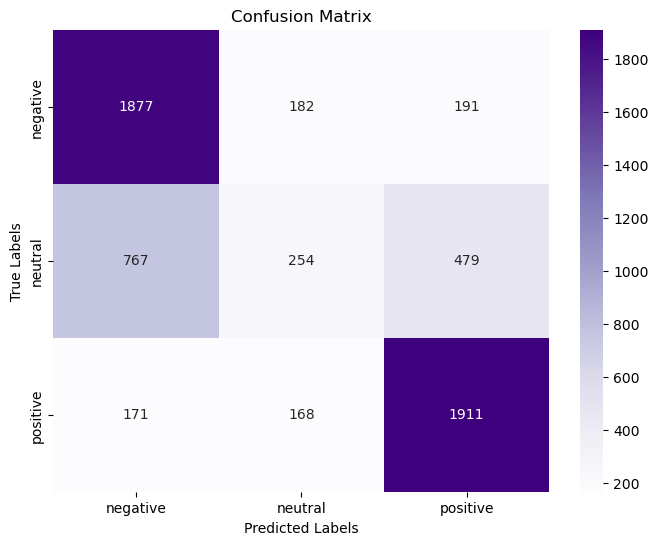

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 6s 3ms/step - loss: 0.8084 - accuracy: 0.6236 - val_loss: 0.6783 - val_accuracy: 0.7003
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6290 - accuracy: 0.7268 - val_loss: 0.6590 - val_accuracy: 0.7144
Epoch 3/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5669 - accuracy: 0.7637 - val_loss: 0.6707 - val_accuracy: 0.7049
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5129 - accuracy: 0.7936 - val_loss: 0.7006 - val_accuracy: 0.6995
Epoch 5/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.4500 - accuracy: 0.8272 - val_loss: 0.7530 - val_accuracy: 0.6897
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.3744 - accuracy: 0.8645 - val_loss: 0.8315 - val_accuracy: 0.6811
Epoch 7/7
1407/1407 [================

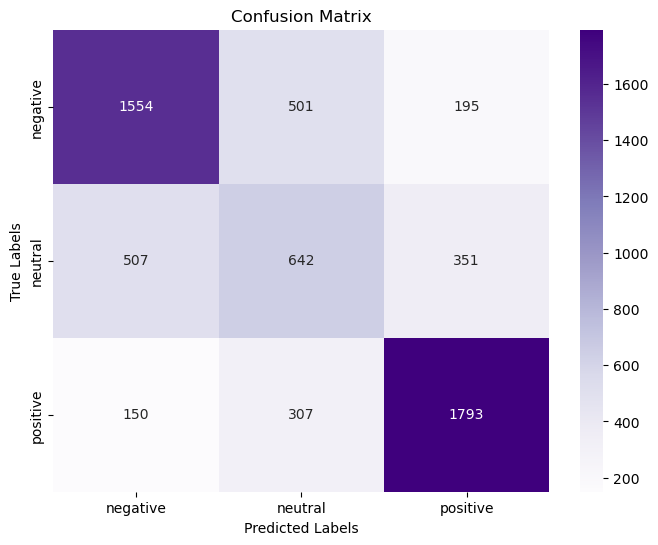

-------------------------------------------------------------------------------------------------------

Epoch 1/7
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0898 - accuracy: 0.4212 - val_loss: 1.0718 - val_accuracy: 0.5294
Epoch 2/7
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0132 - accuracy: 0.5929 - val_loss: 0.8973 - val_accuracy: 0.6555
Epoch 3/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8097 - accuracy: 0.6578 - val_loss: 0.7450 - val_accuracy: 0.6715
Epoch 4/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7198 - accuracy: 0.6735 - val_loss: 0.7102 - val_accuracy: 0.6792
Epoch 5/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6884 - accuracy: 0.6864 - val_loss: 0.6985 - val_accuracy: 0.6854
Epoch 6/7
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6681 - accuracy: 0.6964 - val_loss: 0.6921 - val_accuracy: 0.6863
Epoch 7/7
1407/1407 [================

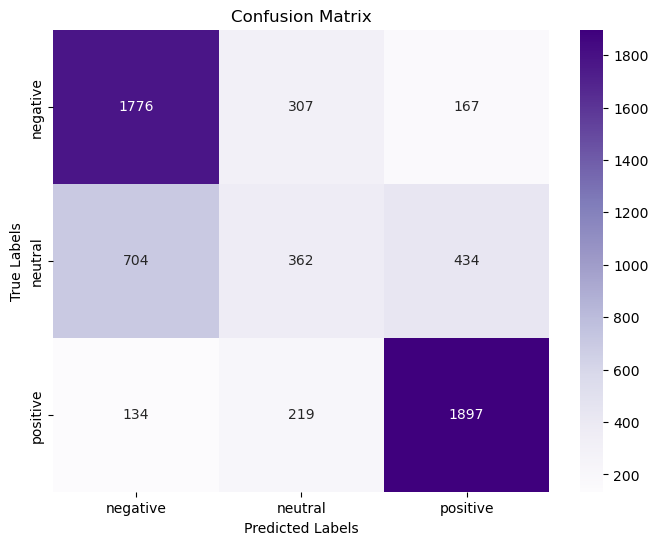

-------------------------------------------------------------------------------------------------------



In [15]:
#codul testat ulterior pe 4 si 5 layere, antrenat pe 7 epoci
for max_ft in [3000, 5000]:
    for ngram_range in [(1, 1), (1, 2), (1, 3)]: 
        for layers_no in [4, 5]:
            for units_no in [64, 96]:
                for learning_rate in [0.0001, 0.00001]:
                    tfidf_vectorizer = TfidfVectorizer(ngram_range = ngram_range, max_features = max_ft)
                    train_tfidf = tfidf_vectorizer.fit_transform(preprocessed_data_train['text']) 
                    test_tfidf = tfidf_vectorizer.transform(preprocessed_data_test['text'])
                    val_tfidf = tfidf_vectorizer.transform(preprocessed_data_validation['text'])
                    
                    build_model = [tf.keras.layers.Input(shape = (max_ft,), sparse = True)]
                    for i in range (0, layers_no):
                        build_model.append(tf.keras.layers.Dense(units_no, activation = 'relu'))
                    build_model.append(tf.keras.layers.Dropout(0.3))
                    build_model.append(tf.keras.layers.Dense(3, activation = 'softmax'))
                    model = tf.keras.models.Sequential(build_model)
                    optimizer = Adam(learning_rate = learning_rate)  
                    model.compile(optimizer = optimizer,
                         loss = 'sparse_categorical_crossentropy',
                         metrics = ['accuracy'])
                    train_tfidf_sorted = sort_sparse_indices(train_tfidf)

                    model.fit(sort_sparse_indices(train_tfidf), np.array(list_labels),
                        epochs = 7, batch_size = 32, initial_epoch = 0, 
                        validation_data=(sort_sparse_indices(val_tfidf), np.array(list_val))) 
                    test_loss, test_metrics = model.evaluate(sort_sparse_indices(test_tfidf), np.array(list_test), verbose = 0) 
                    print('\n ngram_range -', ngram_range, 'max_ft -', max_ft, 'layers_no -',layers_no, 'units_no -',units_no, 'learning_rate -',learning_rate, '- LOSS -', test_loss, ' ACCURACY -', test_metrics)
                    
                    test_predictions = model.predict(sort_sparse_indices(test_tfidf))
                    predicted_labels = np.argmax(test_predictions, axis = 1)
                    
                    print(classification_report(np.array(list_test), predicted_labels))
                    conf_matrix = confusion_matrix(np.array(list_test), predicted_labels)
                    
                    plt.figure(figsize = (8, 6))
                    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Purples", xticklabels = ['negative','neutral', 'positive'], yticklabels = ['negative', 'neutral', 'positive'])
                    plt.xlabel('Predicted Labels')
                    plt.ylabel('True Labels')
                    plt.title('Confusion Matrix')
                    plt.show()
                    print("-------------------------------------------------------------------------------------------------------\n")